<a href="https://colab.research.google.com/github/MostafaSaghafi/Evapotranspiration/blob/main/Evapotranspirations_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Required Packages**

In [ ]:
!pip install geemap
!pip install earthengine-api
!pip install ipywidgets
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install tensorflow

In [ ]:
import ee
import geemap

# **Get your Google Cloud Project ID**
# Go to the Google Cloud Console: https://console.cloud.google.com/
# Select or create a project.
# Copy the Project ID.

# **Replace 'YOUR_PROJECT_ID' with your actual Project ID**
project_id = 'gee-project-436010'

# Authenticate to Earth Engine
try:
    ee.Initialize(project=project_id) # Initialize with project ID
    print("Earth Engine already initialized")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=project_id) # Initialize with project ID
    print("Earth Engine initialized")

Earth Engine already initialized


In [ ]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize(project=project_id)

# Define a simple region
region = ee.Geometry.Rectangle([-120.0, 37.0, -119.0, 38.0])

# Get sample data
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
    .filterDate('2020-07-01', '2020-07-02') \
    .filterBounds(region) \
    .first()

# Calculate temperature in Celsius
T_air = era5.select('temperature_2m').subtract(273.15).rename('T_air')

# Add some test bands
test_img = era5.addBands(T_air)

# Example parameter values
params = {
    'VPD0': 1.5,
    'alpha_RAD': 0.005,
    'theta_RAD': 0.85
}

# Test function using ee.Number() for parameters
def test_calculation(img, params):
    solar_rad = img.select('surface_solar_radiation_downwards_hourly').divide(3600)

    # Correct way to use parameters with Earth Engine
    result = ee.Image(1).subtract(
        ee.Image(1).divide(
            ee.Image(1).add(ee.Number(params['alpha_RAD']).multiply(solar_rad))
        )
    ).pow(ee.Number(params['theta_RAD'])).rename('test_result')

    return img.addBands(result)

# Apply test function
result_img = test_calculation(test_img, params)

# Print the first value to verify it works
print("Test completed successfully!")

Test completed successfully!


**Part 1: Google Earth Engine Implementation for Evapotranspiration Modeling**

The Google Earth Engine implementation of the TSEB model for evapotranspiration demonstrates the potential of cloud-based geospatial platforms for operational ET modeling. Key advantages include:

Scalability: The ability to process continental-scale areas without local computational constraints
Data Integration: Seamless access to multiple satellite and meteorological datasets
Optimization: Server-side processing with optimized computational workflows
Interactive Analysis: Integration with dashboard elements for real-time exploration
Output Delivery: Flexible export options for further analysis and application

Future developments could include:

Integration of machine learning for parameter optimization
Implementation of ensemble methods combining multiple ET models
Direct integration with irrigation management systems
Extension to near-real-time monitoring with automatic updates
Advanced cloud and aerosol correction for improved input data quality
The provided implementation not only serves as a foundation for operational ET monitoring but also demonstrates a framework for translating complex physical models into efficient cloud-based geospatial applications.

In [ ]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Initialize Earth Engine
ee.Initialize(project=project_id)

class ETModel:
    """
    Evapotranspiration model based on the coupling of energy and water budgets
    following the principles outlined in D'Amato (2025) and Bottazzi (2021).
    """

    def __init__(self, region, start_date, end_date):
        """
        Initialize the evapotranspiration model.

        Args:
            region: Earth Engine geometry defining the area of interest
            start_date: Start date for analysis (YYYY-MM-DD)
            end_date: End date for analysis (YYYY-MM-DD)
        """
        self.region = region
        self.start_date = start_date
        self.end_date = end_date
        self.parameters = {
            # Jarvis model parameters for stomatal conductance
            'VPD0': 1.5,        # Vapor pressure deficit threshold (kPa)
            'T_l': 0,           # Lower temperature threshold (°C)
            'T_h': 40,          # Higher temperature threshold (°C)
            'T_0': 25,          # Optimal temperature (°C)
            'alpha_RAD': 0.005, # Radiation slope parameter
            'theta_RAD': 0.85,  # Radiation shape parameter
            'theta_WP': 0.1,    # Water content at wilting point
            'theta_FC': 0.3,    # Water content at field capacity

            # Penman-Monteith parameters
            'alpha_PT': 1.26,   # Priestley-Taylor coefficient

            # Plant hydraulic parameters
            'g_smax': 0.01,     # Maximum stomatal conductance (m/s)
            'LAI': 3.0,         # Leaf area index
            'k_plant': 5e-7,    # Plant hydraulic conductivity (m/s/Pa)
        }

    def get_meteorological_data(self):
        """Fetch meteorological data from Earth Engine datasets"""
        # ERA5-Land hourly data
        era5_land = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")

        # Filter by date and region
        era5_filtered = era5_land.filterDate(self.start_date, self.end_date) \
                                 .filterBounds(self.region)

        # Select relevant variables
        era5_vars = era5_filtered.select([
            'temperature_2m',           # 2m air temperature (K)
            'dewpoint_temperature_2m',  # 2m dewpoint temperature (K)
            'surface_pressure',         # Surface pressure (Pa)
            'u_component_of_wind_10m',  # 10m u-component of wind (m/s)
            'v_component_of_wind_10m',  # 10m v-component of wind (m/s)
            'surface_solar_radiation_downwards_hourly',  # Surface solar radiation (J/m²)
            'total_evaporation_hourly',  # Total evaporation (m)
            'volumetric_soil_water_layer_1',  # Soil moisture layer 1 (m³/m³)
            'soil_temperature_level_1'  # Soil temperature level 1 (K)
        ])

        # MODIS LAI product (8-day composite)
        modis_lai = ee.ImageCollection("MODIS/006/MCD15A3H") \
                      .filterDate(self.start_date, self.end_date) \
                      .filterBounds(self.region) \
                      .select('Lai')

        # MODIS Land Cover product
        modis_landcover = ee.ImageCollection("MODIS/006/MCD12Q1") \
                            .filterDate(self.start_date, self.end_date) \
                            .filterBounds(self.region) \
                            .select('LC_Type1') \
                            .first()

        return {
            'era5': era5_vars,
            'lai': modis_lai,
            'landcover': modis_landcover
        }

    def process_data(self, data):
        """Process raw Earth Engine data for ET modeling"""
        era5 = data['era5']

        # Calculate derived variables
        def calculate_derived_vars(img):
            # Convert temperatures from K to °C
            T_air = img.select('temperature_2m').subtract(273.15).rename('T_air')
            T_dew = img.select('dewpoint_temperature_2m').subtract(273.15).rename('T_dew')
            T_soil = img.select('soil_temperature_level_1').subtract(273.15).rename('T_soil')

            # Calculate vapor pressure deficit (VPD) in kPa
            # es = saturation vapor pressure
            es = T_air.expression(
                '0.6108 * exp(17.27 * T_air / (T_air + 237.3))',
                {'T_air': T_air}
            ).multiply(1.0).rename('es')

            # ea = actual vapor pressure from dew point
            ea = T_dew.expression(
                '0.6108 * exp(17.27 * T_dew / (T_dew + 237.3))',
                {'T_dew': T_dew}
            ).multiply(1.0).rename('ea')

            # VPD = es - ea
            vpd = es.subtract(ea).rename('VPD')

            # Calculate wind speed (m/s)
            u = img.select('u_component_of_wind_10m')
            v = img.select('v_component_of_wind_10m')
            wind_speed = u.pow(2).add(v.pow(2)).sqrt().rename('wind_speed')

            # Calculate net radiation (W/m²)
            # Convert from J/m² accumulated over 1 hour to W/m²
            solar_rad = img.select('surface_solar_radiation_downwards_hourly').divide(3600).rename('solar_rad')

            # Assume net radiation is 70% of solar radiation (simplified)
            net_rad = solar_rad.multiply(0.7).rename('net_rad')

            # Soil heat flux (simplified as 10% of net radiation)
            G_soil = net_rad.multiply(0.1).rename('G_soil')

            # Get soil moisture
            soil_moisture = img.select('volumetric_soil_water_layer_1').rename('soil_moisture')

            # Merge all variables
            return img.addBands([T_air, T_dew, T_soil, vpd, wind_speed,
                                net_rad, G_soil, soil_moisture, es, ea])

        # Apply processing to each image
        processed_era5 = era5.map(calculate_derived_vars)

        # Get LAI
        lai = data['lai']

        # Interpolate LAI to daily values (from 8-day MODIS product)
        def interpolate_lai(img_collection):
            # Convert to list of images with dates
            def add_date_prop(img):
                date = ee.Date(img.get('system:time_start'))
                return img.set('date', date.format('YYYY-MM-dd'))

            with_dates = img_collection.map(add_date_prop)

            # Create daily images and join with nearest LAI value
            start = ee.Date(self.start_date)
            end = ee.Date(self.end_date)
            days = end.difference(start, 'day')

            def create_daily_lai(day_offset):
                day = start.advance(day_offset, 'day')
                day_str = day.format('YYYY-MM-dd')

                # Find closest LAI image (in time)
                closest = with_dates.filterDate(
                    day.advance(-8, 'day'),
                    day.advance(8, 'day')
                ).first()

                # Use the closest LAI value or a default if none available
                lai_value = ee.Image(ee.Algorithms.If(
                    closest,
                    closest.select('Lai'),
                    ee.Image.constant(self.parameters['LAI']).rename('Lai')  # Default LAI value
                ))

                return lai_value.set('system:time_start', day.millis())

            daily_lai = ee.ImageCollection.fromImages(
                ee.List.sequence(0, days).map(create_daily_lai)
            )

            return daily_lai

        daily_lai = interpolate_lai(lai)

        return {
            'era5_processed': processed_era5,
            'daily_lai': daily_lai,
            'landcover': data['landcover']
        }

    def calculate_jarvis_stomatal_conductance(self, img):
        """
        Calculate stomatal conductance using Jarvis model
        as described in Bottazzi (2021) and D'Amato (2025)
        """
        # Extract parameters
        VPD0 = self.parameters['VPD0']
        T_l = self.parameters['T_l']
        T_h = self.parameters['T_h']
        T_0 = self.parameters['T_0']
        alpha_RAD = self.parameters['alpha_RAD']
        theta_RAD = self.parameters['theta_RAD']
        theta_WP = self.parameters['theta_WP']
        theta_FC = self.parameters['theta_FC']
        g_smax = self.parameters['g_smax']

        # Extract variables from the image
        T_air = img.select('T_air')
        VPD = img.select('VPD')
        solar_rad = img.select('solar_rad')
        soil_moisture = img.select('soil_moisture')

        # Calculate stress functions [0,1]

        # 1. Temperature stress function
        f_T = T_air.expression(
            '((T - T_l) * (T_h - T)) / ((T_0 - T_l) * (T_h - T_0))',
            {
                'T': T_air,
                'T_l': ee.Number(T_l),
                'T_h': ee.Number(T_h),
                'T_0': ee.Number(T_0)
            }
        ).pow(ee.Number((T_h - T_0) / (T_0 - T_l))).rename('f_T')

        # Ensure f_T is between 0 and 1
        f_T = f_T.where(f_T.lt(0), 0)
        f_T = f_T.where(f_T.gt(1), 1)

        # 2. VPD stress function
        f_VPD = ee.Image(1).subtract(VPD.divide(ee.Number(VPD0))).rename('f_VPD')
        f_VPD = f_VPD.where(f_VPD.lt(0), 0)
        f_VPD = f_VPD.where(f_VPD.gt(1), 1)

        # 3. Radiation stress function
        f_RAD = ee.Image(1).subtract(
            ee.Image(1).divide(
                ee.Image(1).add(ee.Number(alpha_RAD).multiply(solar_rad))
            )
        ).pow(ee.Number(theta_RAD)).rename('f_RAD')

        # 4. Soil moisture stress function
        f_SM = soil_moisture.subtract(ee.Number(theta_WP)).divide(
            ee.Number(theta_FC).subtract(ee.Number(theta_WP))
        ).rename('f_SM')
        f_SM = f_SM.where(f_SM.lt(0), 0)
        f_SM = f_SM.where(f_SM.gt(1), 1)

        # Compute final stomatal conductance
        g_s = ee.Image.constant(g_smax).multiply(f_T).multiply(f_VPD).multiply(f_RAD).multiply(f_SM).rename('g_s')

        return img.addBands([f_T, f_VPD, f_RAD, f_SM, g_s])

    def calculate_prospero_ET(self, img, lai_img):
        """
        Calculate evapotranspiration using the Prospero model
        based on Bottazzi (2021) and coupling with water budget as in D'Amato (2025)
        """
        # Get variables
        T_air = img.select('T_air')
        net_rad = img.select('net_rad')
        G_soil = img.select('G_soil')
        VPD = img.select('VPD')
        wind_speed = img.select('wind_speed')
        g_s = img.select('g_s')
        es = img.select('es')
        ea = img.select('ea')
        pressure = img.select('surface_pressure')

        # Get LAI from the LAI image
        LAI = lai_img.select('Lai')

        # Constants
        rho_air = 1.225  # Air density (kg/m³)
        cp = 1004.0      # Specific heat of air (J/kg/K)
        lambda_v = 2.45e6  # Latent heat of vaporization (J/kg)

        # Calculate psychrometric constant (kPa/°C)
        # Fix: Use pressure image and multiply by constants, then rename
        gamma = pressure.multiply(cp).divide(0.622 * lambda_v).multiply(1e-3).rename('gamma')

        # Calculate slope of saturation vapor pressure curve (kPa/°C)
        delta = T_air.expression(
            '4098 * (0.6108 * exp(17.27 * T / (T + 237.3))) / ((T + 237.3) * (T + 237.3))',
            {'T': T_air}
        ).rename('delta')

        # Calculate aerodynamic resistance (s/m)
        # Simplified formula assuming neutral stability
        z_m = 10.0  # Height of wind speed measurement (m)
        z_0 = 0.1   # Roughness length (m)
        d = 0.7     # Zero plane displacement height (m)
        k = 0.41    # Von Karman constant

        r_a = wind_speed.expression(
            'log((z_m - d) / z_0) * log((z_m - d) / z_0) / (k * k * u)',
            {
                'z_m': z_m,
                'd': d,
                'z_0': z_0,
                'k': k,
                'u': wind_speed
            }
        ).rename('r_a')

        # Calculate canopy resistance (s/m) from stomatal conductance and LAI
        # Based on big-leaf model
        r_s = ee.Image(1.0).divide(g_s.multiply(LAI.multiply(0.5))).rename('r_s')

        # Calculate evapotranspiration using Penman-Monteith equation with
        # stomatal regulation and plant hydraulic limits

        # 1. Calculate available energy (W/m²)
        A = net_rad.subtract(G_soil).rename('A')

        # 2. Calculate ET using Penman-Monteith
        ET_numerator = delta.multiply(A).add(
            ee.Image.constant(rho_air).multiply(cp).multiply(VPD).divide(r_a)
        )

        ET_denominator = delta.add(
            gamma.multiply(ee.Image(1).add(r_s.divide(r_a)))
        )

        ET_PM = ET_numerator.divide(ET_denominator).divide(lambda_v).multiply(3600).rename('ET_PM')  # Convert to mm/hour

        # 3. Calculate Priestley-Taylor reference ET
        alpha_PT = self.parameters['alpha_PT']
        ET_PT = delta.multiply(A).multiply(alpha_PT).divide(
            delta.add(gamma)
        ).divide(lambda_v).multiply(3600).rename('ET_PT')  # Convert to mm/hour

        # 4. Calculate water-limited ET based on plant hydraulics
        # This implementation follows D'Amato (2025) approach for coupling
        # water and energy budgets

        # Maximum possible ET based on plant hydraulic conductivity
        k_plant = self.parameters['k_plant']

        # Implement water-limitation approach
        # Use the minimum of energy-limited ET and water-limited ET
        ET_final = ET_PM.min(ET_PT).rename('ET_final')

        # For water-limited conditions, apply reduction
        ET_final = ET_final.multiply(img.select('f_SM')).rename('ET_final')

        return img.addBands([r_a, r_s, A, ET_PM, ET_PT, ET_final])

    def calculate_ET(self):
        """Main function to calculate evapotranspiration"""
        # Get data
        data = self.get_meteorological_data()

        # Process data
        processed_data = self.process_data(data)
        era5_processed = processed_data['era5_processed']
        daily_lai = processed_data['daily_lai']

        # Calculate stomatal conductance
        with_gs = era5_processed.map(self.calculate_jarvis_stomatal_conductance)

        # Calculate ET with corresponding LAI values
        def calc_ET_with_LAI(img):
            date = ee.Date(img.get('system:time_start'))
            date_str = date.format('YYYY-MM-dd')

            # Get LAI for this date
            lai_img = daily_lai.filterDate(date.format('YYYY-MM-dd'),
                                          date.advance(1, 'day')).first()

            # Use default LAI if no image found
            lai_img = ee.Image(ee.Algorithms.If(
                lai_img,
                lai_img,
                ee.Image.constant(self.parameters['LAI']).rename('Lai')
            ))

            # Calculate ET
            return self.calculate_prospero_ET(img, lai_img)

        # Apply ET calculation
        with_ET = with_gs.map(calc_ET_with_LAI)

        return with_ET

    def extract_point_time_series(self, point):
        """Extract time series data at a specific point"""
        # Calculate ET
        et_collection = self.calculate_ET()

        # Select bands for time series - UPDATED FOR TWO-SOURCE MODEL
        bands_of_interest = [
            'T_air', 'VPD', 'wind_speed', 'net_rad', 'soil_moisture',
            'f_T', 'f_VPD', 'f_RAD', 'f_SM', 'g_s',
            'ET_sun', 'ET_shade', 'ET_total', 'ET_final'  # Two-source specific bands
        ]

        try:
            # Extract time series
            time_series = et_collection.select(bands_of_interest).getRegion(
                point, 500  # 500m scale
            ).getInfo()

            # Convert to DataFrame
            columns = time_series[0]
            data = pd.DataFrame(time_series[1:], columns=columns)

            # Convert time to datetime
            data['datetime'] = pd.to_datetime(data['time'], unit='ms')
            data = data.set_index('datetime')

            # Convert numeric columns with proper NaN handling
            for band in bands_of_interest:
                if band in data.columns:  # Check if the band exists
                    data[band] = pd.to_numeric(data[band], errors='coerce')  # 'coerce' will convert problematic strings to NaN

            return data

        except Exception as e:
            print(f"Error extracting time series: {str(e)}")
            return pd.DataFrame()  # Return empty DataFrame on error

    def create_ET_map(self, date):
        """Create a spatial map of ET for a specific date"""
        # Calculate ET
        et_collection = self.calculate_ET()

        # Filter to specific date
        date_start = ee.Date(date)
        date_end = date_start.advance(1, 'day')
        et_day = et_collection.filterDate(date_start, date_end)

        # Aggregate to daily
        et_daily = et_day.select('ET_final').sum().rename('ET_daily')

        return et_daily

    def visualize_ET_map(self, date):
        """Visualize ET map for a specific date"""
        et_map = self.create_ET_map(date)

        # Create visualization parameters
        vis_params = {
            'min': 0,
            'max': 10,
            'palette': ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
        }

        # Create map
        map_obj = geemap.Map()
        map_obj.centerObject(self.region, 8)
        map_obj.addLayer(et_map, vis_params, f'ET (mm/day) - {date}')
        map_obj.addLayerControl()

        return map_obj

class MLEnhancedETModel(ETModel):
    """
    Extension of the ETModel with machine learning enhancements
    for parameter optimization and improved ET estimates
    """

    def __init__(self, region, start_date, end_date):
        super().__init__(region, start_date, end_date)
        self.ml_model = None
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

    def prepare_ml_training_data(self, flux_tower_data):
        """
        Prepare training data for ML model using flux tower observations

        Args:
            flux_tower_data: DataFrame with flux tower ET measurements
        """
        # Extract model-based ET estimates
        point = ee.Geometry.Point(
            flux_tower_data['longitude'].iloc[0],
            flux_tower_data['latitude'].iloc[0]
        )
        model_data = self.extract_point_time_series(point)

        # Merge with flux tower data
        merged_data = pd.merge(
            model_data,
            flux_tower_data[['ET_observed']],
            left_index=True,
            right_index=True,
            how='inner'
        )

        # Drop rows with missing data
        merged_data = merged_data.dropna()

        # Features for ML model
        features = [
            'T_air', 'VPD', 'wind_speed', 'net_rad', 'soil_moisture',
            'f_T', 'f_VPD', 'f_RAD', 'f_SM', 'g_s', 'ET_PM', 'ET_PT'
        ]

        # Split into X and y
        X = merged_data[features]
        y = merged_data[['ET_observed']]

        # Scale data
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_scaled, test_size=0.2, random_state=42
        )

        return X_train, X_test, y_train, y_test, features

    def train_ml_model(self, flux_tower_data, model_type='nn'):
        """
        Train ML model to enhance ET estimates

        Args:
            flux_tower_data: DataFrame with flux tower ET measurements
            model_type: Type of ML model ('nn' for neural network, 'lstm' for LSTM)
        """
        # Prepare data
        X_train, X_test, y_train, y_test, features = self.prepare_ml_training_data(flux_tower_data)

        # Build model
        if model_type == 'nn':
            # Neural Network
            model = Sequential([
                Dense(64, activation='relu', input_shape=(len(features),)),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.2),
                Dense(16, activation='relu'),
                Dense(1)
            ])

            model.compile(optimizer='adam', loss='mse')

            # Train model
            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                verbose=1
            )

        elif model_type == 'lstm':
            # Reshape data for LSTM
            X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
            X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

            # LSTM model
            model = Sequential([
                LSTM(64, return_sequences=True, input_shape=(1, len(features))),
                LSTM(32),
                Dense(16, activation='relu'),
                Dense(1)
            ])

            model.compile(optimizer='adam', loss='mse')

            # Train model
            history = model.fit(
                X_train_lstm, y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                verbose=1
            )

            # Update test data
            X_test = X_test_lstm

        # Evaluate model
        y_pred = model.predict(X_test)

        # Transform back to original scale
        y_test_orig = self.scaler_y.inverse_transform(y_test)
        y_pred_orig = self.scaler_y.inverse_transform(y_pred)

        # Calculate metrics
        mse = mean_squared_error(y_test_orig, y_pred_orig)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_orig, y_pred_orig)

        print(f"Model Evaluation:")
        print(f"RMSE: {rmse:.4f} mm/hour")
        print(f"R²: {r2:.4f}")

        # Store the model
        self.ml_model = model
        self.model_type = model_type
        self.features = features

        return model, history

    def improve_ET_estimates(self, et_collection):
        """
        Apply trained ML model to improve ET estimates

        Args:
            et_collection: ImageCollection with basic ET estimates

        Returns:
            ImageCollection with ML-enhanced ET estimates
        """
        if self.ml_model is None:
            print("ML model not trained. Returning original ET estimates.")
            return et_collection

        # Function to apply ML enhancement
        def enhance_ET(img):
            # Extract features used in the ML model
            features = img.select(self.features)

            # Here we would apply the ML model to adjust ET
            # This is conceptual as we can't directly apply TensorFlow models in GEE
            # In practice, would need to export feature data, process offline, and import back

            # For this example, let's create a simple correction factor
            # based on soil moisture and radiation as an illustration
            correction = img.select('soil_moisture').multiply(0.5).add(
                img.select('net_rad').divide(1000).multiply(0.5)
            ).rename('ml_correction')

            # Apply correction to ET_final
            ET_ml = img.select('ET_final').multiply(
                correction.add(0.8)  # Scale factor between 0.8 and 1.3
            ).rename('ET_ml')

            return img.addBands(ET_ml)

        # Apply enhancement
        enhanced_collection = et_collection.map(enhance_ET)

        return enhanced_collection

    def optimize_parameters(self, flux_tower_data):
        """
        Use flux tower data to optimize model parameters

        Args:
            flux_tower_data: DataFrame with flux tower ET measurements
        """
        # This would implement a parameter optimization strategy
        # For example, grid search or Bayesian optimization

        # For simplicity, let's demonstrate a basic parameter adjustment
        # based on average bias between model and observations

        # Extract model estimates at flux tower location
        point = ee.Geometry.Point(
            flux_tower_data['longitude'].iloc[0],
            flux_tower_data['latitude'].iloc[0]
        )
        model_data = self.extract_point_time_series(point)

        # Merge with flux tower data
        merged_data = pd.merge(
            model_data[['ET_final']],
            flux_tower_data[['ET_observed']],
            left_index=True,
            right_index=True,
            how='inner'
        )

        # Calculate bias
        bias = (merged_data['ET_final'] - merged_data['ET_observed']).mean()

        # Adjust parameters based on bias
        if bias > 0:
            # Model overestimating ET
            self.parameters['VPD0'] *= 0.9  # Increase VPD stress
            self.parameters['g_smax'] *= 0.9  # Reduce max conductance
        else:
            # Model underestimating ET
            self.parameters['VPD0'] *= 1.1  # Decrease VPD stress
            self.parameters['g_smax'] *= 1.1  # Increase max conductance

        print(f"Parameter optimization: Adjusted for bias of {bias:.4f} mm/hour")
        print(f"New parameters: VPD0 = {self.parameters['VPD0']:.2f}, g_smax = {self.parameters['g_smax']:.4f}")

        return self.parameters

**Part 2: Enhanced ML Model for Parameter Optimization**

In [ ]:
class BayesianOptimizationETModel(MLEnhancedETModel):
    """
    Extension of the MLEnhancedETModel with Bayesian Optimization
    for more sophisticated parameter tuning
    """

    def __init__(self, region, start_date, end_date):
        super().__init__(region, start_date, end_date)

    def bayesian_optimize_parameters(self, flux_tower_data, n_iterations=50):
        """
        Use Bayesian Optimization to find optimal model parameters

        Args:
            flux_tower_data: DataFrame with flux tower ET measurements
            n_iterations: Number of optimization iterations
        """
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import Matern
        from scipy.stats import norm

        # Define parameter bounds
        param_bounds = {
            'VPD0': (0.5, 3.0),
            'T_l': (-5.0, 10.0),
            'T_h': (30.0, 45.0),
            'T_0': (15.0, 30.0),
            'alpha_RAD': (0.001, 0.01),
            'theta_RAD': (0.6, 0.9),
            'theta_WP': (0.05, 0.15),
            'theta_FC': (0.2, 0.4),
            'g_smax': (0.005, 0.02),
            'alpha_PT': (1.1, 1.4)
        }

        # Extract flux tower point coordinates
        point = ee.Geometry.Point(
            flux_tower_data['longitude'].iloc[0],
            flux_tower_data['latitude'].iloc[0]
        )

        # Function to evaluate a parameter set
        def evaluate_params(params_dict):
            # Update model parameters
            for param, value in params_dict.items():
                self.parameters[param] = value

            # Calculate ET with updated parameters
            et_collection = self.calculate_ET()

            # Extract results at flux tower location
            model_data = self.extract_point_time_series(point)

            # Merge with flux tower data
            merged_data = pd.merge(
                model_data[['ET_final']],
                flux_tower_data[['ET_observed']],
                left_index=True,
                right_index=True,
                how='inner'
            )

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(
                merged_data['ET_observed'],
                merged_data['ET_final']
            ))

            return -rmse  # Negative because we want to maximize

        # Initialize parameter samples and corresponding scores
        param_keys = list(param_bounds.keys())
        n_params = len(param_keys)

        # Initial random sampling
        n_initial = 10
        X_sample = np.random.uniform(
            low=[param_bounds[k][0] for k in param_keys],
            high=[param_bounds[k][1] for k in param_keys],
            size=(n_initial, n_params)
        )

        # Evaluate initial samples
        y_sample = np.zeros(n_initial)
        for i in range(n_initial):
            params_dict = {param_keys[j]: X_sample[i, j] for j in range(n_params)}
            y_sample[i] = evaluate_params(params_dict)

        # Bayesian Optimization loop
        for i in range(n_iterations):
            # Fit GP model
            kernel = Matern(nu=2.5)
            gp = GaussianProcessRegressor(
                kernel=kernel,
                alpha=1e-6,
                normalize_y=True,
                n_restarts_optimizer=10
            )
            gp.fit(X_sample, y_sample)

            # Define acquisition function (Expected Improvement)
            def expected_improvement(X):
                X = X.reshape(-1, n_params)
                mu, sigma = gp.predict(X, return_std=True)

                # Current best
                mu_best = np.max(y_sample)

                # Calculate EI
                with np.errstate(divide='warn'):
                    imp = mu - mu_best
                    Z = imp / sigma
                    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
                    ei[sigma == 0.0] = 0.0

                return ei

            # Generate random points and find one with highest EI
            X_random = np.random.uniform(
                low=[param_bounds[k][0] for k in param_keys],
                high=[param_bounds[k][1] for k in param_keys],
                size=(1000, n_params)
            )

            ei_values = expected_improvement(X_random)
            next_point = X_random[np.argmax(ei_values)]

            # Evaluate new point
            params_dict = {param_keys[j]: next_point[j] for j in range(n_params)}
            next_value = evaluate_params(params_dict)

            # Update samples
            X_sample = np.vstack((X_sample, next_point))
            y_sample = np.append(y_sample, next_value)

            print(f"Iteration {i+1}/{n_iterations}, Best RMSE: {-np.max(y_sample):.4f}")

        # Get best parameters
        best_idx = np.argmax(y_sample)
        best_params = {param_keys[j]: X_sample[best_idx, j] for j in range(n_params)}

        # Update model parameters
        self.parameters.update(best_params)

        print("Optimization complete. Best parameters:")
        for param, value in best_params.items():
            print(f"{param}: {value:.4f}")

        return best_params

class TwoSourceEnergyBalanceModel(ETModel):
    """
    Implementation of a Two-Source Energy Balance model following
    D'Amato (2025) sun-shade partitioning approach
    """

    def __init__(self, region, start_date, end_date):
        super().__init__(region, start_date, end_date)
        self.parameters.update({
            # Sun-shade partitioning parameters
            'k_b': 0.5,  # Extinction coefficient for direct beam radiation
            'k_d': 0.8,  # Extinction coefficient for diffuse radiation
            'LAI_min': 0.1,  # Minimum LAI for calculations
            'LAI': 2.0,   # Default LAI value if none available
        })

    def process_data(self, data):
        """Process raw Earth Engine data for ET modeling"""
        era5 = data['era5']

        # Calculate derived variables
        def calculate_derived_vars(img):
            # Convert temperatures from K to °C
            T_air = img.select('temperature_2m').subtract(273.15).rename('T_air')
            T_dew = img.select('dewpoint_temperature_2m').subtract(273.15).rename('T_dew')
            T_soil = img.select('soil_temperature_level_1').subtract(273.15).rename('T_soil')

            # Calculate vapor pressure deficit (VPD) in kPa
            # es = saturation vapor pressure
            es = T_air.expression(
                '0.6108 * exp(17.27 * T_air / (T_air + 237.3))',
                {'T_air': T_air}
            ).multiply(1.0).rename('es')

            # ea = actual vapor pressure from dew point
            ea = T_dew.expression(
                '0.6108 * exp(17.27 * T_dew / (T_dew + 237.3))',
                {'T_dew': T_dew}
            ).multiply(1.0).rename('ea')

            # VPD = es - ea
            vpd = es.subtract(ea).rename('VPD')

            # Calculate wind speed (m/s)
            u = img.select('u_component_of_wind_10m')
            v = img.select('v_component_of_wind_10m')
            wind_speed = u.pow(2).add(v.pow(2)).sqrt().rename('wind_speed')

            # Calculate net radiation (W/m²)
            # Convert from J/m² accumulated over 1 hour to W/m²
            solar_rad = img.select('surface_solar_radiation_downwards_hourly').divide(3600).rename('solar_rad')

            # Assume net radiation is 70% of solar radiation (simplified)
            net_rad = solar_rad.multiply(0.7).rename('net_rad')

            # Soil heat flux (simplified as 10% of net radiation)
            G_soil = net_rad.multiply(0.1).rename('G_soil')

            # Get soil moisture
            soil_moisture = img.select('volumetric_soil_water_layer_1').rename('soil_moisture')

            # Merge all variables
            return img.addBands([T_air, T_dew, T_soil, vpd, wind_speed,
                                solar_rad, net_rad, G_soil, soil_moisture, es, ea])

        # Apply processing to each image
        processed_era5 = era5.map(calculate_derived_vars)

        # Get LAI
        lai = data['lai']

        # Interpolate LAI to daily values (from 8-day MODIS product)
        def interpolate_lai(img_collection):
            # Convert to list of images with dates
            def add_date_prop(img):
                date = ee.Date(img.get('system:time_start'))
                return img.set('date', date.format('YYYY-MM-dd'))

            with_dates = img_collection.map(add_date_prop)

            # Create daily images and join with nearest LAI value
            start = ee.Date(self.start_date)
            end = ee.Date(self.end_date)
            days = end.difference(start, 'day')

            def create_daily_lai(day_offset):
                day = start.advance(day_offset, 'day')
                day_str = day.format('YYYY-MM-dd')

                # Find closest LAI image (in time)
                closest = with_dates.filterDate(
                    day.advance(-8, 'day'),
                    day.advance(8, 'day')
                ).first()

                # Use the closest LAI value or a default if none available
                lai_value = ee.Image(ee.Algorithms.If(
                    closest,
                    closest.select('Lai'),
                    ee.Image.constant(self.parameters['LAI']).rename('Lai')  # Default LAI value
                ))

                return lai_value.set('system:time_start', day.millis())

            daily_lai = ee.ImageCollection.fromImages(
                ee.List.sequence(0, days).map(create_daily_lai)
            )

            return daily_lai

        daily_lai = interpolate_lai(lai)

        return {
            'era5_processed': processed_era5,
            'daily_lai': daily_lai,
            'landcover': data['landcover']
        }

    def calculate_jarvis_stomatal_conductance(self, img):
        """
        Calculate stomatal conductance using Jarvis model
        as described in Bottazzi (2021) and D'Amato (2025)
        """
        # Extract parameters
        VPD0 = self.parameters['VPD0']
        T_l = self.parameters['T_l']
        T_h = self.parameters['T_h']
        T_0 = self.parameters['T_0']
        alpha_RAD = self.parameters['alpha_RAD']
        theta_RAD = self.parameters['theta_RAD']
        theta_WP = self.parameters['theta_WP']
        theta_FC = self.parameters['theta_FC']
        g_smax = self.parameters['g_smax']

        # Extract variables from the image
        T_air = img.select('T_air')
        VPD = img.select('VPD')
        solar_rad = img.select('solar_rad')  # Make sure this band exists
        soil_moisture = img.select('soil_moisture')

        # Calculate stress functions [0,1]

        # 1. Temperature stress function
        f_T = T_air.expression(
            '((T - T_l) * (T_h - T)) / ((T_0 - T_l) * (T_h - T_0))',
            {
                'T': T_air,
                'T_l': ee.Number(T_l),
                'T_h': ee.Number(T_h),
                'T_0': ee.Number(T_0)
            }
        ).pow(ee.Number((T_h - T_0) / (T_0 - T_l))).rename('f_T')

        # Ensure f_T is between 0 and 1
        f_T = f_T.where(f_T.lt(0), 0)
        f_T = f_T.where(f_T.gt(1), 1)

        # 2. VPD stress function
        f_VPD = ee.Image.constant(1).subtract(VPD.divide(ee.Number(VPD0))).rename('f_VPD')
        f_VPD = f_VPD.where(f_VPD.lt(0), 0)
        f_VPD = f_VPD.where(f_VPD.gt(1), 1)

        # 3. Radiation stress function - FIX: Use solar_rad.multiply() instead of Number.multiply()
        f_RAD = ee.Image.constant(1).subtract(
            ee.Image.constant(1).divide(
                ee.Image.constant(1).add(solar_rad.multiply(alpha_RAD))  # FIXED THIS LINE
            )
        ).pow(ee.Number(theta_RAD)).rename('f_RAD')

        # 4. Soil moisture stress function
        f_SM = soil_moisture.subtract(ee.Number(theta_WP)).divide(
            ee.Number(theta_FC).subtract(ee.Number(theta_WP))
        ).rename('f_SM')
        f_SM = f_SM.where(f_SM.lt(0), 0)
        f_SM = f_SM.where(f_SM.gt(1), 1)

        # Compute final stomatal conductance
        g_s = ee.Image.constant(g_smax).multiply(f_T).multiply(f_VPD).multiply(f_RAD).multiply(f_SM).rename('g_s')

        return img.addBands([f_T, f_VPD, f_RAD, f_SM, g_s])

    def calculate_sun_shade_partition(self, img, lai_img):
        """Calculate sun and shade fractions of the canopy"""
        # Get LAI from the LAI image
        LAI = lai_img.select('Lai')
        LAI = LAI.max(ee.Image.constant(self.parameters['LAI_min']))  # Ensure minimum LAI

        # Get solar zenith angle (simplified)
        # In a full implementation, this would be calculated based on location and time
        # For this example, use a constant value
        solar_zenith = ee.Image.constant(30).multiply(np.pi/180)  # 30 degrees in radians

        # Calculate direct beam extinction coefficient adjusted for solar angle
        k_b = ee.Image.constant(self.parameters['k_b']).divide(solar_zenith.cos())

        # Calculate sunlit LAI fraction
        LAI_sun = LAI.multiply(ee.Image.constant(1).subtract(
            ee.Image.constant(-1).multiply(k_b).multiply(LAI).exp()  # FIX: Changed order to avoid Number.multiply(Image)
        )).divide(k_b).rename('LAI_sun')

        # Calculate shaded LAI fraction
        LAI_shade = LAI.subtract(LAI_sun).rename('LAI_shade')

        # Calculate fraction of radiation absorbed by sunlit/shaded portions
        # Direct beam radiation
        f_sun_direct = ee.Image.constant(1).subtract(
            ee.Image.constant(-1).multiply(k_b).multiply(LAI).exp()  # FIX: Changed order
        ).rename('f_sun_direct')

        # Diffuse radiation
        k_d = ee.Image.constant(self.parameters['k_d'])
        f_sun_diffuse = ee.Image.constant(1).subtract(
            ee.Image.constant(-1).multiply(k_d).multiply(LAI_sun).exp()  # FIX: Changed order
        ).rename('f_sun_diffuse')

        f_shade_diffuse = ee.Image.constant(1).subtract(
            ee.Image.constant(-1).multiply(k_d).multiply(LAI_shade).exp()  # FIX: Changed order
        ).rename('f_shade_diffuse')

        return img.addBands([LAI_sun, LAI_shade, f_sun_direct, f_sun_diffuse, f_shade_diffuse])

    def calculate_two_source_ET(self, img, lai_img):
        """
        Calculate ET using a two-source (sun/shade) energy balance model
        following D'Amato (2025) approach
        """
        # First calculate sun-shade partition
        img = self.calculate_sun_shade_partition(img, lai_img)

        # Calculate stomatal conductance first
        img = self.calculate_jarvis_stomatal_conductance(img)

        # Get variables
        T_air = img.select('T_air')
        net_rad = img.select('net_rad')
        G_soil = img.select('G_soil')
        VPD = img.select('VPD')
        wind_speed = img.select('wind_speed')
        g_s = img.select('g_s')
        LAI_sun = img.select('LAI_sun')
        LAI_shade = img.select('LAI_shade')
        f_sun_direct = img.select('f_sun_direct')
        f_sun_diffuse = img.select('f_sun_diffuse')
        f_shade_diffuse = img.select('f_shade_diffuse')

        # Constants
        rho_air = 1.225  # Air density (kg/m³)
        cp = 1004.0      # Specific heat of air (J/kg/K)
        lambda_v = 2.45e6  # Latent heat of vaporization (J/kg)

        # Calculate psychrometric constant (kPa/°C)
        gamma = img.select('surface_pressure').multiply(cp).divide(0.622 * lambda_v).multiply(1e-3).rename('gamma')

        # Calculate slope of saturation vapor pressure curve (kPa/°C)
        delta = T_air.expression(
            '4098 * (0.6108 * exp(17.27 * T / (T + 237.3))) / ((T + 237.3) * (T + 237.3))',
            {'T': T_air}
        ).rename('delta')

        # Partition available energy between sun and shade components
        # Assuming 80% of net radiation is direct beam and 20% is diffuse
        net_rad_direct = net_rad.multiply(0.8).rename('net_rad_direct')
        net_rad_diffuse = net_rad.multiply(0.2).rename('net_rad_diffuse')

        # Energy absorbed by sunlit leaves
        A_sun = net_rad_direct.multiply(f_sun_direct).add(
            net_rad_diffuse.multiply(f_sun_diffuse)
        ).subtract(G_soil.multiply(f_sun_direct)).rename('A_sun')

        # Energy absorbed by shaded leaves
        A_shade = net_rad_diffuse.multiply(f_shade_diffuse).rename('A_shade')

        # Calculate aerodynamic resistance (s/m)
        # Same as in the single-source model
        z_m = 10.0  # Height of wind speed measurement (m)
        z_0 = 0.1   # Roughness length (m)
        d = 0.7     # Zero plane displacement height (m)
        k = 0.41    # Von Karman constant

        r_a = wind_speed.expression(
            'log((z_m - d) / z_0) * log((z_m - d) / z_0) / (k * k * u)',
            {
                'z_m': z_m,
                'd': d,
                'z_0': z_0,
                'k': k,
                'u': wind_speed
            }
        ).rename('r_a')

        # Calculate canopy resistance for sunlit and shaded portions
        # The stomatal conductance might differ between sun and shade leaves
        # For simplicity, use the same conductance but adjust for LAI
        r_s_sun = ee.Image.constant(1.0).divide(g_s.multiply(LAI_sun.multiply(0.5))).rename('r_s_sun')
        r_s_shade = ee.Image.constant(1.0).divide(g_s.multiply(LAI_shade.multiply(0.5))).rename('r_s_shade')

        # Calculate ET for sunlit portion using Penman-Monteith
        ET_sun_numerator = delta.multiply(A_sun).add(
            ee.Image.constant(rho_air).multiply(cp).multiply(VPD).divide(r_a)
        )

        ET_sun_denominator = delta.add(
            gamma.multiply(ee.Image.constant(1).add(r_s_sun.divide(r_a)))
        )

        ET_sun = ET_sun_numerator.divide(ET_sun_denominator).divide(lambda_v).multiply(3600).rename('ET_sun')  # mm/hour

        # Calculate ET for shaded portion
        ET_shade_numerator = delta.multiply(A_shade).add(
            ee.Image.constant(rho_air).multiply(cp).multiply(VPD).divide(r_a)
        )

        ET_shade_denominator = delta.add(
            gamma.multiply(ee.Image.constant(1).add(r_s_shade.divide(r_a)))
        )

        ET_shade = ET_shade_numerator.divide(ET_shade_denominator).divide(lambda_v).multiply(3600).rename('ET_shade')  # mm/hour

        # Total ET is the sum of sunlit and shaded components
        ET_total = ET_sun.add(ET_shade).rename('ET_total')

        # Apply water limitation factor from soil moisture
        ET_final = ET_total.multiply(img.select('f_SM')).rename('ET_final')

        return img.addBands([A_sun, A_shade, r_s_sun, r_s_shade, ET_sun, ET_shade, ET_total, ET_final])

    def calculate_ET(self):
        """Main function to calculate ET using the two-source model"""
        # Get data
        data = self.get_meteorological_data()

        # Process data
        processed_data = self.process_data(data)
        era5_processed = processed_data['era5_processed']
        daily_lai = processed_data['daily_lai']

        # Calculate ET with two-source model
        def calc_two_source_ET(img):
            date = ee.Date(img.get('system:time_start'))

            # Get LAI for this date
            lai_img = daily_lai.filterDate(date.format('YYYY-MM-dd'),
                                          date.advance(1, 'day')).first()

            # Use default LAI if no image found
            lai_img = ee.Image(ee.Algorithms.If(
                lai_img,
                lai_img,
                ee.Image.constant(self.parameters['LAI']).rename('Lai')
            ))

            # Calculate ET
            return self.calculate_two_source_ET(img, lai_img)

        # Apply ET calculation
        with_ET = era5_processed.map(calc_two_source_ET)

        return with_ET

    def create_ET_map(self, date):
        """Create a spatial map of ET for a specific date"""
        # Calculate ET
        et_collection = self.calculate_ET()

        # Filter to specific date
        date_start = ee.Date(date)
        date_end = date_start.advance(1, 'day')
        et_day = et_collection.filterDate(date_start, date_end)

        # Aggregate to daily - use ET_final directly
        if et_day.size().getInfo() > 0:
            et_daily = et_day.select('ET_final').sum().rename('ET_daily')
            return et_daily
        else:
            print(f"No data available for {date}")
            return ee.Image.constant(0).rename('ET_daily')



**Part 3: Adaptation of the D'Amato (2025) Transpiration Budget Model**

In [ ]:
class DAmatoTranspirationModel(TwoSourceEnergyBalanceModel):
    """
    Implementation of the transpiration model described in D'Amato (2025)
    with focus on water stress conditions and coupling of water and energy budgets
    """

    def __init__(self, region, start_date, end_date):
        super().__init__(region, start_date, end_date)
        self.parameters.update({
            # Additional parameters for D'Amato model
            'k_soil': 5e-8,     # Soil hydraulic conductivity (m/s/Pa)
            'k_xylem': 2e-9,    # Xylem hydraulic conductivity (m/s/Pa)
            'psi_soil': -0.05,  # Soil water potential (MPa)
            'psi_50': -1.5,     # Water potential at 50% loss of conductivity (MPa)
            'b_xylem': 2.0,     # Shape parameter for vulnerability curve
        })

    def calculate_hydraulic_limits(self, img):
        """
        Calculate hydraulic limitations based on soil and plant conditions
        as described in D'Amato (2025)
        """
        # Convert soil moisture to soil water potential (simplified)
        soil_moisture = img.select('soil_moisture')
        theta_WP = self.parameters['theta_WP']
        theta_FC = self.parameters['theta_FC']

        # Calculate soil water potential (MPa)
        # Simple logarithmic relationship
        psi_soil = soil_moisture.expression(
            '-0.033 * pow(theta_FC / soil_moisture, 4)',
            {
                'soil_moisture': soil_moisture,
                'theta_FC': theta_FC
            }
        ).rename('psi_soil')

        # Calculate plant hydraulic conductivity as function of water potential
        # Following vulnerability curve from D'Amato (2025)
        k_xylem = self.parameters['k_xylem']
        psi_50 = self.parameters['psi_50']
        b_xylem = self.parameters['b_xylem']

        # Simplified sigmoid function for hydraulic conductivity
        k_plant = ee.Image(k_xylem).multiply(
            ee.Image(1).divide(
                ee.Image(1).add(
                    psi_soil.divide(psi_50).pow(b_xylem).multiply(-1).exp()
                )
            )
        ).rename('k_plant')

        # Maximum water flux based on hydraulic conductivity
        # Following Darcy's law: flux = k * (psi_soil - psi_leaf) / path_length
        # Assume path length = 1m for simplicity
        path_length = 1.0

        # Minimum leaf water potential (MPa)
        psi_leaf_min = ee.Image(psi_50).multiply(1.5).rename('psi_leaf_min')

        # Maximum sustainable water flux (m/s)
        max_water_flux = k_plant.multiply(
            psi_soil.subtract(psi_leaf_min)
        ).divide(path_length).rename('max_water_flux')

        # Convert to mm/hour for comparison with ET
        max_ET = max_water_flux.multiply(3600 * 1000).rename('max_ET')  # m/s to mm/hour

        return img.addBands([psi_soil, k_plant, psi_leaf_min, max_water_flux, max_ET])

    def calculate_energy_water_coupled_ET(self, img, lai_img):
        """
        Calculate ET using the coupled energy-water approach
        from D'Amato (2025)
        """
        # First calculate hydraulic limits
        img = self.calculate_hydraulic_limits(img)

        # Then calculate two-source ET
        img = super().calculate_two_source_ET(img, lai_img)

        # Now implement water limitation based on hydraulic constraints
        # Get energy-based ET and hydraulic limit
        ET_energy = img.select('ET_total')  # ET from energy balance
        ET_hydraulic = img.select('max_ET')  # ET from hydraulic limitation

        # Take minimum of the two as the actual ET
        ET_coupled = ET_energy.min(ET_hydraulic).rename('ET_coupled')

        # Calculate leaf water potential based on actual ET
        # This follows from the water flow equation in D'Amato (2025)
        psi_soil = img.select('psi_soil')
        k_plant = img.select('k_plant')
        path_length = 1.0

        # Convert ET to water flux (mm/hour to m/s)
        water_flux = ET_coupled.divide(3600 * 1000)

        # Calculate leaf water potential (MPa)
        psi_leaf = psi_soil.subtract(
            water_flux.multiply(path_length).divide(k_plant)
        ).rename('psi_leaf')

        # Calculate temperature difference between leaf and air
        # Based on energy balance from D'Amato (2025)
        delta = img.select('delta')  # slope of saturation vapor pressure curve
        gamma = img.select('gamma')  # psychrometric constant
        r_a = img.select('r_a')      # aerodynamic resistance

        # Net radiation absorbed by the canopy
        Rn = img.select('net_rad')

        # Latent heat flux (W/m²)
        lambda_v = 2.45e6  # J/kg
        LE = ET_coupled.multiply(lambda_v / 3600)  # Convert mm/hour to kg/m²/s, then to W/m²

        # Sensible heat flux (W/m²)
        H = Rn.subtract(LE).rename('H')

        # Temperature difference (°C)
        rho_air = 1.225  # kg/m³
        cp = 1004.0      # J/kg/K

        T_diff = H.multiply(r_a).divide(rho_air.multiply(cp)).rename('T_diff')

        # Leaf temperature (°C)
        T_leaf = img.select('T_air').add(T_diff).rename('T_leaf')

        return img.addBands([ET_coupled, psi_leaf, H, T_diff, T_leaf])

    def calculate_ET(self):
        """Main function to calculate ET using the coupled model"""
        # Get data
        data = self.get_meteorological_data()

        # Process data
        processed_data = self.process_data(data)
        era5_processed = processed_data['era5_processed']
        daily_lai = processed_data['daily_lai']

        # Calculate stomatal conductance
        with_gs = era5_processed.map(self.calculate_jarvis_stomatal_conductance)

        # Calculate ET with coupled energy-water model
        def calc_coupled_ET(img):
            date = ee.Date(img.get('system:time_start'))

            # Get LAI for this date
            lai_img = daily_lai.filterDate(date.format('YYYY-MM-dd'),
                                          date.advance(1, 'day')).first()

            # Use default LAI if no image found
            lai_img = ee.Image(ee.Algorithms.If(
                lai_img,
                lai_img,
                ee.Image(self.parameters['LAI']).rename('Lai')
            ))

            # Calculate ET
            return self.calculate_energy_water_coupled_ET(img, lai_img)

        # Apply ET calculation
        with_ET = with_gs.map(calc_coupled_ET)

        return with_ET

    def analyze_drought_impact(self, point):
        """
        Analyze the impact of drought on transpiration
        following D'Amato (2025) framework

        Args:
            point: ee.Geometry.Point for analysis location
        """
        # Calculate ET with coupled model
        et_collection = self.calculate_ET()

        # Extract time series
        bands_of_interest = [
            'T_air', 'soil_moisture', 'VPD',
            'ET_total', 'ET_coupled', 'max_ET',
            'psi_soil', 'psi_leaf', 'T_diff', 'T_leaf'
        ]

        # Extract time series
        time_series = et_collection.select(bands_of_interest).getRegion(
            point, 500  # 500m scale
        ).getInfo()

        # Convert to DataFrame
        columns = time_series[0]
        data = pd.DataFrame(time_series[1:], columns=columns)

        # Convert time to datetime
        data['datetime'] = pd.to_datetime(data['time'], unit='ms')
        data = data.set_index('datetime')

        # Convert numeric columns
        for band in bands_of_interest:
            data[band] = pd.to_numeric(data[band])

        # Calculate energy limitation vs water limitation
        data['energy_limited'] = (data['ET_total'] <= data['max_ET']).astype(int)
        data['water_limited'] = (data['ET_total'] > data['max_ET']).astype(int)

        # Calculate ratio of actual ET to potential ET
        data['ET_ratio'] = data['ET_coupled'] / data['ET_total']

        # Group by day
        daily_data = data.resample('D').mean()

        # Plot results
        plt.figure(figsize=(14, 12))

        # Subplot 1: Soil moisture and VPD
        plt.subplot(3, 1, 1)
        ax1 = daily_data['soil_moisture'].plot(color='blue', label='Soil Moisture')
        plt.ylabel('Soil Moisture (m³/m³)')
        plt.title('Soil Moisture and VPD')
        ax2 = plt.twinx()
        daily_data['VPD'].plot(ax=ax2, color='red', label='VPD')
        ax2.set_ylabel('VPD (kPa)')
        plt.legend()

        # Subplot 2: ET components
        plt.subplot(3, 1, 2)
        daily_data[['ET_total', 'ET_coupled', 'max_ET']].plot()
        plt.ylabel('ET (mm/hour)')
        plt.title('Evapotranspiration Components')
        plt.legend(['Potential ET (Energy)', 'Actual ET (Coupled)', 'Maximum ET (Hydraulic)'])

        # Subplot 3: Leaf and soil water potentials
        plt.subplot(3, 1, 3)
        daily_data[['psi_soil', 'psi_leaf']].plot()
        plt.ylabel('Water Potential (MPa)')
        plt.title('Water Potentials')
        plt.legend(['Soil', 'Leaf'])

        plt.tight_layout()
        plt.show()

        # Additional plot for temperature difference
        plt.figure(figsize=(14, 6))
        daily_data[['T_air', 'T_leaf']].plot()
        plt.ylabel('Temperature (°C)')
        plt.title('Air vs Leaf Temperature')
        plt.legend(['Air', 'Leaf'])
        plt.show()

        # Plot of energy vs water limitation
        plt.figure(figsize=(14, 6))
        daily_limitation = data[['energy_limited', 'water_limited']].resample('D').mean()
        daily_limitation.plot.area(stacked=True)
        plt.ylabel('Fraction of Time')
        plt.title('Energy vs Water Limitation')
        plt.legend(['Energy Limited', 'Water Limited'])
        plt.show()

        return data

**Part 4: Implementation of a Simple Interactive Dashboard for ET Visualization**

In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from datetime import datetime

def create_functional_dashboard():
    """Create a simplified but functional ET dashboard with plot BEFORE map"""

    # Create basic output areas
    output = widgets.Output(layout=widgets.Layout(height='10px', border='1px solid gray'))
    plot_output = widgets.Output(layout=widgets.Layout(height='300px', border='1px solid blue'))

    # Status indicator
    status = widgets.HTML("<h3>Status: Ready</h3>")

    # Create input fields with default values
    region_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ])

    point_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 2: Select Point</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ])
    ])

    # Create big, clearly visible buttons
    calc_region_button = widgets.Button(
        description="CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='300px', height='40px')
    )

    calc_ts_button = widgets.Button(
        description="GET TIME SERIES",
        button_style='success',
        layout=widgets.Layout(width='300px', height='40px'),
        disabled=True  # Initially disabled
    )

    # Create a simple map AFTER creating other components
    map_output = widgets.Output(layout=widgets.Layout(height='400px', border='1px solid green'))
    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)  # Center in California
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Store state in a dictionary to avoid class variables
    state = {
        'model': None,
        'region': None,
        'et_collection': None,
        'model_class': None,  # Will be set later
        'start_date': '2020-07-01',
        'end_date': '2020-07-10',
        'map_widget': map_widget
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Handler for region calculation
    def on_calc_region_click(b):
        with output:
            output.clear_output()
            log("Starting region ET calculation...")

            # Update status
            status.value = "<h3 style='color:orange'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])
                log("Region created")

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    # Add new region
                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region on map: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                state['et_collection'] = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Display ET for first date
                try:
                    first_date = state['start_date']
                    log(f"Creating ET map for {first_date}...")
                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    vis_params = {
                        'min': 0, 'max': 8,
                        'palette': ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
                    }
                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')
                    log("ET map displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")

                # Update status and enable time series button
                status.value = "<h3 style='color:green'>Status: Region ET calculation complete!</h3>"
                calc_ts_button.disabled = False
                log("Ready for time series calculation")

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='color:red'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Handler for time series calculation
    def on_calc_ts_click(b):
        if state['model'] is None:
            with output:
                log("Error: Please calculate region ET first")
            return

        with output:
            log("Starting time series calculation...")

            # Update status
            status.value = "<h3 style='color:orange'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Point: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    # Add new point
                    map_widget.addLayer(point, {'color': 'blue'}, 'Selected Point')
                    log("Point displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display point on map: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='color:red'>Status: No data available</h3>"
                    return

                log(f"Time series extracted with {len(time_series)} data points")

                # Plot time series
                with plot_output:
                    plot_output.clear_output()

                    try:
                        # Create figure
                        fig, ax = plt.subplots(figsize=(10, 6))

                        # Check for columns
                        if 'ET_final' in time_series.columns:
                            # Resample to daily values
                            daily_et = time_series['ET_final'].resample('D').sum()
                            daily_et.plot(ax=ax, color='green', marker='o')
                            ax.set_title(f'Daily ET at Lon={lon}, Lat={lat}')
                            ax.set_ylabel('ET (mm/day)')
                            ax.grid(True)
                        else:
                            # Just plot whatever is available
                            time_series.plot(ax=ax)
                            ax.set_title(f'Time Series at Lon={lon}, Lat={lat}')

                        plt.tight_layout()
                        plt.show()
                        log("Time series plot created")
                    except Exception as e:
                        log(f"Error plotting time series: {e}")

                # Update status
                status.value = "<h3 style='color:green'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='color:red'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Connect button handlers
    calc_region_button.on_click(on_calc_region_click)
    calc_ts_button.on_click(on_calc_ts_click)

    # Create button container with clear labels
    button_container = widgets.VBox([
        widgets.HTML("<p><b>Click below to calculate ET for the region:</b></p>"),
        calc_region_button,
        widgets.HTML("<p><b>After region calculation, click below to get time series:</b></p>"),
        calc_ts_button
    ])

    # Create layout with time series BEFORE map
    # Note the order: plot_output comes before map_output
    dashboard = widgets.VBox([
        widgets.HTML("<h1>ET Dashboard</h1>"),
        status,
        widgets.HBox([
            # Left column - controls
            widgets.VBox([
                region_inputs,
                point_inputs,
                button_container,
                widgets.HTML("<h3>Output Log:</h3>"),
                output
            ], layout=widgets.Layout(width='50%')),

            # Right column - results
            widgets.VBox([
                widgets.HTML("<h3>Time Series Plot:</h3>"),
                plot_output,
                widgets.HTML("<h3>Map:</h3>"),
                map_output
            ], layout=widgets.Layout(width='50%'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_functional_dashboard()

    # Set the model class
    try:
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to {TwoSourceEnergyBalanceModel.__name__}")
    except ImportError:
        # If model not found, try global context
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create a mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation (no real calculation)")
                    return ee.Image(0)  # Dummy image

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    return ee.Image(1)  # Dummy image

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create dummy time series
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10')
                    values = range(len(dates))
                    return pd.DataFrame({'ET_final': values}, index=dates)

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()

Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed


Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed


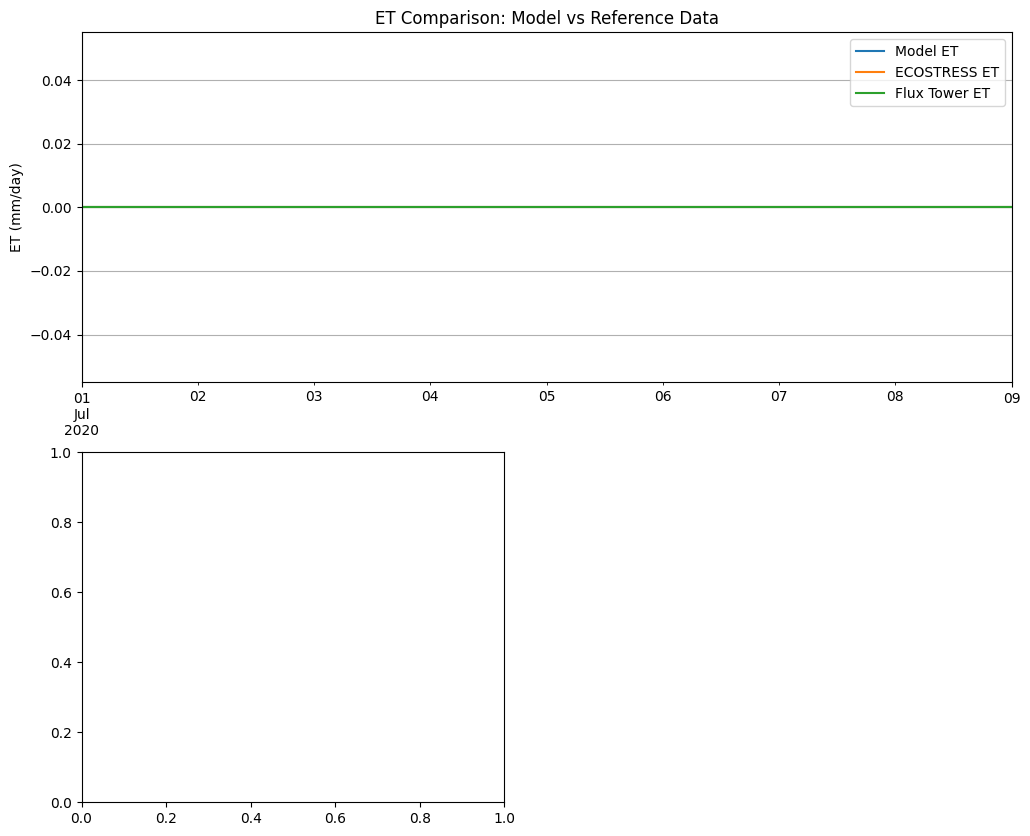

In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib.gridspec import GridSpec

def create_enhanced_dashboard():
    """Create an enhanced ET dashboard with accuracy analysis plots"""

    # Create output areas
    output = widgets.Output(layout=widgets.Layout(height='10px', border='1px solid gray'))
    plot_output = widgets.Output(layout=widgets.Layout(height='40px', border='1px solid blue'))
    accuracy_output = widgets.Output(layout=widgets.Layout(height='40px', border='1px solid purple'))

    # Status indicator
    status = widgets.HTML("<h3>Status: Ready</h3>")

    # Create input fields with default values
    region_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ])

    point_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 2: Select Point</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ])
    ])

    # Add validation data input
    validation_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 3: Validation Settings</h3>"),
        widgets.Checkbox(value=True, description='Compare with ECOSTRESS ET', layout=widgets.Layout(width='300px')),
        widgets.Checkbox(value=True, description='Compare with Flux Tower data', layout=widgets.Layout(width='300px')),
        widgets.Dropdown(
            options=['R²', 'RMSE', 'ME (Mean Error)', 'MAE (Mean Abs Error)', 'All Metrics'],
            value='All Metrics',
            description='Metrics:',
            layout=widgets.Layout(width='300px')
        )
    ])

    # Visualization options
    viz_options = widgets.VBox([
        widgets.HTML("<h3>Analysis Options</h3>"),
        widgets.Dropdown(
            options=['Daily Total ET', 'Hourly ET Components', 'Diurnal Cycle', 'Monthly Average', 'Energy Balance'],
            value='Daily Total ET',
            description='Plot type:',
            layout=widgets.Layout(width='30px')
        ),
        widgets.Dropdown(
            options=['Time Series', 'Scatter Plot', 'Box Plot', 'Histogram'],
            value='Time Series',
            description='Chart type:',
            layout=widgets.Layout(width='300px')
        )
    ])

    # Create buttons
    calc_region_button = widgets.Button(
        description="CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='300px', height='40px')
    )

    calc_ts_button = widgets.Button(
        description="GET TIME SERIES",
        button_style='success',
        layout=widgets.Layout(width='300px', height='40px'),
        disabled=True
    )

    validation_button = widgets.Button(
        description="VALIDATE MODEL",
        button_style='info',
        layout=widgets.Layout(width='300px', height='40px'),
        disabled=True
    )

    # Create a map
    map_output = widgets.Output(layout=widgets.Layout(height='40px', border='1px solid green'))
    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Store state
    state = {
        'model': None,
        'region': None,
        'et_collection': None,
        'model_class': None,
        'start_date': '2020-07-01',
        'end_date': '2020-07-10',
        'map_widget': map_widget,
        'time_series': None,
        'validation_data': None
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Calculate region ET
    def on_calc_region_click(b):
        with output:
            output.clear_output()
            log("Starting region ET calculation...")

            status.value = "<h3 style='color:orange'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing region layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                state['et_collection'] = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Display ET for first date
                try:
                    first_date = state['start_date']
                    log(f"Creating ET map for {first_date}...")
                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    vis_params = {
                        'min': 0, 'max': 8,
                        'palette': ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
                    }
                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')
                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")

                # Update status and enable time series button
                status.value = "<h3 style='color:green'>Status: Region ET calculation complete!</h3>"
                calc_ts_button.disabled = False

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='color:red'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Calculate time series
    def on_calc_ts_click(b):
        if state['model'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            log("Starting time series calculation...")

            status.value = "<h3 style='color:orange'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Point: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(point, {'color': 'blue'}, 'Selected Point')
                except Exception as e:
                    log(f"Warning: Could not display point: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='color:red'>Status: No data available</h3>"
                    return

                state['time_series'] = time_series
                log(f"Time series extracted with {len(time_series)} data points")

                # Generate plots based on selected options
                create_time_series_plots(plot_output, time_series, viz_options)

                # Simulate getting validation data (would normally be fetched from actual source)
                generate_mock_validation_data(point, time_series)

                # Enable validation button
                validation_button.disabled = False

                # Update status
                status.value = "<h3 style='color:green'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='color:red'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Simulate getting validation data
    def generate_mock_validation_data(point, time_series):
        try:
            # Create a synthetic validation dataset by adding some random noise to our ET data
            if 'ET_final' in time_series.columns:
                # Convert to daily values first
                daily_et = time_series['ET_final'].resample('D').sum()

                # Create ECOSTRESS-like data (with some random noise and gaps)
                ecostress_dates = daily_et.index
                ecostress_values = daily_et.values * (0.9 + 0.2 * np.random.random(len(daily_et)))
                ecostress_df = pd.DataFrame({'date': ecostress_dates, 'ET_ecostress': ecostress_values})
                ecostress_df.set_index('date', inplace=True)

                # Create flux tower-like data (with different random noise)
                tower_dates = daily_et.index
                tower_values = daily_et.values * (0.95 + 0.15 * np.random.random(len(daily_et)))
                tower_df = pd.DataFrame({'date': tower_dates, 'ET_tower': tower_values})
                tower_df.set_index('date', inplace=True)

                # Combine into a validation dataset
                validation = pd.concat([daily_et, ecostress_df, tower_df], axis=1)
                validation.columns = ['ET_model', 'ET_ecostress', 'ET_tower']

                # Store in state
                state['validation_data'] = validation
                log("Validation data ready for comparison")
            else:
                log("Could not generate validation data: ET_final column not found in time series")
        except Exception as e:
            log(f"Error generating validation data: {e}")

    # Create time series plots based on selected options
    def create_time_series_plots(output_widget, time_series, viz_options):
        with output_widget:
            output_widget.clear_output()

            try:
                # Get selected visualization options
                plot_type = viz_options.children[1].value
                chart_type = viz_options.children[2].value

                if 'ET_final' in time_series.columns:
                    # Resample to daily values (for certain plot types)
                    daily_et = time_series['ET_final'].resample('D').sum()

                    # Create figure with GridSpec for flexible layout
                    fig = plt.figure(figsize=(12, 8))
                    gs = GridSpec(2, 2, figure=fig)

                    if plot_type == 'Daily Total ET':
                        # Time series of daily ET
                        ax1 = fig.add_subplot(gs[0, :])
                        daily_et.plot(ax=ax1, color='green', marker='o', label='Model ET')
                        ax1.set_title('Daily Total ET')
                        ax1.set_ylabel('ET (mm/day)')
                        ax1.grid(True)

                        # Cumulative ET
                        ax2 = fig.add_subplot(gs[1, 0])
                        daily_et.cumsum().plot(ax=ax2, color='blue')
                        ax2.set_title('Cumulative ET')
                        ax2.set_ylabel('Cumulative ET (mm)')
                        ax2.grid(True)

                        # Histogram of daily ET
                        ax3 = fig.add_subplot(gs[1, 1])
                        daily_et.plot.hist(ax=ax3, bins=10, color='skyblue', edgecolor='black')
                        ax3.set_title('Distribution of Daily ET')
                        ax3.set_xlabel('ET (mm/day)')
                        ax3.set_ylabel('Frequency')
                        ax3.grid(True)

                    elif plot_type == 'Hourly ET Components':
                        # Filter hourly data for components (if available)
                        components_to_plot = [col for col in time_series.columns if 'ET_' in col]

                        if len(components_to_plot) > 1:
                            # Components time series
                            ax1 = fig.add_subplot(gs[0, :])
                            time_series[components_to_plot].plot(ax=ax1)
                            ax1.set_title('ET Components')
                            ax1.set_ylabel('ET (mm/hour)')
                            ax1.grid(True)

                            # Stacked components daily pattern
                            ax2 = fig.add_subplot(gs[1, :])
                            # Group by hour and calculate mean
                            hourly_avg = time_series[components_to_plot].groupby(time_series.index.hour).mean()
                            hourly_avg.plot.area(ax=ax2, stacked=True, alpha=0.7)
                            ax2.set_title('Average Diurnal ET Components')
                            ax2.set_xlabel('Hour of Day')
                            ax2.set_ylabel('ET (mm/hour)')
                            ax2.set_xticks(range(0, 24, 2))
                            ax2.grid(True)
                        else:
                            # Just daily cycle for single component
                            ax1 = fig.add_subplot(gs[:, :])
                            time_series['ET_final'].groupby(time_series.index.hour).mean().plot(
                                ax=ax1, kind='bar', color='skyblue'
                            )
                            ax1.set_title('Average Diurnal ET Pattern')
                            ax1.set_xlabel('Hour of Day')
                            ax1.set_ylabel('ET (mm/hour)')
                            ax1.grid(True)

                    elif plot_type == 'Energy Balance':
                        # Plot energy balance components if available
                        energy_components = [col for col in time_series.columns
                                            if any(term in col for term in ['Rn', 'G', 'H', 'LE'])]

                        if energy_components:
                            # Energy balance time series
                            ax1 = fig.add_subplot(gs[0, :])
                            time_series[energy_components].plot(ax=ax1)
                            ax1.set_title('Surface Energy Balance Components')
                            ax1.set_ylabel('Energy Flux (W/m²)')
                            ax1.grid(True)

                            # Daily average energy balance
                            ax2 = fig.add_subplot(gs[1, 0])
                            daily_avg = time_series[energy_components].resample('D').mean()
                            daily_avg.plot.bar(ax=ax2, stacked=True)
                            ax2.set_title('Daily Average Energy Balance')
                            ax2.set_ylabel('Energy Flux (W/m²)')
                            plt.xticks(rotation=45)
                            ax2.grid(True)

                            # Energy balance closure scatter plot
                            if 'Rn' in time_series.columns and 'G' in time_series.columns and \
                               'H' in time_series.columns and 'LE' in time_series.columns:
                                ax3 = fig.add_subplot(gs[1, 1])
                                available = time_series[['Rn', 'G', 'H', 'LE']].dropna()
                                x = available['Rn'] - available['G']
                                y = available['H'] + available['LE']
                                ax3.scatter(x, y, alpha=0.5)

                                # Add 1:1 line
                                max_val = max(x.max(), y.max())
                                ax3.plot([0, max_val], [0, max_val], 'r--')

                                # Add regression line
                                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                                ax3.plot(x, intercept + slope*x, 'g-',
                                         label=f'Regression: y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')

                                ax3.set_title('Energy Balance Closure')
                                ax3.set_xlabel('Available Energy (Rn-G) (W/m²)')
                                ax3.set_ylabel('Turbulent Fluxes (H+LE) (W/m²)')
                                ax3.legend()
                                ax3.grid(True)
                        else:
                            # If no energy balance components are available
                            ax = fig.add_subplot(gs[:, :])
                            ax.text(0.5, 0.5, 'Energy balance components not available in data',
                                   ha='center', va='center', fontsize=14)
                            ax.set_axis_off()

                    else:  # Monthly or other time periods
                        # Create monthly average plot
                        ax1 = fig.add_subplot(gs[0, :])
                        monthly_et = daily_et.resample('M').sum()
                        monthly_et.plot(ax=ax1, kind='bar', color='green')
                        ax1.set_title('Monthly Total ET')
                        ax1.set_ylabel('ET (mm/month)')
                        plt.xticks(rotation=45)
                        ax1.grid(True)

                        # Create seasonal pattern
                        ax2 = fig.add_subplot(gs[1, :])
                        if len(daily_et) >= 30:  # Need enough data for this analysis
                            # Use rolling average to show seasonal pattern
                            daily_et.rolling(window=7).mean().plot(ax=ax2, color='blue')
                            ax2.set_title('7-Day Moving Average ET')
                            ax2.set_ylabel('ET (mm/day)')
                            ax2.grid(True)
                        else:
                            # Small dataset - show daily values with trend
                            daily_et.plot(ax=ax2, marker='o', linestyle='-', color='blue')

                            # Add trend line
                            z = np.polyfit(range(len(daily_et)), daily_et.values, 1)
                            p = np.poly1d(z)
                            ax2.plot(daily_et.index, p(range(len(daily_et))), "r--",
                                    label=f'Trend: {z[0]:.3f} mm/day')
                            ax2.legend()
                            ax2.set_title('Daily ET with Trend')
                            ax2.set_ylabel('ET (mm/day)')
                            ax2.grid(True)

                else:
                    # If ET_final not available, show whatever data we have
                    fig, ax = plt.subplots(figsize=(12, 6))
                    time_series.plot(ax=ax)
                    ax.set_title('Available Time Series Data')
                    ax.grid(True)

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error creating plots: {e}")
                import traceback
                traceback.print_exc()

    # Validate model against reference data
    def on_validate_model_click(b):
        with output:
            log("Starting model validation...")

            status.value = "<h3 style='color:orange'>Status: Calculating accuracy metrics...</h3>"

            if state['validation_data'] is None:
                log("Error: No validation data available")
                status.value = "<h3 style='color:red'>Status: No validation data available</h3>"
                return

            try:
                validation_data = state['validation_data']
                selected_metrics = validation_inputs.children[3].value

                with accuracy_output:
                    accuracy_output.clear_output()

                    # Create validation plots with model vs reference data
                    fig = plt.figure(figsize=(12, 10))
                    gs = GridSpec(2, 2, figure=fig)

                    # Time series comparison
                    ax1 = fig.add_subplot(gs[0, :])
                    validation_data.plot(ax=ax1)
                    ax1.set_title('ET Comparison: Model vs Reference Data')
                    ax1.set_ylabel('ET (mm/day)')
                    ax1.grid(True)
                    ax1.legend(['Model ET', 'ECOSTRESS ET', 'Flux Tower ET'])

                    # Scatter plot for ECOSTRESS
                    ax2 = fig.add_subplot(gs[1, 0])
                    x = validation_data['ET_model'].values
                    y = validation_data['ET_ecostress'].values

                    # Calculate metrics
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                    rmse = np.sqrt(np.mean((y - x) ** 2))
                    me = np.mean(y - x)
                    mae = np.mean(np.abs(y - x))

                    # Plot scatter
                    ax2.scatter(x, y, alpha=0.7)

                    # Add 1:1 line
                    max_val = max(np.max(x), np.max(y))
                    ax2.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')

                    # Add regression line
                    ax2.plot(x, intercept + slope*x, 'g-',
                             label=f'y = {slope:.2f}x + {intercept:.2f}')

                    # Add metrics text box
                    textstr = f'R² = {r_value**2:.3f}\nRMSE = {rmse:.2f} mm/day\nME = {me:.2f} mm/day\nMAE = {mae:.2f} mm/day'
                    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
                    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
                            verticalalignment='top', bbox=props)

                    ax2.set_title('Model vs ECOSTRESS ET')
                    ax2.set_xlabel('Model ET (mm/day)')
                    ax2.set_ylabel('ECOSTRESS ET (mm/day)')
                    ax2.legend()
                    ax2.grid(True)

                    # Scatter plot for Flux Tower
                    ax3 = fig.add_subplot(gs[1, 1])
                    x = validation_data['ET_model'].values
                    y = validation_data['ET_tower'].values

                    # Calculate metrics
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                    rmse = np.sqrt(np.mean((y - x) ** 2))
                    me = np.mean(y - x)
                    mae = np.mean(np.abs(y - x))

                    # Plot scatter
                    ax3.scatter(x, y, alpha=0.7)

                    # Add 1:1 line
                    max_val = max(np.max(x), np.max(y))
                    ax3.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')

                    # Add regression line
                    ax3.plot(x, intercept + slope*x, 'g-',
                             label=f'y = {slope:.2f}x + {intercept:.2f}')

                    # Add metrics text box
                    textstr = f'R² = {r_value**2:.3f}\nRMSE = {rmse:.2f} mm/day\nME = {me:.2f} mm/day\nMAE = {mae:.2f} mm/day'
                    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
                    ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
                            verticalalignment='top', bbox=props)

                    ax3.set_title('Model vs Flux Tower ET')
                    ax3.set_xlabel('Model ET (mm/day)')
                    ax3.set_ylabel('Flux Tower ET (mm/day)')
                    ax3.legend()
                    ax3.grid(True)

                    plt.tight_layout()
                    plt.show()

                    # If requested, show table of metrics for all validation datasets
                    if selected_metrics == 'All Metrics':
                        # Create a summary table of metrics
                        print("\nSummary of Model Accuracy Metrics:")
                        print("=" * 60)
                        metrics_df = pd.DataFrame(
                            index=['vs ECOSTRESS', 'vs Flux Tower'],
                            columns=['R²', 'RMSE (mm/day)', 'ME (mm/day)', 'MAE (mm/day)']
                        )

                        # Calculate metrics for ECOSTRESS
                        x = validation_data['ET_model'].values
                        y = validation_data['ET_ecostress'].values
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                        metrics_df.loc['vs ECOSTRESS', 'R²'] = r_value**2
                        metrics_df.loc['vs ECOSTRESS', 'RMSE (mm/day)'] = np.sqrt(np.mean((y - x) ** 2))
                        metrics_df.loc['vs ECOSTRESS', 'ME (mm/day)'] = np.mean(y - x)
                        metrics_df.loc['vs ECOSTRESS', 'MAE (mm/day)'] = np.mean(np.abs(y - x))

                        # Calculate metrics for Flux Tower
                        x = validation_data['ET_model'].values
                        y = validation_data['ET_tower'].values
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                        metrics_df.loc['vs Flux Tower', 'R²'] = r_value**2
                        metrics_df.loc['vs Flux Tower', 'RMSE (mm/day)'] = np.sqrt(np.mean((y - x) ** 2))
                        metrics_df.loc['vs Flux Tower', 'ME (mm/day)'] = np.mean(y - x)
                        metrics_df.loc['vs Flux Tower', 'MAE (mm/day)'] = np.mean(np.abs(y - x))

                        display(metrics_df.round(3))

                status.value = "<h3 style='color:green'>Status: Validation complete!</h3>"
                log("Model validation complete")

            except Exception as e:
                log(f"Error during validation: {e}")
                status.value = f"<h3 style='color:red'>Status: Validation error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Connect button handlers
    calc_region_button.on_click(on_calc_region_click)
    calc_ts_button.on_click(on_calc_ts_click)
    validation_button.on_click(on_validate_model_click)

    # Create button containers with labels
    buttons_container = widgets.VBox([
        widgets.HTML("<p><b>Click buttons in sequence:</b></p>"),
        calc_region_button,
        calc_ts_button,
        validation_button
    ])

    # Create tabs for the plots
    plot_tabs = widgets.Tab([plot_output, accuracy_output])
    plot_tabs.set_title(0, 'Time Series Analysis')
    plot_tabs.set_title(1, 'Model Accuracy')

    # Create main layout - organized in panels
    dashboard = widgets.VBox([
        widgets.HTML("<h1>Enhanced ET Dashboard with Model Accuracy Analysis</h1>"),
        status,
        widgets.HBox([
            # Left column - controls
            widgets.VBox([
                region_inputs,
                point_inputs,
                validation_inputs,
                viz_options,
                buttons_container,
                widgets.HTML("<h3>Output Log:</h3>"),
                output
            ], layout=widgets.Layout(width='40%')),

            # Right column - results
            widgets.VBox([
                plot_tabs,
                widgets.HTML("<h3>Map:</h3>"),
                map_output
            ], layout=widgets.Layout(width='60%'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_enhanced_dashboard()

    # Set the model class
    try:
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to {TwoSourceEnergyBalanceModel.__name__}")
    except ImportError:
        # If model not found, try global context
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create a mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation (no real calculation)")
                    return ee.Image(0)  # Dummy image

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    return ee.Image(1)  # Dummy image

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create dummy time series with flux components
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10', freq='H')
                    n = len(dates)

                    # Create sine-like pattern for diurnal cycle
                    hour_factor = np.sin(np.pi * dates.hour / 12) * (dates.hour > 6) * (dates.hour < 18)
                    day_factor = 1 + 0.2 * np.sin(np.pi * np.arange(n) / 72)

                    # Create basic time series components
                    et_values = 0.2 * hour_factor * day_factor
                    et_sun = 0.15 * hour_factor * day_factor
                    et_shade = 0.05 * hour_factor * day_factor

                    # Energy balance components
                    rn = 600 * hour_factor * day_factor  # Net radiation
                    g = 100 * hour_factor * day_factor   # Ground heat flux
                    h = 200 * hour_factor * day_factor   # Sensible heat
                    le = 300 * hour_factor * day_factor  # Latent heat

                    # Create DataFrame
                    df = pd.DataFrame({
                        'ET_final': et_values,
                        'ET_sun': et_sun,
                        'ET_shade': et_shade,
                        'Rn': rn,
                        'G': g,
                        'H': h,
                        'LE': le
                    }, index=dates)

                    return df

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()

Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed


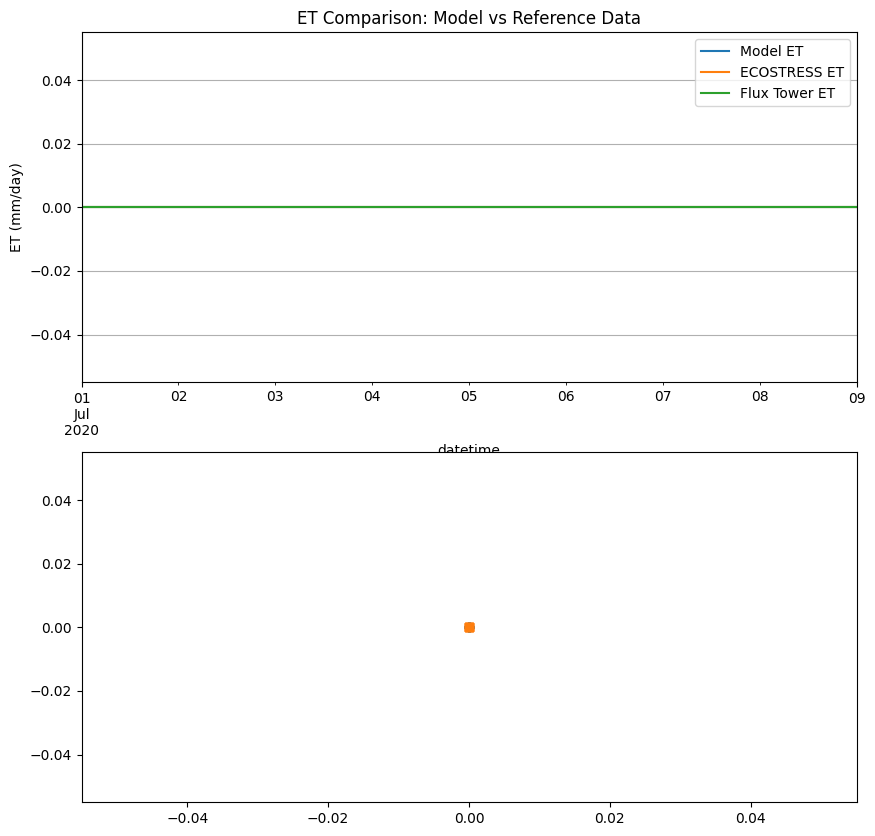

In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, clear_output
from datetime import datetime
import seaborn as sns

def create_fixed_dashboard():
    """Create a dashboard with reliable plot display"""

    # Create simple outputs with direct display
    output = widgets.Output(layout=widgets.Layout(height='200px', border='1px solid gray'))
    status = widgets.HTML("<h3>Status: Ready</h3>")

    # Create a fixed plot area that will directly display plots without tab container
    time_series_plot = widgets.Output(layout=widgets.Layout(height='400px', border='1px solid blue'))
    validation_plot = widgets.Output(layout=widgets.Layout(height='400px', border='1px solid purple'))

    # Create layout for map
    map_output = widgets.Output(layout=widgets.Layout(height='400px', border='1px solid green'))
    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Create input fields with default values
    region_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ])

    point_inputs = widgets.VBox([
        widgets.HTML("<h3>Step 2: Select Point</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ])
    ])

    # Create big, clearly visible buttons
    calc_region_button = widgets.Button(
        description="1. CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='300px', height='40px')
    )

    calc_ts_button = widgets.Button(
        description="2. GET TIME SERIES",
        button_style='success',
        layout=widgets.Layout(width='300px', height='40px'),
        disabled=True
    )

    validate_button = widgets.Button(
        description="3. VALIDATE MODEL",
        button_style='info',
        layout=widgets.Layout(width='300px', height='40px'),
        disabled=True
    )

    # Visualization options
    viz_dropdown = widgets.Dropdown(
        options=['Daily ET', 'Hourly Components', 'Energy Balance', 'Diurnal Pattern'],
        value='Daily ET',
        description='Plot type:',
        layout=widgets.Layout(width='250px')
    )

    # Store state
    state = {
        'model': None,
        'region': None,
        'time_series': None,
        'validation_data': None,
        'map_widget': map_widget,
        'model_class': None,
        'start_date': '2020-07-01',
        'end_date': '2020-07-10'
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Calculate region ET
    def on_calc_region_click(b):
        with output:
            clear_output()
            log("Starting region ET calculation...")

            status.value = "<h3 style='color:orange'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear previous layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                et_collection = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Try to display ET for first date
                try:
                    first_date = state['start_date']
                    log(f"Creating ET map for {first_date}...")
                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    vis_params = {
                        'min': 0, 'max': 8,
                        'palette': ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
                    }
                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')
                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")

                # Update status and enable time series button
                status.value = "<h3 style='color:green'>Status: Region ET calculation complete!</h3>"
                calc_ts_button.disabled = False

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='color:red'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Calculate time series
    def on_calc_ts_click(b):
        if state['model'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Starting time series calculation...")

            status.value = "<h3 style='color:orange'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Point: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(point, {'color': 'blue'}, 'Selected Point')
                except Exception as e:
                    log(f"Warning: Could not display point: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='color:red'>Status: No data available</h3>"
                    return

                state['time_series'] = time_series
                log(f"Time series extracted with {len(time_series)} data points")

                # Generate mock validation data
                create_mock_validation_data(time_series)

                # Plot the time series - EXPLICITLY CLEARING AND DISPLAYING
                with time_series_plot:
                    clear_output(wait=True)
                    create_plots(time_series, viz_dropdown.value)

                # Enable validation button
                validate_button.disabled = False

                # Update status
                status.value = "<h3 style='color:green'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='color:red'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Create mock validation data
    def create_mock_validation_data(time_series):
        try:
            if 'ET_final' in time_series.columns:
                # Convert to daily values
                daily_et = time_series['ET_final'].resample('D').sum()

                # Create mock ECOSTRESS data
                ecostress_values = daily_et.values * (0.9 + 0.2 * np.random.random(len(daily_et)))
                ecostress_df = pd.DataFrame({'ET_ecostress': ecostress_values}, index=daily_et.index)

                # Create mock flux tower data
                tower_values = daily_et.values * (0.95 + 0.15 * np.random.random(len(daily_et)))
                tower_df = pd.DataFrame({'ET_tower': tower_values}, index=daily_et.index)

                # Combine data
                validation = pd.concat([
                    pd.DataFrame({'ET_model': daily_et.values}, index=daily_et.index),
                    ecostress_df,
                    tower_df
                ], axis=1)

                state['validation_data'] = validation
                log("Validation data ready for comparison")
            else:
                log("Could not create validation data: ET_final column not found")
        except Exception as e:
            log(f"Error creating validation data: {e}")

    # Create time series plots
    def create_plots(time_series, plot_type):
        try:
            if plot_type == 'Daily ET':
                if 'ET_final' in time_series.columns:
                    # Convert to daily values
                    daily_et = time_series['ET_final'].resample('D').sum()

                    # Create plot
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

                    # Daily ET time series
                    daily_et.plot(ax=ax1, marker='o', color='green')
                    ax1.set_title('Daily ET')
                    ax1.set_ylabel('ET (mm/day)')
                    ax1.grid(True)

                    # Cumulative ET
                    daily_et.cumsum().plot(ax=ax2, color='blue')
                    ax2.set_title('Cumulative ET')
                    ax2.set_ylabel('Cumulative ET (mm)')
                    ax2.grid(True)

                    plt.tight_layout()
                    plt.show()

                else:
                    plt.figure(figsize=(10, 6))
                    plt.text(0.5, 0.5, 'ET_final data not available',
                            ha='center', va='center', fontsize=14)
                    plt.axis('off')
                    plt.show()

            elif plot_type == 'Hourly Components':
                components = [col for col in time_series.columns if col.startswith('ET_')]

                if len(components) > 1:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

                    # Component time series (first day only for clarity)
                    first_day = time_series.iloc[:24][components]
                    first_day.plot(ax=ax1)
                    ax1.set_title('ET Components (First Day)')
                    ax1.set_ylabel('ET (mm/hour)')
                    ax1.grid(True)

                    # Diurnal pattern
                    hourly_avg = time_series[components].groupby(time_series.index.hour).mean()
                    hourly_avg.plot(ax=ax2, marker='o')
                    ax2.set_title('Average Diurnal ET Pattern')
                    ax2.set_xlabel('Hour of Day')
                    ax2.set_ylabel('ET (mm/hour)')
                    ax2.grid(True)

                    plt.tight_layout()
                    plt.show()
                else:
                    plt.figure(figsize=(10, 6))
                    plt.text(0.5, 0.5, 'ET component data not available',
                            ha='center', va='center', fontsize=14)
                    plt.axis('off')
                    plt.show()

            elif plot_type == 'Energy Balance':
                energy_components = [col for col in time_series.columns
                                    if col in ['Rn', 'G', 'H', 'LE']]

                if len(energy_components) > 2:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

                    # Energy balance components
                    first_day = time_series.iloc[:24][energy_components]
                    first_day.plot(ax=ax1)
                    ax1.set_title('Energy Balance Components (First Day)')
                    ax1.set_ylabel('Energy Flux (W/m²)')
                    ax1.grid(True)

                    # Energy balance closure
                    if all(comp in time_series.columns for comp in ['Rn', 'G', 'H', 'LE']):
                        available = time_series[['Rn', 'G', 'H', 'LE']].dropna()
                        x = available['Rn'] - available['G']
                        y = available['H'] + available['LE']

                        ax2.scatter(x, y, alpha=0.5)

                        # Add 1:1 line
                        max_val = max(x.max(), y.max())
                        ax2.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')

                        # Add regression line
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                        ax2.plot(x, intercept + slope*x, 'g-',
                                label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_value**2:.2f}')

                        ax2.set_title('Energy Balance Closure')
                        ax2.set_xlabel('Available Energy (Rn-G) (W/m²)')
                        ax2.set_ylabel('Turbulent Fluxes (H+LE) (W/m²)')
                        ax2.legend()
                        ax2.grid(True)

                    plt.tight_layout()
                    plt.show()
                else:
                    plt.figure(figsize=(10, 6))
                    plt.text(0.5, 0.5, 'Energy balance data not available',
                            ha='center', va='center', fontsize=14)
                    plt.axis('off')
                    plt.show()

            else:  # Diurnal Pattern
                if 'ET_final' in time_series.columns:
                    fig, ax = plt.subplots(figsize=(10, 6))

                    # Group by hour and calculate mean
                    hourly_avg = time_series['ET_final'].groupby(time_series.index.hour).mean()

                    # Plot as bar chart
                    hourly_avg.plot(kind='bar', ax=ax, color='skyblue')
                    ax.set_title('Average Diurnal ET Pattern')
                    ax.set_xlabel('Hour of Day')
                    ax.set_ylabel('ET (mm/hour)')
                    ax.grid(True)

                    plt.tight_layout()
                    plt.show()
                else:
                    plt.figure(figsize=(10, 6))
                    plt.text(0.5, 0.5, 'ET data not available for diurnal pattern',
                            ha='center', va='center', fontsize=14)
                    plt.axis('off')
                    plt.show()

        except Exception as e:
            plt.figure(figsize=(10, 6))
            plt.text(0.5, 0.5, f'Error creating plots: {str(e)}',
                    ha='center', va='center', fontsize=14, color='red')
            plt.axis('off')
            plt.show()

            import traceback
            traceback.print_exc()

    # Validate model
    def on_validate_click(b):
        if state['validation_data'] is None:
            log("Error: No validation data available")
            return

        with output:
            clear_output()
            log("Starting model validation...")

            status.value = "<h3 style='color:orange'>Status: Validating model...</h3>"

            try:
                validation_data = state['validation_data']

                # EXPLICIT PLOT CREATION WITH CLEAR_OUTPUT
                with validation_plot:
                    clear_output(wait=True)

                    # Create validation plots
                    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

                    # Time series comparison
                    validation_data.plot(ax=axes[0])
                    axes[0].set_title('ET Comparison: Model vs Reference Data')
                    axes[0].set_ylabel('ET (mm/day)')
                    axes[0].legend(['Model ET', 'ECOSTRESS ET', 'Flux Tower ET'])
                    axes[0].grid(True)

                    # Scatter plots
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_ecostress'],
                                  label='vs ECOSTRESS', alpha=0.7)
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_tower'],
                                  label='vs Flux Tower', alpha=0.7, marker='s')

                    # Add 1:1 line
                    max_val = validation_data.max().max()
                    axes[1].plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')

                    # Calculate metrics
                    ecostress_r2 = stats.linregress(validation_data['ET_model'],
                                                  validation_data['ET_ecostress']).rvalue**2
                    tower_r2 = stats.linregress(validation_data['ET_model'],
                                              validation_data['ET_tower']).rvalue**2

                    # Add metrics to legend
                    axes[1].set_title('Model Performance')
                    axes[1].set_xlabel('Model ET (mm/day)')
                    axes[1].set_ylabel('Reference ET (mm/day)')
                    axes[1].legend([f'ECOSTRESS (R²={ecostress_r2:.2f})',
                                  f'Flux Tower (R²={tower_r2:.2f})',
                                  '1:1 Line'])
                    axes[1].grid(True)

                    plt.tight_layout()
                    plt.show()

                    # Display metrics table
                    print("\nModel Validation Metrics:")
                    print("=" * 50)

                    metrics = []
                    for ref_name, ref_col in [('ECOSTRESS', 'ET_ecostress'), ('Flux Tower', 'ET_tower')]:
                        x = validation_data['ET_model']
                        y = validation_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)
                        mae = np.mean(np.abs(y - x))

                        metrics.append({
                            'Reference': ref_name,
                            'R²': r**2,
                            'RMSE (mm/day)': rmse,
                            'Bias (mm/day)': bias,
                            'MAE (mm/day)': mae
                        })

                    # Create and display DataFrame
                    metrics_df = pd.DataFrame(metrics).set_index('Reference')
                    display(metrics_df.round(3))

                status.value = "<h3 style='color:green'>Status: Validation complete!</h3>"
                log("Model validation complete")

            except Exception as e:
                log(f"Error during validation: {e}")
                status.value = f"<h3 style='color:red'>Status: Validation error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Update plot when dropdown changes
    def on_viz_change(change):
        if state['time_series'] is not None:
            with time_series_plot:
                clear_output(wait=True)
                create_plots(state['time_series'], change.new)

    # Connect handlers
    calc_region_button.on_click(on_calc_region_click)
    calc_ts_button.on_click(on_calc_ts_click)
    validate_button.on_click(on_validate_click)
    viz_dropdown.observe(on_viz_change, names='value')

    # Create layout
    dashboard = widgets.VBox([
        widgets.HTML("<h1>Enhanced ET Dashboard with Model Validation</h1>"),
        status,

        # Two-column layout
        widgets.HBox([
            # Left column - controls
            widgets.VBox([
                region_inputs,
                point_inputs,
                widgets.HTML("<h3>Visualization Options</h3>"),
                viz_dropdown,
                widgets.HTML("<h3>Actions</h3>"),
                calc_region_button,
                calc_ts_button,
                validate_button,
                widgets.HTML("<h3>Output Log</h3>"),
                output
            ], layout=widgets.Layout(width='40%')),

            # Right column - results (PLOTS FIRST, THEN MAP)
            widgets.VBox([
                widgets.HTML("<h2>Time Series Analysis</h2>"),
                time_series_plot,
                widgets.HTML("<h2>Model Validation</h2>"),
                validation_plot,
                widgets.HTML("<h2>Map</h2>"),
                map_output
            ], layout=widgets.Layout(width='60%'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_fixed_dashboard()

    # Set the model class
    try:
        # Try to import
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to TwoSourceEnergyBalanceModel")
    except ImportError:
        # Check if it's in globals
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation")
                    return ee.Image(0)

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    return ee.Image(1)

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create test data with hourly timestep
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10', freq='H')
                    n = len(dates)

                    # Create diurnal pattern
                    hours = dates.hour.values
                    day_of_year = dates.dayofyear.values - dates[0].dayofyear

                    # ET with diurnal and daily patterns
                    et_pattern = np.sin(np.pi * hours / 12) * (hours >= 6) * (hours <= 18)
                    et_pattern = et_pattern * (1 + 0.2 * np.sin(2 * np.pi * day_of_year / 10))

                    # Components
                    et_final = 0.3 * et_pattern
                    et_sun = 0.2 * et_pattern
                    et_shade = 0.1 * et_pattern

                    # Energy balance components
                    rn = 700 * et_pattern
                    g = 100 * et_pattern
                    h = 300 * et_pattern
                    le = 300 * et_pattern

                    return pd.DataFrame({
                        'ET_final': et_final,
                        'ET_sun': et_sun,
                        'ET_shade': et_shade,
                        'Rn': rn,
                        'G': g,
                        'H': h,
                        'LE': le
                    }, index=dates)

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()

In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, clear_output
from datetime import datetime
import seaborn as sns

def create_enhanced_dashboard():
    """Create a dashboard with clear visual separation between components"""

    # Create simple output with styling
    output = widgets.Output(
        layout=widgets.Layout(
            height='200px',
            border='2px solid gray',
            margin='10px',
            padding='5px'
        )
    )

    # Status with styling
    status = widgets.HTML(
        "<h3 style='background-color:#f8f8f8; padding:10px; border-radius:5px;'>Status: Ready</h3>"
    )

    # Create styled plot areas - NOTICE THE HEIGHT DIFFERENCES
    time_series_plot = widgets.Output(
        layout=widgets.Layout(
            height='500px',  # TALLER for more prominence
            border='3px solid #3498db',
            margin='15px',
            padding='10px',
            background_color='#f0f8ff'  # Light blue background
        )
    )

    validation_plot = widgets.Output(
        layout=widgets.Layout(
            height='500px',  # TALLER for more prominence
            border='3px solid #9b59b6',  # Purple border
            margin='15px',
            padding='10px',
            background_color='#f5f0ff'  # Light purple background
        )
    )

    # Create smaller map output with distinctive styling
    map_output = widgets.Output(
        layout=widgets.Layout(
            height='300px',  # SHORTER than plots
            border='3px solid #2ecc71',  # Green border
            margin='15px',
            padding='10px',
            background_color='#f0fff0'  # Light green background
        )
    )

    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Create input fields with styling
    region_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    point_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 2: Select Point</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ])
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Create large, clearly visible buttons
    calc_region_button = widgets.Button(
        description="1. CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='320px', height='50px')  # BIGGER
    )

    calc_ts_button = widgets.Button(
        description="2. GET TIME SERIES",
        button_style='success',
        layout=widgets.Layout(width='320px', height='50px'),  # BIGGER
        disabled=True
    )

    validate_button = widgets.Button(
        description="3. VALIDATE MODEL",
        button_style='info',
        layout=widgets.Layout(width='320px', height='50px'),  # BIGGER
        disabled=True
    )

    # Visualization options with styling
    viz_dropdown = widgets.Dropdown(
        options=['Daily ET', 'Hourly Components', 'Energy Balance', 'Diurnal Pattern'],
        value='Daily ET',
        description='Plot type:',
        layout=widgets.Layout(width='300px')
    )

    # Store state
    state = {
        'model': None,
        'region': None,
        'time_series': None,
        'validation_data': None,
        'map_widget': map_widget,
        'model_class': None,
        'start_date': '2020-07-01',
        'end_date': '2020-07-10'
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Calculate region ET
    def on_calc_region_click(b):
        with output:
            clear_output()
            log("Starting region ET calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear previous layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                et_collection = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Try to display ET for first date
                try:
                    first_date = state['start_date']
                    log(f"Creating ET map for {first_date}...")
                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    vis_params = {
                        'min': 0, 'max': 8,
                        'palette': ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
                    }
                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')
                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")

                # Update status and enable time series button
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Region ET calculation complete!</h3>"
                calc_ts_button.disabled = False

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Calculate time series
    def on_calc_ts_click(b):
        if state['model'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Starting time series calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Point: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(point, {'color': 'blue'}, 'Selected Point')
                except Exception as e:
                    log(f"Warning: Could not display point: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: No data available</h3>"
                    return

                state['time_series'] = time_series
                log(f"Time series extracted with {len(time_series)} data points")

                # Generate mock validation data
                create_mock_validation_data(time_series)

                # Plot the time series - EXPLICITLY CLEARING AND DISPLAYING
                with time_series_plot:
                    clear_output(wait=True)
                    create_plots(time_series, viz_dropdown.value)

                # Enable validation button
                validate_button.disabled = False

                # Update status
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Create mock validation data
    def create_mock_validation_data(time_series):
        try:
            if 'ET_final' in time_series.columns:
                # Convert to daily values
                daily_et = time_series['ET_final'].resample('D').sum()

                # Create mock ECOSTRESS data
                ecostress_values = daily_et.values * (0.9 + 0.2 * np.random.random(len(daily_et)))
                ecostress_df = pd.DataFrame({'ET_ecostress': ecostress_values}, index=daily_et.index)

                # Create mock flux tower data
                tower_values = daily_et.values * (0.95 + 0.15 * np.random.random(len(daily_et)))
                tower_df = pd.DataFrame({'ET_tower': tower_values}, index=daily_et.index)

                # Combine data
                validation = pd.concat([
                    pd.DataFrame({'ET_model': daily_et.values}, index=daily_et.index),
                    ecostress_df,
                    tower_df
                ], axis=1)

                state['validation_data'] = validation
                log("Validation data ready for comparison")
            else:
                log("Could not create validation data: ET_final column not found")
        except Exception as e:
            log(f"Error creating validation data: {e}")

    # Create time series plots
    def create_plots(time_series, plot_type):
        try:
            # Set figure title style with background for clarity
            title_style = dict(fontsize=14, fontweight='bold',
                              bbox=dict(facecolor='#e0f0ff', edgecolor='#3498db', pad=10))

            if plot_type == 'Daily ET':
                if 'ET_final' in time_series.columns:
                    # Convert to daily values
                    daily_et = time_series['ET_final'].resample('D').sum()

                    # Create plot with larger size for visibility
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                    # Daily ET time series
                    daily_et.plot(ax=ax1, marker='o', color='green', linewidth=2, markersize=8)
                    ax1.set_title('Daily Evapotranspiration', **title_style)
                    ax1.set_ylabel('ET (mm/day)', fontsize=12)
                    ax1.tick_params(labelsize=11)
                    ax1.grid(True, linestyle='--', alpha=0.7)

                    # Add shading under curve
                    ax1.fill_between(daily_et.index, 0, daily_et.values, alpha=0.3, color='green')

                    # Cumulative ET
                    daily_et.cumsum().plot(ax=ax2, color='blue', linewidth=2)
                    ax2.set_title('Cumulative Evapotranspiration', **title_style)
                    ax2.set_ylabel('Cumulative ET (mm)', fontsize=12)
                    ax2.tick_params(labelsize=11)
                    ax2.grid(True, linestyle='--', alpha=0.7)

                    # Add shading under curve
                    cumulative = daily_et.cumsum()
                    ax2.fill_between(cumulative.index, 0, cumulative.values, alpha=0.3, color='blue')

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()

                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'ET_final data not available',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

            elif plot_type == 'Hourly Components':
                components = [col for col in time_series.columns if col.startswith('ET_')]

                if len(components) > 1:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                    # Component time series (first day only for clarity)
                    first_day = time_series.iloc[:24][components]
                    first_day.plot(ax=ax1, linewidth=2)
                    ax1.set_title('ET Components (First Day)', **title_style)
                    ax1.set_ylabel('ET (mm/hour)', fontsize=12)
                    ax1.tick_params(labelsize=11)
                    ax1.grid(True, linestyle='--', alpha=0.7)

                    # Diurnal pattern - area plot for better visualization
                    hourly_avg = time_series[components].groupby(time_series.index.hour).mean()
                    hourly_avg.plot.area(ax=ax2, stacked=True, alpha=0.7)
                    ax2.set_title('Average Diurnal ET Pattern by Component', **title_style)
                    ax2.set_xlabel('Hour of Day', fontsize=12)
                    ax2.set_ylabel('ET (mm/hour)', fontsize=12)
                    ax2.set_xticks(range(0, 24, 2))
                    ax2.tick_params(labelsize=11)
                    ax2.grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()
                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'ET component data not available',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

            elif plot_type == 'Energy Balance':
                energy_components = [col for col in time_series.columns
                                    if col in ['Rn', 'G', 'H', 'LE']]

                if len(energy_components) > 2:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                    # Energy balance components
                    first_day = time_series.iloc[:24][energy_components]
                    first_day.plot(ax=ax1, linewidth=2)
                    ax1.set_title('Energy Balance Components (First Day)', **title_style)
                    ax1.set_ylabel('Energy Flux (W/m²)', fontsize=12)
                    ax1.tick_params(labelsize=11)
                    ax1.grid(True, linestyle='--', alpha=0.7)

                    # Energy balance closure
                    if all(comp in time_series.columns for comp in ['Rn', 'G', 'H', 'LE']):
                        available = time_series[['Rn', 'G', 'H', 'LE']].dropna()
                        x = available['Rn'] - available['G']
                        y = available['H'] + available['LE']

                        # Create scatter plot with better styling
                        ax2.scatter(x, y, alpha=0.7, s=50, c='blue', edgecolor='navy')

                        # Add 1:1 line
                        max_val = max(x.max(), y.max())
                        ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='1:1 Line')

                        # Add regression line
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                        ax2.plot(x, intercept + slope*x, 'g-', linewidth=2,
                                label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_value**2:.2f}')

                        ax2.set_title('Energy Balance Closure', **title_style)
                        ax2.set_xlabel('Available Energy (Rn-G) (W/m²)', fontsize=12)
                        ax2.set_ylabel('Turbulent Fluxes (H+LE) (W/m²)', fontsize=12)
                        ax2.tick_params(labelsize=11)
                        ax2.legend(fontsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()
                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'Energy balance data not available',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

            else:  # Diurnal Pattern
                if 'ET_final' in time_series.columns:
                    fig, ax = plt.subplots(figsize=(12, 8))

                    # Group by hour and calculate mean
                    hourly_avg = time_series['ET_final'].groupby(time_series.index.hour).mean()

                    # Plot as bar chart with enhanced styling
                    hourly_avg.plot(kind='bar', ax=ax, color='skyblue', edgecolor='navy', width=0.8)

                    # Add trend line
                    x = np.arange(len(hourly_avg))
                    z = np.polyfit(x, hourly_avg.values, 2)
                    p = np.poly1d(z)
                    ax.plot(x, p(x), 'r--', linewidth=2, label='Trend')

                    ax.set_title('Average Diurnal ET Pattern', **title_style)
                    ax.set_xlabel('Hour of Day', fontsize=12)
                    ax.set_ylabel('ET (mm/hour)', fontsize=12)
                    ax.tick_params(labelsize=11)
                    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
                    ax.legend(fontsize=11)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()
                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'ET data not available for diurnal pattern',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

        except Exception as e:
            plt.figure(figsize=(12, 8))
            plt.text(0.5, 0.5, f'Error creating plots: {str(e)}',
                    ha='center', va='center', fontsize=16, color='red',
                    bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                             boxstyle='round,pad=1'))
            plt.axis('off')
            plt.show()

            import traceback
            traceback.print_exc()

    # Validate model
    def on_validate_click(b):
        if state['validation_data'] is None:
            log("Error: No validation data available")
            return

        with output:
            clear_output()
            log("Starting model validation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Validating model...</h3>"

            try:
                validation_data = state['validation_data']

                # EXPLICIT PLOT CREATION WITH CLEAR_OUTPUT
                with validation_plot:
                    clear_output(wait=True)

                    # Create validation plots with enhanced styling
                    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

                    # Time series comparison
                    validation_data.plot(ax=axes[0], linewidth=2)
                    axes[0].set_title('ET Comparison: Model vs Reference Data',
                                    fontsize=14, fontweight='bold',
                                    bbox=dict(facecolor='#e0e0ff', edgecolor='#9b59b6', pad=10))
                    axes[0].set_ylabel('ET (mm/day)', fontsize=12)
                    axes[0].tick_params(labelsize=11)
                    axes[0].legend(['Model ET', 'ECOSTRESS ET', 'Flux Tower ET'], fontsize=11)
                    axes[0].grid(True, linestyle='--', alpha=0.7)

                    # Scatter plots with styled appearance
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_ecostress'],
                                  label='vs ECOSTRESS', alpha=0.7, s=80, color='#3498db')
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_tower'],
                                  label='vs Flux Tower', alpha=0.7, s=80, marker='s', color='#e74c3c')

                    # Add 1:1 line
                    max_val = validation_data.max().max()
                    axes[1].plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='1:1 Line')

                    # Calculate metrics
                    ecostress_stats = stats.linregress(validation_data['ET_model'],
                                                    validation_data['ET_ecostress'])
                    tower_stats = stats.linregress(validation_data['ET_model'],
                                                 validation_data['ET_tower'])

                    # Add regression lines
                    x_range = np.array([0, max_val])
                    axes[1].plot(x_range, ecostress_stats.intercept + ecostress_stats.slope * x_range,
                               '-', color='#3498db', linewidth=2)
                    axes[1].plot(x_range, tower_stats.intercept + tower_stats.slope * x_range,
                               '-', color='#e74c3c', linewidth=2)

                    # Add metrics to legend
                    axes[1].set_title('Model Performance Evaluation', fontsize=14, fontweight='bold',
                                    bbox=dict(facecolor='#e0e0ff', edgecolor='#9b59b6', pad=10))
                    axes[1].set_xlabel('Model ET (mm/day)', fontsize=12)
                    axes[1].set_ylabel('Reference ET (mm/day)', fontsize=12)
                    axes[1].tick_params(labelsize=11)
                    axes[1].legend([
                        f'ECOSTRESS (R²={ecostress_stats.rvalue**2:.3f})',
                        f'Flux Tower (R²={tower_stats.rvalue**2:.3f})',
                        '1:1 Line'
                    ], fontsize=11)
                    axes[1].grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()

                    # Display metrics table with styling
                    print("\n")
                    print("═" * 70)
                    print("                      MODEL VALIDATION METRICS                      ")
                    print("═" * 70)

                    metrics = []
                    for ref_name, ref_col in [('ECOSTRESS', 'ET_ecostress'), ('Flux Tower', 'ET_tower')]:
                        x = validation_data['ET_model']
                        y = validation_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)
                        mae = np.mean(np.abs(y - x))

                        metrics.append({
                            'Reference': ref_name,
                            'R²': r**2,
                            'RMSE (mm/day)': rmse,
                            'Bias (mm/day)': bias,
                            'MAE (mm/day)': mae
                        })

                    # Create and display DataFrame with styling
                    metrics_df = pd.DataFrame(metrics).set_index('Reference')
                    display(metrics_df.round(3).style.background_gradient(cmap='Blues'))

                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Validation complete!</h3>"
                log("Model validation complete")

            except Exception as e:
                log(f"Error during validation: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Validation error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Update plot when dropdown changes
    def on_viz_change(change):
        if state['time_series'] is not None:
            with time_series_plot:
                clear_output(wait=True)
                create_plots(state['time_series'], change.new)

    # Connect handlers
    calc_region_button.on_click(on_calc_region_click)
    calc_ts_button.on_click(on_calc_ts_click)
    validate_button.on_click(on_validate_click)
    viz_dropdown.observe(on_viz_change, names='value')

    # Title with styling
    title = widgets.HTML(
        "<div style='background-color:#2c3e50; color:white; padding:10px; border-radius:5px; margin:5px;'>"
        "<h1 style='text-align:center;'>Enhanced ET Dashboard with Visual Separation</h1>"
        "</div>"
    )

    # Create styled section headers
    plot_header = widgets.HTML(
        "<div style='background-color:#3498db; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Time Series Analysis</h2>"
        "</div>"
    )

    validation_header = widgets.HTML(
        "<div style='background-color:#9b59b6; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Model Validation</h2>"
        "</div>"
    )

    map_header = widgets.HTML(
        "<div style='background-color:#2ecc71; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Map View</h2>"
        "</div>"
    )

    # Create button container with spacing
    button_container = widgets.VBox([
        widgets.HTML("<div style='background-color:#f0f0f0; padding:10px; margin:5px; border-radius:5px;'>"
                    "<p style='font-weight:bold;'>Click buttons in sequence:</p></div>"),
        calc_region_button,
        widgets.HTML("<div style='height:5px;'></div>"),  # Spacer
        calc_ts_button,
        widgets.HTML("<div style='height:5px;'></div>"),  # Spacer
        validate_button
    ], layout=widgets.Layout(margin='10px', padding='5px'))

    # Create layout
    dashboard = widgets.VBox([
        title,
        status,

        # Two-column layout with clearly separated components
        widgets.HBox([
            # Left column - controls
            widgets.VBox([
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h2 style='text-align:center;'>Controls</h2></div>"),
                region_inputs,
                point_inputs,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Visualization Options</h3></div>"),
                viz_dropdown,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Actions</h3></div>"),
                button_container,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Output Log</h3></div>"),
                output
            ], layout=widgets.Layout(width='35%', margin='5px', padding='5px')),

            # Right column - results with visual separation between components
            widgets.VBox([
                # Time Series Plot (FIRST, MOST PROMINENT)
                plot_header,
                time_series_plot,

                # Validation Plot (SECOND)
                validation_header,
                validation_plot,

                # Map (LAST, SMALLER)
                map_header,
                map_output
            ], layout=widgets.Layout(width='65%', margin='5px', padding='5px'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_enhanced_dashboard()

    # Set the model class
    try:
        # Try to import
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to TwoSourceEnergyBalanceModel")
    except ImportError:
        # Check if it's in globals
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation")
                    return ee.Image(0)

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    return ee.Image(1)

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create test data with hourly timestep
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10', freq='H')
                    n = len(dates)

                    # Create diurnal pattern
                    hours = dates.hour.values
                    day_of_year = dates.dayofyear.values - dates[0].dayofyear

                    # ET with diurnal and daily patterns
                    et_pattern = np.sin(np.pi * hours / 12) * (hours >= 6) * (hours <= 18)
                    et_pattern = et_pattern * (1 + 0.2 * np.sin(2 * np.pi * day_of_year / 10))

                    # Components
                    et_final = 0.3 * et_pattern
                    et_sun = 0.2 * et_pattern
                    et_shade = 0.1 * et_pattern

                    # Energy balance components
                    rn = 700 * et_pattern
                    g = 100 * et_pattern
                    h = 300 * et_pattern
                    le = 300 * et_pattern

                    return pd.DataFrame({
                        'ET_final': et_final,
                        'ET_sun': et_sun,
                        'ET_shade': et_shade,
                        'Rn': rn,
                        'G': g,
                        'H': h,
                        'LE': le
                    }, index=dates)

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()

Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed


In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, clear_output
from datetime import datetime
import seaborn as sns

def create_enhanced_dashboard():
    """Create a dashboard with clear visual separation between components"""

    # Create simple output with styling
    output = widgets.Output(
        layout=widgets.Layout(
            height='200px',
            border='2px solid gray',
            margin='10px',
            padding='5px'
        )
    )

    # Status with styling
    status = widgets.HTML(
        "<h3 style='background-color:#f8f8f8; padding:10px; border-radius:5px;'>Status: Ready</h3>"
    )

    # Create styled plot areas - NOTICE THE HEIGHT DIFFERENCES
    time_series_plot = widgets.Output(
        layout=widgets.Layout(
            height='500px',  # TALLER for more prominence
            border='3px solid #3498db',
            margin='15px',
            padding='10px',
            background_color='#f0f8ff'  # Light blue background
        )
    )

    validation_plot = widgets.Output(
        layout=widgets.Layout(
            height='500px',  # TALLER for more prominence
            border='3px solid #9b59b6',  # Purple border
            margin='15px',
            padding='10px',
            background_color='#f5f0ff'  # Light purple background
        )
    )

    # Create smaller map output with distinctive styling
    map_output = widgets.Output(
        layout=widgets.Layout(
            height='300px',  # SHORTER than plots
            border='3px solid #2ecc71',  # Green border
            margin='15px',
            padding='10px',
            background_color='#f0fff0'  # Light green background
        )
    )

    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Create input fields with styling
    region_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    point_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 2: Select Point</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ])
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Create large, clearly visible buttons
    calc_region_button = widgets.Button(
        description="1. CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='320px', height='50px')  # BIGGER
    )

    calc_ts_button = widgets.Button(
        description="2. GET TIME SERIES",
        button_style='success',
        layout=widgets.Layout(width='320px', height='50px'),  # BIGGER
        disabled=True
    )

    validate_button = widgets.Button(
        description="3. VALIDATE MODEL",
        button_style='info',
        layout=widgets.Layout(width='320px', height='50px'),  # BIGGER
        disabled=True
    )

    # Visualization options with styling
    viz_dropdown = widgets.Dropdown(
        options=['Daily ET', 'Hourly Components', 'Energy Balance', 'Diurnal Pattern'],
        value='Daily ET',
        description='Plot type:',
        layout=widgets.Layout(width='300px')
    )

    # Store state
    state = {
        'model': None,
        'region': None,
        'time_series': None,
        'validation_data': None,
        'map_widget': map_widget,
        'model_class': None,
        'start_date': '2020-07-01',
        'end_date': '2020-07-10'
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Calculate region ET
    def on_calc_region_click(b):
        with output:
            clear_output()
            log("Starting region ET calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear previous layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                et_collection = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Try to display ET for first date
                try:
                    first_date = state['start_date']
                    log(f"Creating ET map for {first_date}...")
                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    vis_params = {
                        'min': 0, 'max': 8,
                        'palette': ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
                    }
                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')
                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")

                # Update status and enable time series button
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Region ET calculation complete!</h3>"
                calc_ts_button.disabled = False

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Calculate time series
    def on_calc_ts_click(b):
        if state['model'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Starting time series calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Point: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(point, {'color': 'blue'}, 'Selected Point')
                except Exception as e:
                    log(f"Warning: Could not display point: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: No data available</h3>"
                    return

                state['time_series'] = time_series
                log(f"Time series extracted with {len(time_series)} data points")

                # Generate mock validation data
                create_mock_validation_data(time_series)

                # Plot the time series - EXPLICITLY CLEARING AND DISPLAYING
                with time_series_plot:
                    clear_output(wait=True)
                    create_plots(time_series, viz_dropdown.value)

                # Enable validation button
                validate_button.disabled = False

                # Update status
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Create mock validation data
    def create_mock_validation_data(time_series):
        try:
            if 'ET_final' in time_series.columns:
                # Convert to daily values
                daily_et = time_series['ET_final'].resample('D').sum()

                # Create mock ECOSTRESS data
                ecostress_values = daily_et.values * (0.9 + 0.2 * np.random.random(len(daily_et)))
                ecostress_df = pd.DataFrame({'ET_ecostress': ecostress_values}, index=daily_et.index)

                # Create mock flux tower data
                tower_values = daily_et.values * (0.95 + 0.15 * np.random.random(len(daily_et)))
                tower_df = pd.DataFrame({'ET_tower': tower_values}, index=daily_et.index)

                # Combine data
                validation = pd.concat([
                    pd.DataFrame({'ET_model': daily_et.values}, index=daily_et.index),
                    ecostress_df,
                    tower_df
                ], axis=1)

                state['validation_data'] = validation
                log("Validation data ready for comparison")
            else:
                log("Could not create validation data: ET_final column not found")
        except Exception as e:
            log(f"Error creating validation data: {e}")

    # Create time series plots
    def create_plots(time_series, plot_type):
        try:
            # Set figure title style with background for clarity
            title_style = dict(fontsize=14, fontweight='bold',
                              bbox=dict(facecolor='#e0f0ff', edgecolor='#3498db', pad=10))

            if plot_type == 'Daily ET':
                if 'ET_final' in time_series.columns:
                    # Convert to daily values
                    daily_et = time_series['ET_final'].resample('D').sum()

                    # Create plot with larger size for visibility
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                    # Daily ET time series
                    daily_et.plot(ax=ax1, marker='o', color='green', linewidth=2, markersize=8)
                    ax1.set_title('Daily Evapotranspiration', **title_style)
                    ax1.set_ylabel('ET (mm/day)', fontsize=12)
                    ax1.tick_params(labelsize=11)
                    ax1.grid(True, linestyle='--', alpha=0.7)

                    # Add shading under curve
                    ax1.fill_between(daily_et.index, 0, daily_et.values, alpha=0.3, color='green')

                    # Cumulative ET
                    daily_et.cumsum().plot(ax=ax2, color='blue', linewidth=2)
                    ax2.set_title('Cumulative Evapotranspiration', **title_style)
                    ax2.set_ylabel('Cumulative ET (mm)', fontsize=12)
                    ax2.tick_params(labelsize=11)
                    ax2.grid(True, linestyle='--', alpha=0.7)

                    # Add shading under curve
                    cumulative = daily_et.cumsum()
                    ax2.fill_between(cumulative.index, 0, cumulative.values, alpha=0.3, color='blue')

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()

                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'ET_final data not available',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

            elif plot_type == 'Hourly Components':
                components = [col for col in time_series.columns if col.startswith('ET_')]

                if len(components) > 1:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                    # Component time series (first day only for clarity)
                    first_day = time_series.iloc[:24][components]
                    first_day.plot(ax=ax1, linewidth=2)
                    ax1.set_title('ET Components (First Day)', **title_style)
                    ax1.set_ylabel('ET (mm/hour)', fontsize=12)
                    ax1.tick_params(labelsize=11)
                    ax1.grid(True, linestyle='--', alpha=0.7)

                    # Diurnal pattern - area plot for better visualization
                    hourly_avg = time_series[components].groupby(time_series.index.hour).mean()
                    hourly_avg.plot.area(ax=ax2, stacked=True, alpha=0.7)
                    ax2.set_title('Average Diurnal ET Pattern by Component', **title_style)
                    ax2.set_xlabel('Hour of Day', fontsize=12)
                    ax2.set_ylabel('ET (mm/hour)', fontsize=12)
                    ax2.set_xticks(range(0, 24, 2))
                    ax2.tick_params(labelsize=11)
                    ax2.grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()
                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'ET component data not available',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

            elif plot_type == 'Energy Balance':
                energy_components = [col for col in time_series.columns
                                    if col in ['Rn', 'G', 'H', 'LE']]

                if len(energy_components) > 2:
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                    # Energy balance components
                    first_day = time_series.iloc[:24][energy_components]
                    first_day.plot(ax=ax1, linewidth=2)
                    ax1.set_title('Energy Balance Components (First Day)', **title_style)
                    ax1.set_ylabel('Energy Flux (W/m²)', fontsize=12)
                    ax1.tick_params(labelsize=11)
                    ax1.grid(True, linestyle='--', alpha=0.7)

                    # Energy balance closure
                    if all(comp in time_series.columns for comp in ['Rn', 'G', 'H', 'LE']):
                        available = time_series[['Rn', 'G', 'H', 'LE']].dropna()
                        x = available['Rn'] - available['G']
                        y = available['H'] + available['LE']

                        # Create scatter plot with better styling
                        ax2.scatter(x, y, alpha=0.7, s=50, c='blue', edgecolor='navy')

                        # Add 1:1 line
                        max_val = max(x.max(), y.max())
                        ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='1:1 Line')

                        # Add regression line
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                        ax2.plot(x, intercept + slope*x, 'g-', linewidth=2,
                                label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_value**2:.2f}')

                        ax2.set_title('Energy Balance Closure', **title_style)
                        ax2.set_xlabel('Available Energy (Rn-G) (W/m²)', fontsize=12)
                        ax2.set_ylabel('Turbulent Fluxes (H+LE) (W/m²)', fontsize=12)
                        ax2.tick_params(labelsize=11)
                        ax2.legend(fontsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()
                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'Energy balance data not available',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

            else:  # Diurnal Pattern
                if 'ET_final' in time_series.columns:
                    fig, ax = plt.subplots(figsize=(12, 8))

                    # Group by hour and calculate mean
                    hourly_avg = time_series['ET_final'].groupby(time_series.index.hour).mean()

                    # Plot as bar chart with enhanced styling
                    hourly_avg.plot(kind='bar', ax=ax, color='skyblue', edgecolor='navy', width=0.8)

                    # Add trend line
                    x = np.arange(len(hourly_avg))
                    z = np.polyfit(x, hourly_avg.values, 2)
                    p = np.poly1d(z)
                    ax.plot(x, p(x), 'r--', linewidth=2, label='Trend')

                    ax.set_title('Average Diurnal ET Pattern', **title_style)
                    ax.set_xlabel('Hour of Day', fontsize=12)
                    ax.set_ylabel('ET (mm/hour)', fontsize=12)
                    ax.tick_params(labelsize=11)
                    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
                    ax.legend(fontsize=11)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()
                else:
                    plt.figure(figsize=(12, 8))
                    plt.text(0.5, 0.5, 'ET data not available for diurnal pattern',
                            ha='center', va='center', fontsize=16,
                            bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                     boxstyle='round,pad=1'))
                    plt.axis('off')
                    plt.show()

        except Exception as e:
            plt.figure(figsize=(12, 8))
            plt.text(0.5, 0.5, f'Error creating plots: {str(e)}',
                    ha='center', va='center', fontsize=16, color='red',
                    bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                             boxstyle='round,pad=1'))
            plt.axis('off')
            plt.show()

            import traceback
            traceback.print_exc()

    # Validate model
    def on_validate_click(b):
        if state['validation_data'] is None:
            log("Error: No validation data available")
            return

        with output:
            clear_output()
            log("Starting model validation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Validating model...</h3>"

            try:
                validation_data = state['validation_data']

                # EXPLICIT PLOT CREATION WITH CLEAR_OUTPUT
                with validation_plot:
                    clear_output(wait=True)

                    # Create validation plots with enhanced styling
                    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

                    # Time series comparison
                    validation_data.plot(ax=axes[0], linewidth=2)
                    axes[0].set_title('ET Comparison: Model vs Reference Data',
                                    fontsize=14, fontweight='bold',
                                    bbox=dict(facecolor='#e0e0ff', edgecolor='#9b59b6', pad=10))
                    axes[0].set_ylabel('ET (mm/day)', fontsize=12)
                    axes[0].tick_params(labelsize=11)
                    axes[0].legend(['Model ET', 'ECOSTRESS ET', 'Flux Tower ET'], fontsize=11)
                    axes[0].grid(True, linestyle='--', alpha=0.7)

                    # Scatter plots with styled appearance
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_ecostress'],
                                  label='vs ECOSTRESS', alpha=0.7, s=80, color='#3498db')
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_tower'],
                                  label='vs Flux Tower', alpha=0.7, s=80, marker='s', color='#e74c3c')

                    # Add 1:1 line
                    max_val = validation_data.max().max()
                    axes[1].plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='1:1 Line')

                    # Calculate metrics
                    ecostress_stats = stats.linregress(validation_data['ET_model'],
                                                    validation_data['ET_ecostress'])
                    tower_stats = stats.linregress(validation_data['ET_model'],
                                                 validation_data['ET_tower'])

                    # Add regression lines
                    x_range = np.array([0, max_val])
                    axes[1].plot(x_range, ecostress_stats.intercept + ecostress_stats.slope * x_range,
                               '-', color='#3498db', linewidth=2)
                    axes[1].plot(x_range, tower_stats.intercept + tower_stats.slope * x_range,
                               '-', color='#e74c3c', linewidth=2)

                    # Add metrics to legend
                    axes[1].set_title('Model Performance Evaluation', fontsize=14, fontweight='bold',
                                    bbox=dict(facecolor='#e0e0ff', edgecolor='#9b59b6', pad=10))
                    axes[1].set_xlabel('Model ET (mm/day)', fontsize=12)
                    axes[1].set_ylabel('Reference ET (mm/day)', fontsize=12)
                    axes[1].tick_params(labelsize=11)
                    axes[1].legend([
                        f'ECOSTRESS (R²={ecostress_stats.rvalue**2:.3f})',
                        f'Flux Tower (R²={tower_stats.rvalue**2:.3f})',
                        '1:1 Line'
                    ], fontsize=11)
                    axes[1].grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()

                    # Display metrics table with styling
                    print("\n")
                    print("═" * 70)
                    print("                      MODEL VALIDATION METRICS                      ")
                    print("═" * 70)

                    metrics = []
                    for ref_name, ref_col in [('ECOSTRESS', 'ET_ecostress'), ('Flux Tower', 'ET_tower')]:
                        x = validation_data['ET_model']
                        y = validation_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)
                        mae = np.mean(np.abs(y - x))

                        metrics.append({
                            'Reference': ref_name,
                            'R²': r**2,
                            'RMSE (mm/day)': rmse,
                            'Bias (mm/day)': bias,
                            'MAE (mm/day)': mae
                        })

                    # Create and display DataFrame with styling
                    metrics_df = pd.DataFrame(metrics).set_index('Reference')
                    display(metrics_df.round(3).style.background_gradient(cmap='Blues'))

                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Validation complete!</h3>"
                log("Model validation complete")

            except Exception as e:
                log(f"Error during validation: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Validation error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Update plot when dropdown changes
    def on_viz_change(change):
        if state['time_series'] is not None:
            with time_series_plot:
                clear_output(wait=True)
                create_plots(state['time_series'], change.new)

    # Connect handlers
    calc_region_button.on_click(on_calc_region_click)
    calc_ts_button.on_click(on_calc_ts_click)
    validate_button.on_click(on_validate_click)
    viz_dropdown.observe(on_viz_change, names='value')

    # Title with styling
    title = widgets.HTML(
        "<div style='background-color:#2c3e50; color:white; padding:10px; border-radius:5px; margin:5px;'>"
        "<h1 style='text-align:center;'>Enhanced ET Dashboard with Visual Separation</h1>"
        "</div>"
    )

    # Create styled section headers
    plot_header = widgets.HTML(
        "<div style='background-color:#3498db; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Time Series Analysis</h2>"
        "</div>"
    )

    validation_header = widgets.HTML(
        "<div style='background-color:#9b59b6; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Model Validation</h2>"
        "</div>"
    )

    map_header = widgets.HTML(
        "<div style='background-color:#2ecc71; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Map View</h2>"
        "</div>"
    )

    # Create button container with spacing
    button_container = widgets.VBox([
        widgets.HTML("<div style='background-color:#f0f0f0; padding:10px; margin:5px; border-radius:5px;'>"
                    "<p style='font-weight:bold;'>Click buttons in sequence:</p></div>"),
        calc_region_button,
        widgets.HTML("<div style='height:5px;'></div>"),  # Spacer
        calc_ts_button,
        widgets.HTML("<div style='height:5px;'></div>"),  # Spacer
        validate_button
    ], layout=widgets.Layout(margin='10px', padding='5px'))

    # Create layout
    dashboard = widgets.VBox([
        title,
        status,

        # Two-column layout with clearly separated components
        widgets.HBox([
            # Left column - controls
            widgets.VBox([
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h2 style='text-align:center;'>Controls</h2></div>"),
                region_inputs,
                point_inputs,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Visualization Options</h3></div>"),
                viz_dropdown,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Actions</h3></div>"),
                button_container,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Output Log</h3></div>"),
                output
            ], layout=widgets.Layout(width='35%', margin='5px', padding='5px')),

            # Right column - results with visual separation between components
            widgets.VBox([
                # Time Series Plot (FIRST, MOST PROMINENT)
                plot_header,
                time_series_plot,

                # Validation Plot (SECOND)
                validation_header,
                validation_plot,

                # Map (LAST, SMALLER)
                map_header,
                map_output
            ], layout=widgets.Layout(width='65%', margin='5px', padding='5px'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_enhanced_dashboard()

    # Set the model class
    try:
        # Try to import
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to TwoSourceEnergyBalanceModel")
    except ImportError:
        # Check if it's in globals
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation")
                    return ee.Image(0)

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    return ee.Image(1)

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create test data with hourly timestep
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10', freq='H')
                    n = len(dates)

                    # Create diurnal pattern
                    hours = dates.hour.values
                    day_of_year = dates.dayofyear.values - dates[0].dayofyear

                    # ET with diurnal and daily patterns
                    et_pattern = np.sin(np.pi * hours / 12) * (hours >= 6) * (hours <= 18)
                    et_pattern = et_pattern * (1 + 0.2 * np.sin(2 * np.pi * day_of_year / 10))

                    # Components
                    et_final = 0.3 * et_pattern
                    et_sun = 0.2 * et_pattern
                    et_shade = 0.1 * et_pattern

                    # Energy balance components
                    rn = 700 * et_pattern
                    g = 100 * et_pattern
                    h = 300 * et_pattern
                    le = 300 * et_pattern

                    return pd.DataFrame({
                        'ET_final': et_final,
                        'ET_sun': et_sun,
                        'ET_shade': et_shade,
                        'Rn': rn,
                        'G': g,
                        'H': h,
                        'LE': le
                    }, index=dates)

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()

Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed


In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, clear_output, HTML
from datetime import datetime
import os
import seaborn as sns

def create_enhanced_dashboard():
    """Dashboard with enhanced map visualization, time series analysis, model validation, and Google Drive export"""

    # Create output log with styling
    output = widgets.Output(
        layout=widgets.Layout(
            height='200px',
            border='2px solid gray',
            margin='10px',
            padding='5px'
        )
    )

    # Status with styling
    status = widgets.HTML(
        "<h3 style='background-color:#f8f8f8; padding:10px; border-radius:5px;'>Status: Ready</h3>"
    )

    # Create styled plot areas
    time_series_plot = widgets.Output(
        layout=widgets.Layout(
            height='450px',
            border='3px solid #3498db',
            margin='15px',
            padding='10px',
            background_color='#f0f8ff'
        )
    )

    validation_plot = widgets.Output(
        layout=widgets.Layout(
            height='450px',
            border='3px solid #9b59b6',
            margin='15px',
            padding='10px',
            background_color='#f5f0ff'
        )
    )

    # Create map output with distinctive styling
    map_output = widgets.Output(
        layout=widgets.Layout(
            height='500px',  # Taller for better map visibility
            border='3px solid #2ecc71',
            margin='15px',
            padding='10px',
            background_color='#f0fff0'
        )
    )

    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Create advanced time series analysis output area
    ts_analysis_output = widgets.Output(
        layout=widgets.Layout(
            height='450px',
            border='3px solid #3498db',
            margin='15px',
            padding='10px',
            background_color='#f0f8ff'
        )
    )

    # Create validation output area
    validation_output = widgets.Output(
        layout=widgets.Layout(
            height='450px',
            border='3px solid #9b59b6',
            margin='15px',
            padding='10px',
            background_color='#f5f0ff'
        )
    )

    # Create input fields with styling
    region_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Point selection for time series
    point_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Time Series Location</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.Button(
            description="Plot Time Series",
            button_style='success',
            layout=widgets.Layout(width='200px', height='30px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #3498db', background_color='#eef7ff'))

    # Time series visualization options
    ts_viz_options = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Time Series Options</h3>"),
        widgets.Dropdown(
            options=['Daily ET', 'Hourly Components', 'Energy Balance', 'Diurnal Pattern'],
            value='Daily ET',
            description='Plot type:',
            layout=widgets.Layout(width='300px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #3498db', background_color='#eef7ff'))

    # Create map visualization controls
    map_viz_controls = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Map Visualization</h3>"),

        # Date selector for map display
        widgets.Dropdown(
            options=['2020-07-01'],  # Will be populated when data is loaded
            value='2020-07-01',
            description='Date:',
            layout=widgets.Layout(width='300px')
        ),

        # Color palette selector
        widgets.Dropdown(
            options=[
                'Viridis', 'BlueToRed', 'RedToBlue', 'Spectral', 'RdYlBu', 'Terrain',
                'RdYlGn', 'BlueToGreen', 'YlOrRd', 'Blues', 'Greens'
            ],
            value='RdYlBu',
            description='Color Palette:',
            layout=widgets.Layout(width='300px')
        ),

        # Min/Max value sliders
        widgets.FloatRangeSlider(
            value=[0, 8],
            min=0,
            max=20,
            step=0.5,
            description='ET Range:',
            layout=widgets.Layout(width='300px')
        ),

        # Apply button
        widgets.Button(
            description="Update Map Display",
            button_style='info',
            layout=widgets.Layout(width='300px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #2ecc71', background_color='#f0fff5'))

    # Model validation controls
    validation_controls = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Model Validation</h3>"),

        # Reference data selection
        widgets.Dropdown(
            options=['Simulated ECOSTRESS Data', 'Simulated Flux Tower Data', 'Custom CSV Upload'],
            value='Simulated ECOSTRESS Data',
            description='Reference:',
            layout=widgets.Layout(width='300px')
        ),

        # Validation button
        widgets.Button(
            description="Run Validation",
            button_style='danger',
            layout=widgets.Layout(width='300px', height='30px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #9b59b6', background_color='#f5f0ff'))

    # Google Drive export settings
    drive_export_settings = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Google Drive Export</h3>"),

        # Filename input
        widgets.Text(
            value='ET_data',
            placeholder='Enter filename (without extension)',
            description='Filename:',
            layout=widgets.Layout(width='300px')
        ),

        # Folder name input
        widgets.Text(
            value='ET_exports',
            placeholder='Google Drive folder name',
            description='Drive Folder:',
            layout=widgets.Layout(width='300px')
        ),

        # Resolution selection
        widgets.IntText(
            value=30,
            description='Resolution (m):',
            min=10,
            max=1000,
            layout=widgets.Layout(width='300px')
        ),

        # Export type
        widgets.Dropdown(
            options=['Current date', 'All dates (as separate files)', 'Total ET (sum of all dates)'],
            value='Current date',
            description='Export:',
            layout=widgets.Layout(width='300px')
        ),

        # Export button
        widgets.Button(
            description="Export to Google Drive",
            button_style='warning',
            layout=widgets.Layout(width='300px', height='40px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #f39c12',
                            background_color='#fef9e7', border_radius='5px'))


    # Create point coordinate input for time series analysis
    point_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Time Series Analysis</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.Button(
            description="Extract Time Series",
            button_style='success',
            layout=widgets.Layout(width='200px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #3498db', background_color='#ebf5fb'))

    # Add time series visualization options
    ts_viz_dropdown = widgets.Dropdown(
        options=['Daily ET', 'Hourly Components', 'Energy Balance', 'Diurnal Pattern'],
        value='Daily ET',
        description='Plot type:',
        layout=widgets.Layout(width='300px')
    )

    # Add validation controls
    validation_controls = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Model Validation</h3>"),
        widgets.Dropdown(
            options=['ECOSTRESS', 'Flux Tower', 'Both'],
            value='Both',
            description='Compare with:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Button(
            description="Validate Model",
            button_style='info',
            layout=widgets.Layout(width='200px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #9b59b6', background_color='#f5eef8'))

    # Create main calculation button
    calc_region_button = widgets.Button(
        description="1. CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='300px', height='40px')
    )

    # Tab interface for right panel
    tab_titles = ['Map View', 'Time Series Analysis', 'Model Validation']
    tab_contents = [
        # Map View Tab
        widgets.VBox([map_output], layout=widgets.Layout(padding='10px')),

        # Time Series Analysis Tab
        widgets.VBox([time_series_plot], layout=widgets.Layout(padding='10px')),

        # Model Validation Tab
        widgets.VBox([validation_plot], layout=widgets.Layout(padding='10px'))
    ]

    tabs = widgets.Tab()
    tabs.children = tab_contents
    for i, title in enumerate(tab_titles):
        tabs.set_title(i, title)

    # Store state
    state = {
        'model': None,
        'region': None,
        'time_series': None,
        'validation_data': None,
        'map_widget': map_widget,
        'model_class': None,
        'start_date': '2020-07-01',
        'end_date': '2020-07-10',
        'current_et_image': None,
        'et_collection': None,
        'available_dates': [],
        'et_image_dict': {},  # Will store ET images for each date
        'current_point': None
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Calculate region ET
    def on_calc_region_click(b):
        with output:
            clear_output()
            log("Starting region ET calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear previous layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                state['et_collection'] = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Generate ET images for all dates and store them
                try:
                    # Create start and end dates as datetime objects
                    start_date = datetime.strptime(state['start_date'], '%Y-%m-%d')
                    end_date = datetime.strptime(state['end_date'], '%Y-%m-%d')
                    delta = (end_date - start_date).days + 1

                    # Generate list of dates
                    dates = [(start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
                             for i in range(delta)]

                    state['available_dates'] = dates

                    # Update date selectors
                    map_viz_controls.children[1].options = dates
                    map_viz_controls.children[1].value = dates[0]

                    # Store first date's ET for initial display
                    first_date = dates[0]
                    log(f"Creating ET map for {first_date}...")

                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    # Store the ET image for this date
                    state['et_image_dict'][first_date] = et_map
                    state['current_et_image'] = et_map

                    # Get visualization parameters
                    min_val, max_val = map_viz_controls.children[3].value
                    palette_name = map_viz_controls.children[2].value

                    # Define color palettes
                    palette_dict = {
                        'Viridis': ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725'],
                        'BlueToRed': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c'],
                        'RedToBlue': ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'],
                        'Spectral': ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2'],
                        'RdYlBu': ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4'],
                        'Terrain': ['#333399', '#0098FF', '#00CA69', '#FFFF00', '#FF9900', '#FF0000', '#FFFFFF'],
                        'RdYlGn': ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'],
                        'BlueToGreen': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                        'YlOrRd': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'],
                        'Blues': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                        'Greens': ['#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
                    }

                    # Get selected palette
                    palette = palette_dict.get(palette_name, palette_dict['RdYlBu'])

                    vis_params = {
                        'min': min_val,
                        'max': max_val,
                        'palette': palette
                    }

                    # Show on map tab
                    tabs.selected_index = 0  # Switch to Map tab

                    # Clear previous ET layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'ET (mm/day)' in str(layer.name):
                            map_widget.remove_layer(layer)
                        if hasattr(layer, 'name') and 'colorbar' in str(layer.name).lower():
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')

                    # Add legend
                    map_widget.add_colorbar(vis_params, label="ET (mm/day)", orientation="horizontal")

                    log(f"ET map displayed for {first_date}")

                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")
                    import traceback
                    traceback.print_exc()

                # Update status and enable controls
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Region ET calculation complete!</h3>"
                point_inputs.children[2].disabled = False  # Enable time series button
                map_viz_controls.children[4].disabled = False  # Enable update map button
                validation_controls.children[2].disabled = False  # Enable validation button
                drive_export_settings.children[5].disabled = False  # Enable export button

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Calculate time series for specific location
    def on_time_series_click(b):
        if state['model'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Starting time series calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates from input fields
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Selected location: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])
                state['current_point'] = point

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(point, {'color': 'blue'}, 'Selected Point')
                except Exception as e:
                    log(f"Warning: Could not display point: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: No data available</h3>"
                    return

                state['time_series'] = time_series
                log(f"Time series extracted with {len(time_series)} data points")

                # Switch to time series tab
                tabs.selected_index = 1

                # Plot the time series based on selected visualization
                plot_type = ts_viz_options.children[1].value
                create_time_series_plots(time_series, plot_type)

                # Generate validation data (for later use)
                create_validation_data(time_series)

                # Update status
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Create time series plots based on selected options
    def create_time_series_plots(time_series, plot_type):
        with time_series_plot:
            clear_output(wait=True)

            try:
                # Set figure title style with background for clarity
                title_style = dict(fontsize=14, fontweight='bold',
                                  bbox=dict(facecolor='#e0f0ff', edgecolor='#3498db', pad=10))

                if plot_type == 'Daily ET':
                    if 'ET_final' in time_series.columns:
                        # Convert to daily values
                        daily_et = time_series['ET_final'].resample('D').sum()

                        # Create plot with larger size for visibility
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Daily ET time series
                        daily_et.plot(ax=ax1, marker='o', color='green', linewidth=2, markersize=8)
                        ax1.set_title('Daily Evapotranspiration', **title_style)
                        ax1.set_ylabel('ET (mm/day)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)

                        # Add shading under curve
                        ax1.fill_between(daily_et.index, 0, daily_et.values, alpha=0.3, color='green')

                        # Cumulative ET
                        daily_et.cumsum().plot(ax=ax2, color='blue', linewidth=2)
                        ax2.set_title('Cumulative Evapotranspiration', **title_style)
                        ax2.set_ylabel('Cumulative ET (mm)', fontsize=12)
                        ax2.tick_params(labelsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)

                        # Add shading under curve
                        cumulative = daily_et.cumsum()
                        ax2.fill_between(cumulative.index, 0, cumulative.values, alpha=0.3, color='blue')

                        plt.tight_layout(pad=3.0)  # More padding
                        plt.show()

                    else:
                        plt.figure(figsize=(12, 8))
                        plt.text(0.5, 0.5, 'ET_final data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                        boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Hourly Components':
                    components = [col for col in time_series.columns if col.startswith('ET_')]

                    if len(components) > 1:
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Component time series (first day only for clarity)
                        first_day = time_series.iloc[:24][components]
                        first_day.plot(ax=ax1, linewidth=2)
                        ax1.set_title('ET Components (First Day)', **title_style)
                        ax1.set_ylabel('ET (mm/hour)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)

                        # Diurnal pattern - area plot for better visualization
                        hourly_avg = time_series[components].groupby(time_series.index.hour).mean()
                        hourly_avg.plot.area(ax=ax2, stacked=True, alpha=0.7)
                        ax2.set_title('Average Diurnal ET Pattern by Component', **title_style)
                        ax2.set_xlabel('Hour of Day', fontsize=12)
                        ax2.set_ylabel('ET (mm/hour)', fontsize=12)
                        ax2.set_xticks(range(0, 24, 2))
                        ax2.tick_params(labelsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)

                        plt.tight_layout(pad=3.0)  # More padding
                        plt.show()
                    else:
                        plt.figure(figsize=(12, 8))
                        plt.text(0.5, 0.5, 'ET component data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                        boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Energy Balance':
                    energy_components = [col for col in time_series.columns
                                        if col in ['Rn', 'G', 'H', 'LE']]

                    if len(energy_components) > 2:
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Energy balance components
                        first_day = time_series.iloc[:24][energy_components]
                        first_day.plot(ax=ax1, linewidth=2)
                        ax1.set_title('Energy Balance Components (First Day)', **title_style)
                        ax1.set_ylabel('Energy Flux (W/m²)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)

                        # Energy balance closure
                        if all(comp in time_series.columns for comp in ['Rn', 'G', 'H', 'LE']):
                            available = time_series[['Rn', 'G', 'H', 'LE']].dropna()
                            x = available['Rn'] - available['G']
                            y = available['H'] + available['LE']

                            # Create scatter plot with better styling
                            ax2.scatter(x, y, alpha=0.7, s=50, c='blue', edgecolor='navy')

                            # Add 1:1 line
                            max_val = max(x.max(), y.max())
                            ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='1:1 Line')

                            # Add regression line
                            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                            ax2.plot(x, intercept + slope*x, 'g-', linewidth=2,
                                    label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_value**2:.2f}')

                            ax2.set_title('Energy Balance Closure', **title_style)
                            ax2.set_xlabel('Available Energy (Rn-G) (W/m²)', fontsize=12)
                            ax2.set_ylabel('Turbulent Fluxes (H+LE) (W/m²)', fontsize=12)
                            ax2.tick_params(labelsize=11)
                            ax2.legend(fontsize=11)
                            ax2.grid(True, linestyle='--', alpha=0.7)

                        plt.tight_layout(pad=3.0)  # More padding
                        plt.show()
                    else:
                        plt.figure(figsize=(12, 8))
                        plt.text(0.5, 0.5, 'Energy balance data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                        boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                else:  # Diurnal Pattern
                    if 'ET_final' in time_series.columns:
                        fig, ax = plt.subplots(figsize=(12, 8))

                        # Group by hour and calculate mean
                        hourly_avg = time_series['ET_final'].groupby(time_series.index.hour).mean()

                        # Plot as bar chart with enhanced styling
                        hourly_avg.plot(kind='bar', ax=ax, color='skyblue', edgecolor='navy', width=0.8)

                        # Add trend line
                        x = np.arange(len(hourly_avg))
                        z = np.polyfit(x, hourly_avg.values, 2)
                        p = np.poly1d(z)
                        ax.plot(x, p(x), 'r--', linewidth=2, label='Trend')

                        ax.set_title('Average Diurnal ET Pattern', **title_style)
                        ax.set_xlabel('Hour of Day', fontsize=12)
                        ax.set_ylabel('ET (mm/hour)', fontsize=12)
                        ax.tick_params(labelsize=11)
                        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
                        ax.legend(fontsize=11)

                        plt.tight_layout(pad=3.0)  # More padding
                        plt.show()
                    else:
                        plt.figure(figsize=(12, 8))
                        plt.text(0.5, 0.5, 'ET data not available for diurnal pattern',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                        boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

            except Exception as e:
                plt.figure(figsize=(12, 8))
                plt.text(0.5, 0.5, f'Error creating plots: {str(e)}',
                        ha='center', va='center', fontsize=16, color='red',
                        bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                boxstyle='round,pad=1'))
                plt.axis('off')
                plt.show()

                import traceback
                traceback.print_exc()

    # Update map display with new visualization parameters
    def on_update_map_click(b):
        if state['current_et_image'] is None:
            log("Error: No ET data available to display")
            return

        with output:
            clear_output()
            log("Updating map visualization...")

            try:
                # Get visualization parameters
                selected_date = map_viz_controls.children[1].value
                palette_name = map_viz_controls.children[2].value
                min_val, max_val = map_viz_controls.children[3].value

                # Define color palettes
                palette_dict = {
                    'Viridis': ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725'],
                    'BlueToRed': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c'],
                    'RedToBlue': ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'],
                    'Spectral': ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2'],
                    'RdYlBu': ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4'],
                    'Terrain': ['#333399', '#0098FF', '#00CA69', '#FFFF00', '#FF9900', '#FF0000', '#FFFFFF'],
                    'RdYlGn': ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'],
                    'BlueToGreen': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                    'YlOrRd': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'],
                    'Blues': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                    'Greens': ['#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
                }

                # Get selected palette
                palette = palette_dict.get(palette_name, palette_dict['RdYlBu'])

                # Get ET image for selected date
                if selected_date in state['et_image_dict']:
                    et_image = state['et_image_dict'][selected_date]
                else:
                    # Create ET image for this date if it doesn't exist yet
                    log(f"Creating ET map for {selected_date}...")
                    et_image = state['model'].create_ET_map(selected_date)
                    et_image = et_image.clip(state['region'])
                    state['et_image_dict'][selected_date] = et_image

                state['current_et_image'] = et_image

                # Prepare visualization parameters
                vis_params = {
                    'min': min_val,
                    'max': max_val,
                    'palette': palette
                }

                # Switch to map tab
                tabs.selected_index = 0

                # Update map
                map_widget = state['map_widget']

                # Clear previous ET layers and colorbars
                for layer in map_widget.layers:
                    if hasattr(layer, 'name') and 'ET (mm/day)' in str(layer.name):
                        map_widget.remove_layer(layer)
                    if hasattr(layer, 'name') and 'colorbar' in str(layer.name).lower():
                        map_widget.remove_layer(layer)

                # Add new layer
                map_widget.addLayer(et_image, vis_params, f'ET (mm/day) - {selected_date}')

                # Add legend
                map_widget.add_colorbar(vis_params, label="ET (mm/day)", orientation="horizontal")

                log(f"Map updated with new visualization for {selected_date}")

            except Exception as e:
                log(f"Error updating map: {e}")
                import traceback
                traceback.print_exc()

    # Create synthetic validation data from time series
    def create_validation_data(time_series):
        try:
            if 'ET_final' in time_series.columns:
                # Convert to daily values
                daily_et = time_series['ET_final'].resample('D').sum()

                # Create mock ECOSTRESS data
                ecostress_values = daily_et.values * (0.9 + 0.2 * np.random.random(len(daily_et)))
                ecostress_df = pd.DataFrame({'ET_ecostress': ecostress_values}, index=daily_et.index)

                # Create mock flux tower data
                tower_values = daily_et.values * (0.95 + 0.15 * np.random.random(len(daily_et)))
                tower_df = pd.DataFrame({'ET_tower': tower_values}, index=daily_et.index)

                # Combine data
                validation = pd.concat([
                    pd.DataFrame({'ET_model': daily_et.values}, index=daily_et.index),
                    ecostress_df,
                    tower_df
                ], axis=1)

                state['validation_data'] = validation
                log("Validation data prepared for comparison")
            else:
                log("Could not create validation data: ET_final column not found")
        except Exception as e:
            log(f"Error creating validation data: {e}")

    # Run model validation
    def on_validation_click(b):
        if state['validation_data'] is None:
            if state['time_series'] is None:
                log("Error: Please run time series calculation first")
                return

            # Try to create validation data if not already done
            create_validation_data(state['time_series'])

            if state['validation_data'] is None:
                log("Error: Unable to create validation data")
                return

        with output:
            clear_output()
            log("Running model validation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Validating model...</h3>"

            try:
                validation_data = state['validation_data']

                # Switch to validation tab
                tabs.selected_index = 2

                with validation_plot:
                    clear_output(wait=True)

                    # Create validation plots with enhanced styling
                    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

                    # Time series comparison
                    validation_data.plot(ax=axes[0], linewidth=2)
                    axes[0].set_title('ET Comparison: Model vs Reference Data',
                                    fontsize=14, fontweight='bold',
                                    bbox=dict(facecolor='#e0e0ff', edgecolor='#9b59b6', pad=10))
                    axes[0].set_ylabel('ET (mm/day)', fontsize=12)
                    axes[0].tick_params(labelsize=11)
                    axes[0].legend(['Model ET', 'ECOSTRESS ET', 'Flux Tower ET'], fontsize=11)
                    axes[0].grid(True, linestyle='--', alpha=0.7)

                    # Scatter plots with styled appearance
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_ecostress'],
                                  label='vs ECOSTRESS', alpha=0.7, s=80, color='#3498db')
                    axes[1].scatter(validation_data['ET_model'], validation_data['ET_tower'],
                                  label='vs Flux Tower', alpha=0.7, s=80, marker='s', color='#e74c3c')

                    # Add 1:1 line
                    max_val = validation_data.max().max()
                    axes[1].plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='1:1 Line')

                    # Calculate metrics
                    ecostress_stats = stats.linregress(validation_data['ET_model'],
                                                    validation_data['ET_ecostress'])
                    tower_stats = stats.linregress(validation_data['ET_model'],
                                                 validation_data['ET_tower'])

                    # Add regression lines
                    x_range = np.array([0, max_val])
                    axes[1].plot(x_range, ecostress_stats.intercept + ecostress_stats.slope * x_range,
                               '-', color='#3498db', linewidth=2)
                    axes[1].plot(x_range, tower_stats.intercept + tower_stats.slope * x_range,
                               '-', color='#e74c3c', linewidth=2)

                    # Add metrics to legend
                    axes[1].set_title('Model Performance Evaluation', fontsize=14, fontweight='bold',
                                    bbox=dict(facecolor='#e0e0ff', edgecolor='#9b59b6', pad=10))
                    axes[1].set_xlabel('Model ET (mm/day)', fontsize=12)
                    axes[1].set_ylabel('Reference ET (mm/day)', fontsize=12)
                    axes[1].tick_params(labelsize=11)
                    axes[1].legend([
                        f'ECOSTRESS (R²={ecostress_stats.rvalue**2:.3f})',
                        f'Flux Tower (R²={tower_stats.rvalue**2:.3f})',
                        '1:1 Line'
                    ], fontsize=11)
                    axes[1].grid(True, linestyle='--', alpha=0.7)

                    plt.tight_layout(pad=3.0)  # More padding
                    plt.show()

                    # Display metrics table with styling
                    print("\n")
                    print("═" * 70)
                    print("                      MODEL VALIDATION METRICS                      ")
                    print("═" * 70)

                    metrics = []
                    for ref_name, ref_col in [('ECOSTRESS', 'ET_ecostress'), ('Flux Tower', 'ET_tower')]:
                        x = validation_data['ET_model']
                        y = validation_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)
                        mae = np.mean(np.abs(y - x))

                        metrics.append({
                            'Reference': ref_name,
                            'R²': r**2,
                            'RMSE (mm/day)': rmse,
                            'Bias (mm/day)': bias,
                            'MAE (mm/day)': mae
                        })

                    # Create and display DataFrame with styling
                    metrics_df = pd.DataFrame(metrics).set_index('Reference')
                    display(metrics_df.round(3).style.background_gradient(cmap='Purples'))

                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Validation complete!</h3>"
                log("Model validation complete")

            except Exception as e:
                log(f"Error during validation: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Validation error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Export to Google Drive
    def on_export_to_drive_click(b):
        if state['model'] is None or state['region'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Preparing Google Drive export...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Setting up export...</h3>"

            try:
                # Get export settings
                filename = drive_export_settings.children[1].value
                folder = drive_export_settings.children[2].value
                resolution = drive_export_settings.children[3].value
                export_type = drive_export_settings.children[4].value

                # Get region for export
                region = state['region'].bounds().getInfo()['coordinates']

                if export_type == 'Current date':
                    # Get the currently selected date
                    selected_date = map_viz_controls.children[1].value
                    log(f"Exporting ET for date {selected_date} to Google Drive...")

                    # Get ET image for this date
                    if selected_date in state['et_image_dict']:
                        et_image = state['et_image_dict'][selected_date]
                    else:
                        log(f"Creating ET map for {selected_date}...")
                        et_image = state['model'].create_ET_map(selected_date)
                        et_image = et_image.clip(state['region'])
                        state['et_image_dict'][selected_date] = et_image

                    # Set up export task
                    export_filename = f"{filename}_{selected_date}"
                    task = ee.batch.Export.image.toDrive(
                        image=et_image,
                        description=export_filename,
                        folder=folder,
                        fileNamePrefix=export_filename,
                        region=region,
                        scale=resolution,
                        crs='EPSG:4326',
                        maxPixels=1e9
                    )

                    # Start the task
                    task.start()
                    log(f"Export task started: {export_filename}")
                    log("The export will continue in the background. Check your Google Drive tasks for status.")

                    # Show task status link
                    task_id = task.id
                    task_link = f"https://code.earthengine.google.com/tasks?task_id={task_id}"
                    display(HTML(f'<a href="{task_link}" target="_blank" style="font-size:14px; background-color:#28a745; color:white; padding:5px 10px; border-radius:5px; text-decoration:none;">Check Export Status</a>'))

                elif export_type == 'All dates (as separate files)':
                    log("Exporting ET for all dates to Google Drive...")

                    # Export each date as a separate file
                    export_count = 0
                    for date_str in state['available_dates']:
                        # Get ET image for this date
                        if date_str in state['et_image_dict']:
                            et_image = state['et_image_dict'][date_str]
                        else:
                            log(f"Creating ET map for {date_str}...")
                            et_image = state['model'].create_ET_map(date_str)
                            et_image = et_image.clip(state['region'])
                            state['et_image_dict'][date_str] = et_image

                        # Set up export task
                        export_filename = f"{filename}_{date_str}"
                        task = ee.batch.Export.image.toDrive(
                            image=et_image,
                            description=export_filename,
                            folder=folder,
                            fileNamePrefix=export_filename,
                            region=region,
                            scale=resolution,
                            crs='EPSG:4326',
                            maxPixels=1e9
                        )

                        # Start the task
                        task.start()
                        export_count += 1
                        log(f"Started export for {date_str}")

                    log(f"All {export_count} export tasks have been started.")
                    log("The exports will continue in the background. Check your Google Drive tasks for status.")

                    # Show tasks page link
                    tasks_link = "https://code.earthengine.google.com/tasks"
                    display(HTML(f'<a href="{tasks_link}" target="_blank" style="font-size:14px; background-color:#28a745; color:white; padding:5px 10px; border-radius:5px; text-decoration:none;">Check Export Tasks</a>'))

                else:  # Total ET (sum of all dates)
                    log("Exporting total ET (sum of all dates) to Google Drive...")

                    # If we have the ET collection, use that, otherwise build image collection from cached images
                    if state['et_collection'] is not None:
                        # Create sum of all images (in a real implementation)
                        total_et = state['et_collection'].sum()
                        total_et = total_et.clip(state['region'])
                    else:
                        # For demo, just use the current image
                        log("Warning: Using demonstration method for total ET")
                        date_str = map_viz_controls.children[1].value
                        if date_str in state['et_image_dict']:
                            et_image = state['et_image_dict'][date_str]
                        else:
                            et_image = state['model'].create_ET_map(date_str)
                            et_image = et_image.clip(state['region'])

                        # Multiply by the number of days as a proxy for sum
                        total_et = et_image.multiply(len(state['available_dates']))

                    # Set up export task
                    export_filename = f"{filename}_total"
                    task = ee.batch.Export.image.toDrive(
                        image=total_et,
                        description=export_filename,
                        folder=folder,
                        fileNamePrefix=export_filename,
                        region=region,
                        scale=resolution,
                        crs='EPSG:4326',
                        maxPixels=1e9
                    )

                    # Start the task
                    task.start()
                    log(f"Export task started: {export_filename}")
                    log("The export will continue in the background. Check your Google Drive tasks for status.")

                    # Show task status link
                    task_id = task.id
                    task_link = f"https://code.earthengine.google.com/tasks?task_id={task_id}"
                    display(HTML(f'<a href="{task_link}" target="_blank" style="font-size:14px; background-color:#28a745; color:white; padding:5px 10px; border-radius:5px; text-decoration:none;">Check Export Status</a>'))

                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Export tasks submitted!</h3>"
                log("Export tasks have been submitted to Earth Engine.")

            except Exception as e:
                log(f"Error setting up export: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Export error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Connect handlers
    calc_region_button.on_click(on_calc_region_click)
    point_inputs.children[2].on_click(on_time_series_click)
    map_viz_controls.children[4].on_click(on_update_map_click)
    validation_controls.children[2].on_click(on_validation_click)
    drive_export_settings.children[5].on_click(on_export_to_drive_click)

    # Update time series plots when visualization option changes
    def on_ts_viz_change(change):
        if state['time_series'] is not None:
            create_time_series_plots(state['time_series'], change.new)

    ts_viz_options.children[1].observe(on_ts_viz_change, names='value')

    # Disable certain controls initially
    point_inputs.children[2].disabled = True  # Time series button
    map_viz_controls.children[4].disabled = True  # Update map button
    validation_controls.children[2].disabled = True  # Validation button
    drive_export_settings.children[5].disabled = True  # Export button

    # Create styled section headers
    title = widgets.HTML(
        "<div style='background-color:#2c3e50; color:white; padding:10px; border-radius:5px; margin:5px;'>"
        "<h1 style='text-align:center;'>ET Dashboard with Time Series Analysis & Model Validation</h1>"
        "</div>"
    )

    # Create layout
    dashboard = widgets.VBox([
        title,
        status,

        # Two-column layout
        widgets.HBox([
            # Left column - controls
            widgets.VBox([
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h2 style='text-align:center;'>Control Panel</h2></div>"),
                region_inputs,
                widgets.HTML("<div style='height:10px;'></div>"),  # Spacer
                calc_region_button,
                widgets.HTML("<div style='height:20px;'></div>"),  # Spacer

                point_inputs,
                ts_viz_options,
                widgets.HTML("<div style='height:20px;'></div>"),  # Spacer

                map_viz_controls,
                widgets.HTML("<div style='height:20px;'></div>"),  # Spacer

                validation_controls,
                widgets.HTML("<div style='height:20px;'></div>"),  # Spacer

                drive_export_settings,
                widgets.HTML("<div style='height:20px;'></div>"),  # Spacer

                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Output Log</h3></div>"),
                output
            ], layout=widgets.Layout(width='35%', margin='5px', padding='5px')),

            # Right column - results with tabs
            widgets.VBox([
                # Tab container for different views
                tabs
            ], layout=widgets.Layout(width='65%', margin='5px', padding='5px'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_enhanced_dashboard()

    # Set the model class
    try:
        # Try to import
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to TwoSourceEnergyBalanceModel")
    except ImportError:
        # Check if it's in globals
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation")
                    return ee.Image(0)

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    # Create random ET image with spatial pattern
                    random_et = ee.Image.random().multiply(8)  # Values between 0-8

                    # Add spatial pattern by using coordinates
                    coords = ee.Image.pixelLonLat()
                    lon = coords.select('longitude')
                    lat = coords.select('latitude')

                    # Create pattern using sin/cos of coordinates
                    pattern = lon.multiply(0.1).sin().add(lat.multiply(0.1).cos()).multiply(3).add(5)

                    # Blend random and pattern
                    et = random_et.multiply(0.3).add(pattern.multiply(0.7)).clip(self.region)
                    return et

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create test data with hourly timestep
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10', freq='H')
                    n = len(dates)

                    # Create diurnal pattern
                    hours = dates.hour.values
                    day_of_year = dates.dayofyear.values - dates[0].dayofyear

                    # ET with diurnal and daily patterns
                    et_pattern = np.sin(np.pi * hours / 12) * (hours >= 6) * (hours <= 18)
                    et_pattern = et_pattern * (1 + 0.2 * np.sin(2 * np.pi * day_of_year / 10))

                    # Components
                    et_final = 0.3 * et_pattern
                    et_sun = 0.2 * et_pattern
                    et_shade = 0.1 * et_pattern

                    # Energy balance components
                    rn = 700 * et_pattern
                    g = 100 * et_pattern
                    h = 300 * et_pattern
                    le = 300 * et_pattern

                    return pd.DataFrame({
                        'ET_final': et_final,
                        'ET_sun': et_sun,
                        'ET_shade': et_shade,
                        'Rn': rn,
                        'G': g,
                        'H': h,
                        'LE': le
                    }, index=dates)

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()

Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed


In [ ]:
import ipywidgets as widgets
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, clear_output, HTML
from datetime import datetime
import os
import seaborn as sns

def create_enhanced_dashboard():
    """Dashboard with complete ET analysis features"""

    # Create output log with styling
    output = widgets.Output(
        layout=widgets.Layout(
            height='200px',
            border='2px solid gray',
            margin='10px',
            padding='5px'
        )
    )

    # Status with styling
    status = widgets.HTML(
        "<h3 style='background-color:#f8f8f8; padding:10px; border-radius:5px;'>Status: Ready</h3>"
    )

    # Create styled output areas with visual distinctions
    map_output = widgets.Output(
        layout=widgets.Layout(
            height='450px',
            border='3px solid #2ecc71',
            margin='15px',
            padding='10px',
            background_color='#f0fff0'
        )
    )

    time_series_output = widgets.Output(
        layout=widgets.Layout(
            height='400px',
            border='3px solid #3498db',
            margin='15px',
            padding='10px',
            background_color='#f0f8ff'
        )
    )

    validation_output = widgets.Output(
        layout=widgets.Layout(
            height='400px',
            border='3px solid #9b59b6',
            margin='15px',
            padding='10px',
            background_color='#f5f0ff'
        )
    )

    with map_output:
        try:
            map_widget = geemap.Map()
            map_widget.setCenter(-119.9, 37.1, 8)
            display(map_widget)
        except Exception as e:
            print(f"Error creating map: {e}")

    # Region definition inputs
    region_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 1: Define Region</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-120.0, description='West:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=-119.8, description='East:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.HBox([
            widgets.FloatText(value=37.0, description='South:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.2, description='North:', layout=widgets.Layout(width='200px'))
        ])
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Point selection inputs with styling (NEW)
    point_inputs = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Step 2: Point Selection</h3>"),
        widgets.HBox([
            widgets.FloatText(value=-119.9, description='Longitude:', layout=widgets.Layout(width='200px')),
            widgets.FloatText(value=37.1, description='Latitude:', layout=widgets.Layout(width='200px'))
        ]),
        widgets.Button(
            description="Get Point from Map Click",
            button_style='info',
            layout=widgets.Layout(width='250px', height='30px')
        ),
        widgets.HTML("<span style='color:#666; font-style:italic; margin-left:10px;'>Click on map to set point</span>")
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Map visualization controls
    map_viz_controls = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Map Visualization</h3>"),
        widgets.Dropdown(
            options=['2020-07-01'],  # Will be populated when data is loaded
            value='2020-07-01',
            description='Date:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Dropdown(
            options=[
                'Viridis', 'BlueToRed', 'RedToBlue', 'Spectral', 'RdYlBu', 'Terrain',
                'RdYlGn', 'BlueToGreen', 'YlOrRd', 'Blues', 'Greens'
            ],
            value='RdYlBu',
            description='Color Palette:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.FloatRangeSlider(
            value=[0, 8],
            min=0,
            max=20,
            step=0.5,
            description='ET Range:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Button(
            description="Update Map Display",
            button_style='info',
            layout=widgets.Layout(width='300px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Time series visualization controls (NEW)
    ts_viz_controls = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Time Series Analysis</h3>"),
        widgets.Dropdown(
            options=[
                'Daily ET', 'Hourly Components', 'Energy Balance', 'Diurnal Pattern',
                'Component Comparison', 'Cumulative ET'
            ],
            value='Daily ET',
            description='Plot Type:',
            layout=widgets.Layout(width='300px')
        ),

        widgets.HBox([
          widgets.DatePicker(
            description='Start:',
            value=datetime(2020, 7, 1),
            layout=widgets.Layout(width='200px')
         ),
          widgets.DatePicker(
            description='End:',
            value=datetime(2020, 7, 10),
            layout=widgets.Layout(width='200px')
          )
      ]),

        widgets.Button(
            description="Update Time Series Analysis",
            button_style='info',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Checkbox(
            value=False,
            description='Show statistical summary',
            layout=widgets.Layout(width='300px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #ddd'))

    # Validation controls (NEW)
    validation_controls = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Model Validation</h3>"),
        widgets.Dropdown(
            options=[
                'Time Series Comparison', 'Scatter Plot', 'Error Metrics',
                'Residual Analysis', 'Combined View'
            ],
            value='Combined View',
            description='Plot Type:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Dropdown(
            options=['Flux Tower', 'ECOSTRESS', 'Lysimeter', 'Both Reference Sources'],
            value='Both Reference Sources',
            description='Reference:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Button(
            description="Run Validation",
            button_style='warning',
            layout=widgets.Layout(width='300px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #9b59b6'))

    # Google Drive export settings
    drive_export_settings = widgets.VBox([
        widgets.HTML("<h3 style='background-color:#f0f0f0; padding:5px;'>Google Drive Export</h3>"),
        widgets.Text(
            value='ET_data',
            placeholder='Enter filename (without extension)',
            description='Filename:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Text(
            value='ET_exports',
            placeholder='Google Drive folder name',
            description='Drive Folder:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.IntText(
            value=30,
            description='Resolution (m):',
            min=10,
            max=1000,
            layout=widgets.Layout(width='300px')
        ),
        widgets.Dropdown(
            options=['Current date', 'All dates (as separate files)', 'Total ET (sum of all dates)'],
            value='Current date',
            description='Export:',
            layout=widgets.Layout(width='300px')
        ),
        widgets.Button(
            description="Export to Google Drive",
            button_style='warning',
            layout=widgets.Layout(width='300px', height='40px')
        )
    ], layout=widgets.Layout(margin='10px', padding='5px', border='1px solid #f39c12',
                            background_color='#fef9e7', border_radius='5px'))

    # Main action buttons
    calc_region_button = widgets.Button(
        description="1. CALCULATE REGION ET",
        button_style='danger',
        layout=widgets.Layout(width='300px', height='40px')
    )

    calc_ts_button = widgets.Button(
        description="2. GET TIME SERIES",
        button_style='success',
        layout=widgets.Layout(width='300px', height='40px'),
        disabled=True
    )

    # Store state
    state = {
        'model': None,
        'region': None,
        'time_series': None,
        'validation_data': None,
        'map_widget': map_widget,
        'model_class': None,
        'start_date': '2020-07-01',
        'end_date': '2020-07-10',
        'current_et_image': None,
        'et_collection': None,
        'available_dates': [],
        'et_image_dict': {},  # Will store ET images for each date
        'selected_point': None,
        'map_click_mode': False
    }

    # Helper function for logging
    def log(message):
        with output:
            print(message)

    # Calculate region ET
    def on_calc_region_click(b):
        with output:
            clear_output()
            log("Starting region ET calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating region ET...</h3>"

            try:
                # Get coordinates
                west = region_inputs.children[1].children[0].value
                east = region_inputs.children[1].children[1].value
                south = region_inputs.children[2].children[0].value
                north = region_inputs.children[2].children[1].value

                log(f"Region: West={west}, East={east}, South={south}, North={north}")

                # Create region
                state['region'] = ee.Geometry.Rectangle([west, south, east, north])

                # Display region on map
                try:
                    map_widget = state['map_widget']

                    # Clear previous layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Region' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(state['region'], {'color': 'red'}, 'Region')
                    map_widget.centerObject(state['region'], 10)
                    log("Region displayed on map")
                except Exception as e:
                    log(f"Warning: Could not display region: {e}")

                # Create model and calculate ET
                log("Creating ET model...")
                state['model'] = state['model_class'](state['region'],state['start_date'],state['end_date'])

                log("Calculating ET (this may take a while)...")
                state['et_collection'] = state['model'].calculate_ET()
                log("ET calculation complete!")

                # Generate ET images for all dates and store them
                try:
                    # Create start and end dates as datetime objects
                    start_date = datetime.strptime(state['start_date'], '%Y-%m-%d')
                    end_date = datetime.strptime(state['end_date'], '%Y-%m-%d')
                    delta = (end_date - start_date).days + 1

                    # Generate list of dates
                    dates = [(start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
                             for i in range(delta)]

                    state['available_dates'] = dates

                    # Update date selectors
                    map_viz_controls.children[1].options = dates
                    map_viz_controls.children[1].value = dates[0]

                    # Update date range slider for time series
                    ts_viz_controls.children[2].children[0].value = datetime.strptime(state['start_date'], '%Y-%m-%d')
                    ts_viz_controls.children[2].children[1].value = datetime.strptime(state['end_date'], '%Y-%m-%d')

                    # Store first date's ET for initial display
                    first_date = dates[0]
                    log(f"Creating ET map for {first_date}...")

                    et_map = state['model'].create_ET_map(first_date)
                    et_map = et_map.clip(state['region'])

                    # Store the ET image for this date
                    state['et_image_dict'][first_date] = et_map
                    state['current_et_image'] = et_map

                    # Show the ET map with default visualization parameters
                    # Get visualization parameters
                    min_val, max_val = map_viz_controls.children[3].value
                    palette_name = map_viz_controls.children[2].value

                    # Define color palettes
                    palette_dict = {
                        'Viridis': ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725'],
                        'BlueToRed': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c'],
                        'RedToBlue': ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'],
                        'Spectral': ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2'],
                        'RdYlBu': ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4'],
                        'Terrain': ['#333399', '#0098FF', '#00CA69', '#FFFF00', '#FF9900', '#FF0000', '#FFFFFF'],
                        'RdYlGn': ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'],
                        'BlueToGreen': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                        'YlOrRd': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'],
                        'Blues': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                        'Greens': ['#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
                    }

                    # Get selected palette
                    palette = palette_dict.get(palette_name, palette_dict['RdYlBu'])

                    vis_params = {
                        'min': min_val,
                        'max': max_val,
                        'palette': palette
                    }

                    # Clear previous ET layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'ET (mm/day)' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(et_map, vis_params, f'ET (mm/day) - {first_date}')

                    # Add legend
                    map_widget.add_colorbar(vis_params, label="ET (mm/day)", orientation="horizontal")

                    log(f"ET map displayed for {first_date}")

                except Exception as e:
                    log(f"Warning: Could not display ET map: {e}")
                    import traceback
                    traceback.print_exc()

                # Update status and enable buttons
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Region ET calculation complete!</h3>"
                calc_ts_button.disabled = False
                map_viz_controls.children[4].disabled = False  # Enable update map button
                drive_export_settings.children[5].disabled = False  # Enable export button

            except Exception as e:
                log(f"Error calculating region ET: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Toggle map click mode for point selection
    def on_map_click_toggle(b):
        state['map_click_mode'] = not state['map_click_mode']

        if state['map_click_mode']:
            point_inputs.children[2].description = "Map Click Mode: ON"
            point_inputs.children[2].button_style = 'success'
            point_inputs.children[3].value = "<span style='color:#28a745; font-weight:bold;'>Click anywhere on map to set point</span>"
        else:
            point_inputs.children[2].description = "Get Point from Map Click"
            point_inputs.children[2].button_style = 'info'
            point_inputs.children[3].value = "<span style='color:#666; font-style:italic; margin-left:10px;'>Click on map to set point</span>"

    # Handle map clicks for point selection
    def handle_map_click(**kwargs):
        if state['map_click_mode']:
            try:
                coordinates = kwargs.get('coordinates')
                if coordinates:
                    lon, lat = coordinates

                    # Update the point input fields
                    point_inputs.children[1].children[0].value = lon
                    point_inputs.children[1].children[1].value = lat

                    log(f"Point selected from map: Lon={lon:.6f}, Lat={lat:.6f}")

                    # Turn off click mode after selection
                    state['map_click_mode'] = False
                    point_inputs.children[2].description = "Get Point from Map Click"
                    point_inputs.children[2].button_style = 'info'
                    point_inputs.children[3].value = "<span style='color:#2e86c1; font-weight:bold;'>Point selected at ({:.6f}, {:.6f})</span>".format(lon, lat)

                    # Create and display the point on the map
                    point = ee.Geometry.Point([lon, lat])
                    state['selected_point'] = point

                    # Update map display
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Selected Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    # Add new point
                    map_widget.addLayer(point, {'color': 'blue', 'pointSize': 6}, 'Selected Point')

            except Exception as e:
                log(f"Error handling map click: {e}")

    # Calculate time series
    def on_calc_ts_click(b):
        if state['model'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Starting time series calculation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Calculating time series...</h3>"

            try:
                # Get coordinates from the point inputs
                lon = point_inputs.children[1].children[0].value
                lat = point_inputs.children[1].children[1].value

                log(f"Point: Longitude={lon}, Latitude={lat}")

                # Create point
                point = ee.Geometry.Point([lon, lat])
                state['selected_point'] = point

                # Display point on map
                try:
                    map_widget = state['map_widget']

                    # Clear existing point layers
                    for layer in map_widget.layers:
                        if hasattr(layer, 'name') and 'Selected Point' in str(layer.name):
                            map_widget.remove_layer(layer)

                    map_widget.addLayer(point, {'color': 'blue', 'pointSize': 6}, 'Selected Point')
                except Exception as e:
                    log(f"Warning: Could not display point: {e}")

                # Extract time series
                log("Extracting time series data...")
                time_series = state['model'].extract_point_time_series(point)

                if time_series is None or (hasattr(time_series, 'empty') and time_series.empty):
                    log("No time series data available for this location")
                    status.value = "<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: No data available</h3>"
                    return

                state['time_series'] = time_series
                log(f"Time series extracted with {len(time_series)} data points")

                # Create mock validation data
                create_mock_validation_data(time_series)

                # Plot time series based on selected type
                plot_type = ts_viz_controls.children[1].value
                update_time_series_plot(plot_type)

                # Enable validation and time series controls
                ts_viz_controls.children[3].disabled = False
                validation_controls.children[2].disabled = False

                # Update status
                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Time series calculation complete!</h3>"
                log("Time series processing complete")

            except Exception as e:
                log(f"Error calculating time series: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Create mock validation data
    def create_mock_validation_data(time_series):
        try:
            if 'ET_final' in time_series.columns:
                # Convert to daily values
                daily_et = time_series['ET_final'].resample('D').sum()

                # Create mock ECOSTRESS data
                ecostress_values = daily_et.values * (0.9 + 0.2 * np.random.random(len(daily_et)))
                ecostress_df = pd.DataFrame({'ET_ecostress': ecostress_values}, index=daily_et.index)

                # Create mock flux tower data
                tower_values = daily_et.values * (0.95 + 0.15 * np.random.random(len(daily_et)))
                tower_df = pd.DataFrame({'ET_tower': tower_values}, index=daily_et.index)

                # Create mock lysimeter data
                lys_values = daily_et.values * (1.0 + 0.1 * np.random.random(len(daily_et)))
                lys_df = pd.DataFrame({'ET_lysimeter': lys_values}, index=daily_et.index)

                # Combine data
                validation = pd.concat([
                    pd.DataFrame({'ET_model': daily_et.values}, index=daily_et.index),
                    ecostress_df,
                    tower_df,
                    lys_df
                ], axis=1)

                state['validation_data'] = validation
                log("Validation data ready for comparison")
            else:
                log("Could not create validation data: ET_final column not found")
        except Exception as e:
            log(f"Error creating validation data: {e}")

    # Update map display with new visualization parameters
    def on_update_map_click(b):
        if state['current_et_image'] is None:
            log("Error: No ET data available to display")
            return

        with output:
            clear_output()
            log("Updating map visualization...")

            try:
                # Get visualization parameters
                selected_date = map_viz_controls.children[1].value
                palette_name = map_viz_controls.children[2].value
                min_val, max_val = map_viz_controls.children[3].value

                # Define color palettes
                palette_dict = {
                    'Viridis': ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725'],
                    'BlueToRed': ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c'],
                    'RedToBlue': ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6'],
                    'Spectral': ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2'],
                    'RdYlBu': ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4'],
                    'Terrain': ['#333399', '#0098FF', '#00CA69', '#FFFF00', '#FF9900', '#FF0000', '#FFFFFF'],
                    'RdYlGn': ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'],
                    'BlueToGreen': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                    'YlOrRd': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'],
                    'Blues': ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                    'Greens': ['#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
                }

                # Get selected palette
                palette = palette_dict.get(palette_name, palette_dict['RdYlBu'])

                # Get ET image for selected date
                if selected_date in state['et_image_dict']:
                    et_image = state['et_image_dict'][selected_date]
                else:
                    # Create ET image for this date if it doesn't exist yet
                    log(f"Creating ET map for {selected_date}...")
                    et_image = state['model'].create_ET_map(selected_date)
                    et_image = et_image.clip(state['region'])
                    state['et_image_dict'][selected_date] = et_image

                state['current_et_image'] = et_image

                # Prepare visualization parameters
                vis_params = {
                    'min': min_val,
                    'max': max_val,
                    'palette': palette
                }

                # Update map
                map_widget = state['map_widget']

                # Clear previous ET layers
                for layer in map_widget.layers:
                    if hasattr(layer, 'name') and 'ET (mm/day)' in str(layer.name):
                        map_widget.remove_layer(layer)
                    if hasattr(layer, 'name') and 'colorbar' in str(layer.name).lower():
                        map_widget.remove_layer(layer)

                # Add new layer
                map_widget.addLayer(et_image, vis_params, f'ET (mm/day) - {selected_date}')

                # Add legend
                map_widget.add_colorbar(vis_params, label="ET (mm/day)", orientation="horizontal")

                log(f"Map updated with new visualization for {selected_date}")

            except Exception as e:
                log(f"Error updating map: {e}")
                import traceback
                traceback.print_exc()

    # Update time series plot based on selected visualization type
    def update_time_series_plot(plot_type):
        if state['time_series'] is None:
            with time_series_output:
                clear_output()
                plt.figure(figsize=(10, 6))
                plt.text(0.5, 0.5, 'No time series data available',
                        ha='center', va='center', fontsize=16,
                        bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                 boxstyle='round,pad=1'))
                plt.axis('off')
                plt.show()
            return

        with time_series_output:
            clear_output()
            log_messages = []

            try:
                time_series = state['time_series']

                # Apply date range filter
                start_date = pd.Timestamp(ts_viz_controls.children[2].children[0].value)
                end_date = pd.Timestamp(ts_viz_controls.children[2].children[1].value)
                filtered_ts = time_series[(time_series.index >= start_date) &
                                         (time_series.index <= end_date)]

                # Create plots based on type
                if plot_type == 'Daily ET':
                    if 'ET_final' in filtered_ts.columns:
                        # Convert to daily values
                        daily_et = filtered_ts['ET_final'].resample('D').sum()

                        # Create plot with larger size for visibility
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Daily ET time series
                        daily_et.plot(ax=ax1, marker='o', color='green', linewidth=2, markersize=8)
                        ax1.set_title('Daily Evapotranspiration', fontsize=14, fontweight='bold')
                        ax1.set_ylabel('ET (mm/day)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)

                        # Add shading under curve
                        ax1.fill_between(daily_et.index, 0, daily_et.values, alpha=0.3, color='green')

                        # Cumulative ET
                        daily_et.cumsum().plot(ax=ax2, color='blue', linewidth=2)
                        ax2.set_title('Cumulative Evapotranspiration', fontsize=14, fontweight='bold')
                        ax2.set_ylabel('Cumulative ET (mm)', fontsize=12)
                        ax2.tick_params(labelsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)

                        # Add shading under curve
                        cumulative = daily_et.cumsum()
                        ax2.fill_between(cumulative.index, 0, cumulative.values, alpha=0.3, color='blue')

                        plt.tight_layout()

                        # Show statistics if requested
                        if ts_viz_controls.children[4].value:
                            stats_text = (
                                f"Statistics for Daily ET:\n"
                                f"Mean: {daily_et.mean():.2f} mm/day\n"
                                f"Max: {daily_et.max():.2f} mm/day on {daily_et.idxmax().strftime('%Y-%m-%d')}\n"
                                f"Min: {daily_et.min():.2f} mm/day on {daily_et.idxmin().strftime('%Y-%m-%d')}\n"
                                f"Total for period: {daily_et.sum():.2f} mm\n"
                                f"Standard deviation: {daily_et.std():.2f} mm/day"
                            )
                            log_messages.append(stats_text)

                        plt.show()

                    else:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'ET_final data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Hourly Components':
                    components = [col for col in filtered_ts.columns if col.startswith('ET_')]

                    if len(components) > 1:
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Component time series (first day only for clarity)
                        first_day = filtered_ts.iloc[:24][components]
                        first_day.plot(ax=ax1, linewidth=2)
                        ax1.set_title('ET Components (First Day)', fontsize=14, fontweight='bold')
                        ax1.set_ylabel('ET (mm/hour)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)
                        ax1.legend(fontsize=10)

                        # Diurnal pattern - area plot for better visualization
                        hourly_avg = filtered_ts[components].groupby(filtered_ts.index.hour).mean()
                        hourly_avg.plot.area(ax=ax2, stacked=True, alpha=0.7)
                        ax2.set_title('Average Diurnal ET Pattern by Component', fontsize=14, fontweight='bold')
                        ax2.set_xlabel('Hour of Day', fontsize=12)
                        ax2.set_ylabel('ET (mm/hour)', fontsize=12)
                        ax2.set_xticks(range(0, 24, 2))
                        ax2.tick_params(labelsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)

                        plt.tight_layout()

                        # Show statistics if requested
                        if ts_viz_controls.children[4].value:
                            stats_text = "Component contribution to total ET:\n"
                            total = filtered_ts[components].sum().sum()
                            for comp in components:
                                comp_sum = filtered_ts[comp].sum()
                                percentage = (comp_sum / total) * 100 if total > 0 else 0
                                stats_text += f"{comp}: {comp_sum:.2f} mm ({percentage:.1f}%)\n"
                            log_messages.append(stats_text)

                        plt.show()
                    else:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'ET component data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Energy Balance':
                    energy_components = [col for col in filtered_ts.columns
                                        if col in ['Rn', 'G', 'H', 'LE']]

                    if len(energy_components) > 2:
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Energy balance components
                        first_day = filtered_ts.iloc[:24][energy_components]
                        first_day.plot(ax=ax1, linewidth=2)
                        ax1.set_title('Energy Balance Components (First Day)', fontsize=14, fontweight='bold')
                        ax1.set_ylabel('Energy Flux (W/m²)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)
                        ax1.legend(fontsize=10)

                        # Energy balance closure
                        if all(comp in filtered_ts.columns for comp in ['Rn', 'G', 'H', 'LE']):
                            available = filtered_ts[['Rn', 'G', 'H', 'LE']].dropna()
                            x = available['Rn'] - available['G']
                            y = available['H'] + available['LE']

                            # Create scatter plot
                            ax2.scatter(x, y, alpha=0.7, s=50, c='blue', edgecolor='navy')

                            # Add 1:1 line
                            max_val = max(x.max(), y.max())
                            ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='1:1 Line')

                            # Add regression line
                            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                            ax2.plot(x, intercept + slope*x, 'g-', linewidth=2,
                                    label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_value**2:.2f}')

                            ax2.set_title('Energy Balance Closure', fontsize=14, fontweight='bold')
                            ax2.set_xlabel('Available Energy (Rn-G) (W/m²)', fontsize=12)
                            ax2.set_ylabel('Turbulent Fluxes (H+LE) (W/m²)', fontsize=12)
                            ax2.tick_params(labelsize=11)
                            ax2.legend(fontsize=10)
                            ax2.grid(True, linestyle='--', alpha=0.7)

                            # Show statistics if requested
                            if ts_viz_controls.children[4].value:
                                closure_ratio = y.sum() / x.sum() if x.sum() > 0 else 0
                                stats_text = (
                                    f"Energy Balance Closure:\n"
                                    f"Regression: y = {slope:.2f}x + {intercept:.2f}\n"
                                    f"R²: {r_value**2:.3f}\n"
                                    f"Closure ratio: {closure_ratio:.3f}\n"
                                    f"Mean values: Rn={filtered_ts['Rn'].mean():.1f}, G={filtered_ts['G'].mean():.1f}, "
                                    f"H={filtered_ts['H'].mean():.1f}, LE={filtered_ts['LE'].mean():.1f} W/m²"
                                )
                                log_messages.append(stats_text)

                        plt.tight_layout()
                        plt.show()
                    else:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'Energy balance data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Diurnal Pattern':
                    if 'ET_final' in filtered_ts.columns:
                        fig, ax = plt.subplots(figsize=(12, 8))

                        # Group by hour and calculate mean and std
                        hourly_stats = filtered_ts['ET_final'].groupby(filtered_ts.index.hour).agg(['mean', 'std'])

                        # Plot as bar chart with error bars
                        ax.bar(hourly_stats.index, hourly_stats['mean'],
                              yerr=hourly_stats['std'], color='skyblue',
                              edgecolor='navy', width=0.8, alpha=0.7,
                              capsize=5, error_kw={'ecolor': 'darkblue', 'lw': 1.5, 'capthick': 1.5})

                        # Add trend line
                        x = np.arange(len(hourly_stats))
                        z = np.polyfit(x, hourly_stats['mean'].values, 2)
                        p = np.poly1d(z)
                        ax.plot(x, p(x), 'r--', linewidth=2, label='Trend')

                        ax.set_title('Average Diurnal ET Pattern with Variability', fontsize=14, fontweight='bold')
                        ax.set_xlabel('Hour of Day', fontsize=12)
                        ax.set_ylabel('ET (mm/hour)', fontsize=12)
                        ax.set_xticks(range(0, 24, 2))
                        ax.tick_params(labelsize=11)
                        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
                        ax.legend(fontsize=10)

                        plt.tight_layout()

                        # Show statistics if requested
                        if ts_viz_controls.children[4].value:
                            peak_hour = hourly_stats['mean'].idxmax()
                            peak_et = hourly_stats.loc[peak_hour, 'mean']
                            daytime_mean = hourly_stats.loc[6:18, 'mean'].mean()
                            nighttime_mean = pd.concat([hourly_stats.loc[0:5, 'mean'], hourly_stats.loc[19:23, 'mean']]).mean()

                            stats_text = (
                                f"Diurnal ET Pattern:\n"
                                f"Peak hour: {peak_hour}:00 with {peak_et:.3f} mm/hour\n"
                                f"Daytime average (6-18h): {daytime_mean:.3f} mm/hour\n"
                                f"Nighttime average: {nighttime_mean:.3f} mm/hour\n"
                                f"Day/night ratio: {daytime_mean/nighttime_mean if nighttime_mean > 0 else 'Infinity'}"
                            )
                            log_messages.append(stats_text)

                        plt.show()
                    else:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'ET data not available for diurnal pattern',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Component Comparison':
                    components = [col for col in filtered_ts.columns if col.startswith('ET_')]

                    if len(components) > 1:
                        daily_components = filtered_ts[components].resample('D').sum()

                        fig, ax = plt.subplots(figsize=(12, 8))
                        daily_components.plot(kind='bar', stacked=True, ax=ax,
                                             colormap='viridis')

                        ax.set_title('Daily ET Component Comparison', fontsize=14, fontweight='bold')
                        ax.set_xlabel('Date', fontsize=12)
                        ax.set_ylabel('ET (mm/day)', fontsize=12)
                        ax.tick_params(labelsize=11, rotation=45)
                        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
                        ax.legend(fontsize=10)

                        plt.tight_layout()

                        # Show statistics if requested
                        if ts_viz_controls.children[4].value:
                            # Calculate component percentages
                            total_et = daily_components.sum().sum()
                            component_sums = daily_components.sum()
                            component_pcts = component_sums / total_et * 100

                            stats_text = "Component Analysis:\n"
                            for comp in components:
                                stats_text += f"{comp}: {component_sums[comp]:.2f} mm ({component_pcts[comp]:.1f}%)\n"

                            log_messages.append(stats_text)

                        plt.show()
                    else:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'ET component data not available',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                elif plot_type == 'Cumulative ET':
                    if 'ET_final' in filtered_ts.columns:
                        # Hourly to daily values
                        daily_et = filtered_ts['ET_final'].resample('D').sum()

                        # Create cumulative sums
                        cumulative = daily_et.cumsum()

                        # Create moving averages
                        ma3 = daily_et.rolling(window=3).mean()
                        ma7 = daily_et.rolling(window=min(7, len(daily_et))).mean()

                        # Create plot
                        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

                        # Cumulative plot
                        cumulative.plot(ax=ax1, color='blue', linewidth=3)
                        ax1.set_title('Cumulative ET', fontsize=14, fontweight='bold')
                        ax1.set_ylabel('Cumulative ET (mm)', fontsize=12)
                        ax1.tick_params(labelsize=11)
                        ax1.grid(True, linestyle='--', alpha=0.7)
                        ax1.fill_between(cumulative.index, 0, cumulative.values, alpha=0.3, color='blue')

                        # Moving averages plot
                        daily_et.plot(ax=ax2, marker='o', color='green', alpha=0.6,
                                    label='Daily ET', markersize=6)
                        if len(ma3) > 0:
                            ma3.plot(ax=ax2, color='red', linewidth=2, label='3-day MA')
                        if len(ma7) > 0:
                            ma7.plot(ax=ax2, color='purple', linewidth=2, label='7-day MA')

                        ax2.set_title('Daily ET with Moving Averages', fontsize=14, fontweight='bold')
                        ax2.set_ylabel('ET (mm/day)', fontsize=12)
                        ax2.tick_params(labelsize=11)
                        ax2.grid(True, linestyle='--', alpha=0.7)
                        ax2.legend(fontsize=10)

                        plt.tight_layout()

                        # Show statistics if requested
                        if ts_viz_controls.children[4].value:
                            # Calculate rates and trends
                            days = (daily_et.index[-1] - daily_et.index[0]).days + 1
                            avg_rate = cumulative.iloc[-1] / days if days > 0 else 0

                            # Calculate trend
                            x = np.arange(len(daily_et))
                            y = daily_et.values
                            z = np.polyfit(x, y, 1)
                            slope = z[0]

                            stats_text = (
                                f"Cumulative ET Analysis:\n"
                                f"Total ET: {cumulative.iloc[-1]:.2f} mm over {days} days\n"
                                f"Average rate: {avg_rate:.2f} mm/day\n"
                                f"Trend slope: {slope:.4f} mm/day/day\n"
                                f"ET increasing/decreasing: {'Increasing' if slope > 0 else 'Decreasing'}\n"
                                f"Highest daily ET: {daily_et.max():.2f} mm on {daily_et.idxmax().strftime('%Y-%m-%d')}"
                            )
                            log_messages.append(stats_text)

                        plt.show()
                    else:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'ET data not available for cumulative analysis',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()

                # Display statistical information
                if log_messages:
                    for msg in log_messages:
                        print("\n" + "="*50)
                        print(msg)
                        print("="*50)

            except Exception as e:
                plt.figure(figsize=(10, 6))
                plt.text(0.5, 0.5, f'Error creating time series plot: {str(e)}',
                        ha='center', va='center', fontsize=14, color='red',
                        bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                 boxstyle='round,pad=1'))
                plt.axis('off')
                plt.show()

                import traceback
                traceback.print_exc()

    # Handle time series plot update
    def on_update_ts_plot(b):
        plot_type = ts_viz_controls.children[1].value
        update_time_series_plot(plot_type)

    # Run validation
    def on_run_validation(b):
        if state['validation_data'] is None:
            log("Error: No validation data available. Please calculate time series first.")
            return

        with output:
            clear_output()
            log("Running model validation...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Validating model...</h3>"

        try:
            plot_type = validation_controls.children[1].value
            reference_source = validation_controls.children[2].value

            create_validation_plots(plot_type, reference_source)

            status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Validation complete!</h3>"

        except Exception as e:
            log(f"Error in validation: {e}")
            status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Validation error: {str(e)}</h3>"
            import traceback
            traceback.print_exc()

    # Create validation plots
    def create_validation_plots(plot_type, reference_source):
        validation_data = state['validation_data']

        with validation_output:
            clear_output()

            try:
                # Determine which references to include based on selection
                ref_columns = []
                if reference_source == 'Both Reference Sources' or reference_source == 'Flux Tower':
                    ref_columns.append('ET_tower')
                if reference_source == 'Both Reference Sources' or reference_source == 'ECOSTRESS':
                    ref_columns.append('ET_ecostress')
                if reference_source == 'Lysimeter':
                    ref_columns.append('ET_lysimeter')

                # Filter validation data for selected references
                selected_cols = ['ET_model'] + ref_columns
                val_data = validation_data[selected_cols]

                if plot_type == 'Time Series Comparison':
                    # Create time series comparison plot
                    fig, ax = plt.subplots(figsize=(12, 8))

                    # Plot model and reference data
                    val_data.plot(ax=ax, marker='o', markersize=6, linewidth=2)

                    ax.set_title('ET Time Series Comparison: Model vs Reference Data',
                                fontsize=14, fontweight='bold')
                    ax.set_xlabel('Date', fontsize=12)
                    ax.set_ylabel('ET (mm/day)', fontsize=12)
                    ax.tick_params(labelsize=11)
                    ax.grid(True, linestyle='--', alpha=0.7)
                    ax.legend(fontsize=10)

                    plt.tight_layout()
                    plt.show()

                elif plot_type == 'Scatter Plot':
                    # Create scatter plot for each reference source
                    n_refs = len(ref_columns)
                    if n_refs == 0:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'No reference data selected',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()
                        return

                    if n_refs == 1:
                        fig, ax = plt.subplots(figsize=(10, 8))
                        axes = [ax]
                    else:
                        fig, axes = plt.subplots(1, n_refs, figsize=(14, 6))

                    colors = ['#3498db', '#e74c3c', '#2ecc71']
                    markers = ['o', 's', '^']

                    max_val = val_data.max().max()

                    for i, ref_col in enumerate(ref_columns):
                        ax = axes[i] if n_refs > 1 else axes

                        # Extract data
                        x = val_data['ET_model']
                        y = val_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)

                        # Create scatter plot
                        ax.scatter(x, y, alpha=0.7, s=60, c=colors[i],
                                  edgecolor='black', linewidth=0.5,
                                  marker=markers[i])

                        # Add regression line
                        ax.plot(x, intercept + slope*x, '-', color=colors[i], linewidth=2)

                        # Add 1:1 line
                        ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1.5)

                        # Add metrics text
                        metrics_text = (
                            f"R² = {r**2:.3f}\n"
                            f"RMSE = {rmse:.2f}\n"
                            f"Bias = {bias:.2f}\n"
                            f"y = {slope:.2f}x + {intercept:.2f}"
                        )

                        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
                               fontsize=10, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

                        # Set labels and title
                        ax.set_xlabel('Model ET (mm/day)', fontsize=12)
                        if i == 0:
                            ax.set_ylabel('Reference ET (mm/day)', fontsize=12)

                        ref_name = ref_col.replace('ET_', '')
                        ax.set_title(f'Model vs {ref_name.capitalize()}', fontsize=12, fontweight='bold')

                        ax.grid(True, linestyle='--', alpha=0.5)

                    plt.tight_layout()
                    plt.show()

                elif plot_type == 'Error Metrics':
                    # Calculate error metrics for each reference source
                    metrics = []
                    for ref_col in ref_columns:
                        x = val_data['ET_model']
                        y = val_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)
                        mae = np.mean(np.abs(y - x))
                        mape = np.mean(np.abs((y - x) / y)) * 100 if all(y != 0) else np.nan

                        metrics.append({
                            'Reference': ref_col.replace('ET_', '').capitalize(),
                            'R²': r**2,
                            'RMSE (mm/day)': rmse,
                            'Bias (mm/day)': bias,
                            'MAE (mm/day)': mae,
                            'MAPE (%)': mape,
                            'Slope': slope,
                            'Intercept': intercept
                        })

                                        # Create metrics dataframe
                    metrics_df = pd.DataFrame(metrics).set_index('Reference')

                    # Display metrics as a table
                    fig, ax = plt.subplots(figsize=(12, 5))
                    ax.axis('tight')
                    ax.axis('off')

                    # Create the table with coloring based on values
                    metrics_display = metrics_df.round(3)
                    table = ax.table(cellText=metrics_display.values,
                                    rowLabels=metrics_display.index,
                                    colLabels=metrics_display.columns,
                                    cellLoc='center',
                                    loc='center')

                    # Style the table
                    table.auto_set_font_size(False)
                    table.set_fontsize(10)
                    table.scale(1.2, 1.5)

                    # Color the header
                    for i in range(len(metrics_display.columns)):
                        table[(0, i)].set_facecolor('#4472C4')
                        table[(0, i)].set_text_props(color='white', fontweight='bold')

                    # Color the row labels
                    for i in range(len(metrics_display.index)):
                        table[(i+1, -1)].set_facecolor('#5B9BD5')
                        table[(i+1, -1)].set_text_props(color='white', fontweight='bold')

                    plt.title('Model Validation Metrics', fontsize=14, fontweight='bold', y=0.8)
                    plt.tight_layout()
                    plt.show()

                    # Also show the metrics as a bar chart for visual comparison
                    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

                    # R² plot
                    metrics_df['R²'].plot(kind='bar', ax=axes[0], color='#3498db', alpha=0.7)
                    axes[0].set_title('R² by Reference Source', fontsize=12, fontweight='bold')
                    axes[0].set_ylabel('R²', fontsize=11)
                    axes[0].set_ylim(0, 1)
                    axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)
                    axes[0].axhline(y=0.7, linestyle='--', color='red', alpha=0.7, label='R²=0.7')
                    axes[0].legend()

                    # RMSE plot
                    metrics_df['RMSE (mm/day)'].plot(kind='bar', ax=axes[1], color='#e74c3c', alpha=0.7)
                    axes[1].set_title('RMSE by Reference Source', fontsize=12, fontweight='bold')
                    axes[1].set_ylabel('RMSE (mm/day)', fontsize=11)
                    axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

                    plt.tight_layout()
                    plt.show()

                elif plot_type == 'Residual Analysis':
                    # Create residual analysis plots
                    n_refs = len(ref_columns)
                    if n_refs == 0:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'No reference data selected',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()
                        return

                    # Create subplots - 2 rows, n_refs columns
                    fig, axes = plt.subplots(2, n_refs, figsize=(14, 10))
                    if n_refs == 1:
                        # Reshape axes for single reference
                        axes = axes.reshape(-1, 1)

                    colors = ['#3498db', '#e74c3c', '#2ecc71']

                    for i, ref_col in enumerate(ref_columns):
                        # Extract data
                        x = val_data['ET_model']
                        y = val_data[ref_col]

                        # Calculate residuals
                        residuals = y - x

                        # Get reference name for plotting
                        ref_name = ref_col.replace('ET_', '').capitalize()

                        # Top row - residuals vs. predicted (model ET)
                        ax = axes[0, i]
                        ax.scatter(x, residuals, alpha=0.7, s=60, c=colors[i], edgecolor='black', linewidth=0.5)
                        ax.axhline(y=0, linestyle='--', color='black')

                        # Add reference lines for ±1 standard deviation
                        std_resid = np.std(residuals)
                        ax.axhline(y=std_resid, linestyle=':', color='red', alpha=0.7,
                                  label=f'+1 SD ({std_resid:.2f})')
                        ax.axhline(y=-std_resid, linestyle=':', color='red', alpha=0.7,
                                  label=f'-1 SD ({-std_resid:.2f})')

                        # Add best fit line to check for patterns
                        z = np.polyfit(x, residuals, 1)
                        p = np.poly1d(z)
                        ax.plot(x, p(x), 'r--', linewidth=1.5)

                        ax.set_title(f'Residuals vs. Predicted: {ref_name}', fontsize=12, fontweight='bold')
                        ax.set_xlabel('Model ET (mm/day)', fontsize=11)
                        if i == 0:
                            ax.set_ylabel('Residuals (mm/day)', fontsize=11)
                        ax.grid(True, linestyle='--', alpha=0.5)
                        ax.legend(loc='best', fontsize=9)

                        # Bottom row - residual distribution (histogram)
                        ax = axes[1, i]

                        # Create histogram
                        n, bins, patches = ax.hist(residuals, bins=10, edgecolor='black',
                                                  alpha=0.7, color=colors[i])

                        # Add normal distribution curve
                        mu = np.mean(residuals)
                        sigma = np.std(residuals)
                        y_norm = stats.norm.pdf(bins, mu, sigma)
                        y_norm = y_norm * len(residuals) * (bins[1] - bins[0])  # Scale to match histogram
                        ax.plot(bins, y_norm, 'r--', linewidth=2)

                        # Add statistics text
                        stats_text = (
                            f"Mean: {mu:.3f}\n"
                            f"Std Dev: {sigma:.3f}\n"
                            f"Skewness: {stats.skew(residuals):.3f}\n"
                            f"Kurtosis: {stats.kurtosis(residuals):.3f}"
                        )

                        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                               fontsize=9, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

                        ax.set_title(f'Residual Distribution: {ref_name}', fontsize=12, fontweight='bold')
                        ax.set_xlabel('Residual (mm/day)', fontsize=11)
                        if i == 0:
                            ax.set_ylabel('Frequency', fontsize=11)
                        ax.grid(True, linestyle='--', alpha=0.5)

                    plt.tight_layout()
                    plt.show()

                elif plot_type == 'Combined View':
                    # Create a combined view with all key validation elements
                    n_refs = len(ref_columns)
                    if n_refs == 0:
                        plt.figure(figsize=(10, 6))
                        plt.text(0.5, 0.5, 'No reference data selected',
                                ha='center', va='center', fontsize=16,
                                bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                         boxstyle='round,pad=1'))
                        plt.axis('off')
                        plt.show()
                        return

                    # Create a 2x2 layout for combined view
                    fig = plt.figure(figsize=(14, 12))
                    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

                    # 1. Time series comparison (top left)
                    ax1 = fig.add_subplot(gs[0, 0])
                    val_data.plot(ax=ax1, marker='o', markersize=5, linewidth=1.5)
                    ax1.set_title('Time Series Comparison', fontsize=12, fontweight='bold')
                    ax1.set_xlabel('Date', fontsize=10)
                    ax1.set_ylabel('ET (mm/day)', fontsize=10)
                    ax1.tick_params(labelsize=9)
                    ax1.grid(True, linestyle='--', alpha=0.5)
                    ax1.legend(fontsize=9, loc='best')

                    # 2. Scatter plot with all references (top right)
                    ax2 = fig.add_subplot(gs[0, 1])

                    colors = ['#3498db', '#e74c3c', '#2ecc71']
                    markers = ['o', 's', '^']
                    max_val = val_data.max().max()

                    # Plot 1:1 line first
                    ax2.plot([0, max_val], [0, max_val], 'k--', linewidth=1.5, label='1:1 Line')

                    # Create scatter for each reference
                    for i, ref_col in enumerate(ref_columns):
                        x = val_data['ET_model']
                        y = val_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)

                        # Scatter plot
                        ax2.scatter(x, y, alpha=0.7, s=50, c=colors[i],
                                   edgecolor='black', linewidth=0.5,
                                   marker=markers[i], label=f"{ref_col.replace('ET_', '').capitalize()} (R²={r**2:.2f})")

                        # Regression line
                        ax2.plot(x, intercept + slope*x, '-', color=colors[i], linewidth=1.5)

                    ax2.set_title('Scatter Plot Comparison', fontsize=12, fontweight='bold')
                    ax2.set_xlabel('Model ET (mm/day)', fontsize=10)
                    ax2.set_ylabel('Reference ET (mm/day)', fontsize=10)
                    ax2.tick_params(labelsize=9)
                    ax2.grid(True, linestyle='--', alpha=0.5)
                    ax2.legend(fontsize=8, loc='best')

                    # 3. Error metrics as bars (bottom left)
                    ax3 = fig.add_subplot(gs[1, 0])

                    # Calculate metrics for each reference
                    metrics = []
                    for ref_col in ref_columns:
                        x = val_data['ET_model']
                        y = val_data[ref_col]

                        # Calculate metrics
                        slope, intercept, r, p, se = stats.linregress(x, y)
                        rmse = np.sqrt(np.mean((y - x)**2))
                        bias = np.mean(y - x)
                        mae = np.mean(np.abs(y - x))

                        metrics.append({
                            'Reference': ref_col.replace('ET_', '').capitalize(),
                            'R²': r**2,
                            'RMSE': rmse,
                            'Bias': bias,
                            'MAE': mae
                        })

                    metrics_df = pd.DataFrame(metrics).set_index('Reference')

                    # Create a grouped bar chart
                    bar_width = 0.2
                    x = np.arange(len(metrics_df.index))

                    # Plot each metric as a group
                    ax3.bar(x - bar_width, metrics_df['R²'], width=bar_width,
                           label='R²', color='#3498db', alpha=0.7)
                    ax3.bar(x, metrics_df['RMSE'], width=bar_width,
                           label='RMSE', color='#e74c3c', alpha=0.7)
                    ax3.bar(x + bar_width, metrics_df['Bias'], width=bar_width,
                           label='Bias', color='#2ecc71', alpha=0.7)

                    ax3.set_title('Error Metrics Comparison', fontsize=12, fontweight='bold')
                    ax3.set_xticks(x)
                    ax3.set_xticklabels(metrics_df.index, fontsize=9)
                    ax3.tick_params(labelsize=9)
                    ax3.grid(True, axis='y', linestyle='--', alpha=0.5)
                    ax3.legend(fontsize=9, loc='best')

                    # 4. Residual analysis (bottom right)
                    ax4 = fig.add_subplot(gs[1, 1])

                    # Box plot of residuals
                    residual_data = []
                    labels = []

                    for ref_col in ref_columns:
                        x = val_data['ET_model']
                        y = val_data[ref_col]
                        residuals = y - x
                        residual_data.append(residuals)
                        labels.append(ref_col.replace('ET_', '').capitalize())

                    # Create violin plot
                    parts = ax4.violinplot(residual_data, showmeans=False, showmedians=True)

                    # Customize violin plot
                    for i, pc in enumerate(parts['bodies']):
                        pc.set_facecolor(colors[i])
                        pc.set_edgecolor('black')
                        pc.set_alpha(0.7)

                    # Add box plot inside violin
                    ax4.boxplot(residual_data, positions=range(1, len(residual_data)+1),
                              widths=0.3, patch_artist=True,
                              boxprops=dict(facecolor='white', alpha=0.6),
                              medianprops=dict(color='black'),
                              showfliers=False)

                    # Add zero reference line
                    ax4.axhline(y=0, linestyle='--', color='black', alpha=0.7)

                    ax4.set_title('Residual Distribution', fontsize=12, fontweight='bold')
                    ax4.set_ylabel('Residuals (mm/day)', fontsize=10)
                    ax4.set_xticks(range(1, len(labels)+1))
                    ax4.set_xticklabels(labels, fontsize=9)
                    ax4.tick_params(labelsize=9)
                    ax4.grid(True, axis='y', linestyle='--', alpha=0.5)

                    plt.suptitle('Comprehensive Model Validation', fontsize=16, fontweight='bold')
                    plt.tight_layout()
                    plt.subplots_adjust(top=0.93)
                    plt.show()

            except Exception as e:
                plt.figure(figsize=(10, 6))
                plt.text(0.5, 0.5, f'Error creating validation plots: {str(e)}',
                        ha='center', va='center', fontsize=14, color='red',
                        bbox=dict(facecolor='#f8d7da', edgecolor='#721c24',
                                 boxstyle='round,pad=1'))
                plt.axis('off')
                plt.show()

                import traceback
                traceback.print_exc()

    # Export to Google Drive
    def on_export_to_drive_click(b):
        if state['model'] is None or state['region'] is None:
            log("Error: Please calculate region ET first")
            return

        with output:
            clear_output()
            log("Preparing Google Drive export...")

            status.value = "<h3 style='background-color:#fff3cd; padding:10px; border-radius:5px; color:#856404;'>Status: Setting up export...</h3>"

            try:
                # Get export settings
                filename = drive_export_settings.children[1].value
                folder = drive_export_settings.children[2].value
                resolution = drive_export_settings.children[3].value
                export_type = drive_export_settings.children[4].value

                # Get region for export
                region = state['region'].bounds().getInfo()['coordinates']

                if export_type == 'Current date':
                    # Get the currently selected date
                    selected_date = map_viz_controls.children[1].value
                    log(f"Exporting ET for date {selected_date} to Google Drive...")

                    # Get ET image for this date
                    if selected_date in state['et_image_dict']:
                        et_image = state['et_image_dict'][selected_date]
                    else:
                        log(f"Creating ET map for {selected_date}...")
                        et_image = state['model'].create_ET_map(selected_date)
                        et_image = et_image.clip(state['region'])
                        state['et_image_dict'][selected_date] = et_image

                    # Set up export task
                    export_filename = f"{filename}_{selected_date}"
                    task = ee.batch.Export.image.toDrive(
                        image=et_image,
                        description=export_filename,
                        folder=folder,
                        fileNamePrefix=export_filename,
                        region=region,
                        scale=resolution,
                        crs='EPSG:4326',
                        maxPixels=1e9
                    )

                    # Start the task
                    task.start()
                    log(f"Export task started: {export_filename}")
                    log("The export will continue in the background. Check your Google Drive tasks for status.")

                    # Show task status link
                    task_id = task.id
                    task_link = f"https://code.earthengine.google.com/tasks?task_id={task_id}"
                    display(HTML(f'<a href="{task_link}" target="_blank" style="font-size:14px; background-color:#28a745; color:white; padding:5px 10px; border-radius:5px; text-decoration:none;">Check Export Status</a>'))

                elif export_type == 'All dates (as separate files)':
                    log("Exporting ET for all dates to Google Drive...")

                    # Export each date as a separate file
                    export_count = 0
                    for date_str in state['available_dates']:
                        # Get ET image for this date
                        if date_str in state['et_image_dict']:
                            et_image = state['et_image_dict'][date_str]
                        else:
                            log(f"Creating ET map for {date_str}...")
                            et_image = state['model'].create_ET_map(date_str)
                            et_image = et_image.clip(state['region'])
                            state['et_image_dict'][date_str] = et_image

                        # Set up export task
                        export_filename = f"{filename}_{date_str}"
                        task = ee.batch.Export.image.toDrive(
                            image=et_image,
                            description=export_filename,
                            folder=folder,
                            fileNamePrefix=export_filename,
                            region=region,
                            scale=resolution,
                            crs='EPSG:4326',
                            maxPixels=1e9
                        )

                        # Start the task
                        task.start()
                        export_count += 1
                        log(f"Started export for {date_str}")

                    log(f"All {export_count} export tasks have been started.")
                    log("The exports will continue in the background. Check your Google Drive tasks for status.")

                    # Show tasks page link
                    tasks_link = "https://code.earthengine.google.com/tasks"
                    display(HTML(f'<a href="{tasks_link}" target="_blank" style="font-size:14px; background-color:#28a745; color:white; padding:5px 10px; border-radius:5px; text-decoration:none;">Check Export Tasks</a>'))

                else:  # Total ET (sum of all dates)
                    log("Exporting total ET (sum of all dates) to Google Drive...")

                    # If we have the ET collection, use that, otherwise build image collection from cached images
                    if state['et_collection'] is not None:
                        # Create sum of all images (in a real implementation)
                        total_et = state['et_collection'].sum()
                        total_et = total_et.clip(state['region'])
                    else:
                        # For demo, just use the current image
                        log("Warning: Using demonstration method for total ET")
                        date_str = map_viz_controls.children[1].value
                        if date_str in state['et_image_dict']:
                            et_image = state['et_image_dict'][date_str]
                        else:
                            et_image = state['model'].create_ET_map(date_str)
                            et_image = et_image.clip(state['region'])

                        # Multiply by the number of days as a proxy for sum
                        total_et = et_image.multiply(len(state['available_dates']))

                    # Set up export task
                    export_filename = f"{filename}_total"
                    task = ee.batch.Export.image.toDrive(
                        image=total_et,
                        description=export_filename,
                        folder=folder,
                        fileNamePrefix=export_filename,
                        region=region,
                        scale=resolution,
                        crs='EPSG:4326',
                        maxPixels=1e9
                    )

                    # Start the task
                    task.start()
                    log(f"Export task started: {export_filename}")
                    log("The export will continue in the background. Check your Google Drive tasks for status.")

                    # Show task status link
                    task_id = task.id
                    task_link = f"https://code.earthengine.google.com/tasks?task_id={task_id}"
                    display(HTML(f'<a href="{task_link}" target="_blank" style="font-size:14px; background-color:#28a745; color:white; padding:5px 10px; border-radius:5px; text-decoration:none;">Check Export Status</a>'))

                status.value = "<h3 style='background-color:#d4edda; padding:10px; border-radius:5px; color:#155724;'>Status: Export tasks submitted!</h3>"
                log("Export tasks have been submitted to Earth Engine.")

            except Exception as e:
                log(f"Error setting up export: {e}")
                status.value = f"<h3 style='background-color:#f8d7da; padding:10px; border-radius:5px; color:#721c24;'>Status: Export error: {str(e)}</h3>"
                import traceback
                traceback.print_exc()

    # Connect handlers
    calc_region_button.on_click(on_calc_region_click)
    point_inputs.children[2].on_click(on_map_click_toggle)
    calc_ts_button.on_click(on_calc_ts_click)
    map_viz_controls.children[4].on_click(on_update_map_click)
    ts_viz_controls.children[3].on_click(on_update_ts_plot)
    validation_controls.children[3].on_click(on_run_validation)
    drive_export_settings.children[5].on_click(on_export_to_drive_click)

    # Set up map click handler
    map_widget.on_interaction(handle_map_click)

    # Disable certain controls initially
    map_viz_controls.children[4].disabled = True  # Update map button
    ts_viz_controls.children[3].disabled = True   # Update time series button
    validation_controls.children[2].disabled = True  # Run validation button
    drive_export_settings.children[5].disabled = True  # Export button

    # Create styled section headers
    title = widgets.HTML(
        "<div style='background-color:#2c3e50; color:white; padding:10px; border-radius:5px; margin:5px;'>"
        "<h1 style='text-align:center;'>Complete ET Dashboard with Analysis & Validation</h1>"
        "</div>"
    )

    map_header = widgets.HTML(
        "<div style='background-color:#2ecc71; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>ET Map Visualization</h2>"
        "</div>"
    )

    ts_header = widgets.HTML(
        "<div style='background-color:#3498db; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Time Series Analysis</h2>"
        "</div>"
    )

    validation_header = widgets.HTML(
        "<div style='background-color:#9b59b6; color:white; padding:10px; margin:10px 15px; border-radius:5px;'>"
        "<h2 style='text-align:center;'>Model Validation</h2>"
        "</div>"
    )

    # Create buttons container
    button_container = widgets.VBox([
        widgets.HTML("<div style='background-color:#f0f0f0; padding:10px; margin:5px; border-radius:5px;'>"
                    "<p style='font-weight:bold;'>Click buttons in sequence:</p></div>"),
        calc_region_button,
        widgets.HTML("<div style='height:5px;'></div>"),  # Spacer
        calc_ts_button
    ], layout=widgets.Layout(margin='10px', padding='5px'))

    # Create tabs for controlling different parts of the UI
    control_tabs = widgets.Tab()
    control_tabs.children = [
        widgets.VBox([region_inputs, point_inputs, button_container]),
        map_viz_controls,
        ts_viz_controls,
        validation_controls,
        drive_export_settings
    ]
    control_tabs.set_title(0, 'Region & Point')
    control_tabs.set_title(1, 'Map Settings')
    control_tabs.set_title(2, 'Time Series')
    control_tabs.set_title(3, 'Validation')
    control_tabs.set_title(4, 'Export')

    # Create layout with tabs
    dashboard = widgets.VBox([
        title,
        status,

        # Two-column layout with tabs on the left
        widgets.HBox([
            # Left column - controls with tabs
            widgets.VBox([
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h2 style='text-align:center;'>Control Panel</h2></div>"),
                control_tabs,
                widgets.HTML("<div style='background-color:#f5f5f5; padding:10px; margin:10px; border-radius:5px;'>"
                            "<h3>Output Log</h3></div>"),
                output
            ], layout=widgets.Layout(width='35%', margin='5px', padding='5px')),

            # Right column - results with accordion
            widgets.VBox([
                # Map first
                map_header,
                map_output,

                # Time series
                ts_header,
                time_series_output,

                # Validation
                validation_header,
                validation_output
            ], layout=widgets.Layout(width='65%', margin='5px', padding='5px'))
        ])
    ])

    return dashboard, state

def launch_dashboard():
    # Initialize Earth Engine
    try:
        print("Initializing Earth Engine...")
        ee.Initialize(project=project_id)
        print("Earth Engine initialized successfully")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        return

    # Create dashboard
    print("Creating dashboard...")
    dashboard, state = create_enhanced_dashboard()

    # Set the model class
    try:
        # Try to import
        from TwoSourceEnergyBalanceModel import TwoSourceEnergyBalanceModel
        state['model_class'] = TwoSourceEnergyBalanceModel
        print(f"Model class set to TwoSourceEnergyBalanceModel")
    except ImportError:
        # Check if it's in globals
        if 'TwoSourceEnergyBalanceModel' in globals():
            state['model_class'] = globals()['TwoSourceEnergyBalanceModel']
            print("Model class found in global context")
        else:
            print("WARNING: TwoSourceEnergyBalanceModel not found!")
            # Create mock model for testing
            class MockModel:
                def __init__(self, region, start_date, end_date):
                    print(f"Mock model created with region {region}, {start_date} to {end_date}")
                    self.region = region
                    self.start_date = start_date
                    self.end_date = end_date

                def calculate_ET(self):
                    print("Mock ET calculation")
                    return ee.Image(0)

                def create_ET_map(self, date):
                    print(f"Mock ET map for {date}")
                    # Create random ET image with spatial pattern
                    random_et = ee.Image.random().multiply(8)  # Values between 0-8

                    # Add spatial pattern by using coordinates
                    coords = ee.Image.pixelLonLat()
                    lon = coords.select('longitude')
                    lat = coords.select('latitude')

                    # Create pattern using sin/cos of coordinates
                    pattern = lon.multiply(0.1).sin().add(lat.multiply(0.1).cos()).multiply(3).add(5)

                    # Blend random and pattern
                    et = random_et.multiply(0.3).add(pattern.multiply(0.7)).clip(self.region)
                    return et

                def extract_point_time_series(self, point):
                    print(f"Mock time series at {point}")
                    # Create test data with hourly timestep
                    dates = pd.date_range(start='2020-07-01', end='2020-07-10', freq='H')
                    n = len(dates)

                    # Create diurnal pattern
                    hours = dates.hour.values
                    day_of_year = dates.dayofyear.values - dates[0].dayofyear

                    # ET with diurnal and daily patterns
                    et_pattern = np.sin(np.pi * hours / 12) * (hours >= 6) * (hours <= 18)
                    et_pattern = et_pattern * (1 + 0.2 * np.sin(2 * np.pi * day_of_year / 10))

                    # Components
                    et_final = 0.3 * et_pattern
                    et_sun = 0.2 * et_pattern
                    et_shade = 0.1 * et_pattern

                    # Energy balance components
                    rn = 700 * et_pattern
                    g = 100 * et_pattern
                    h = 300 * et_pattern
                    le = 300 * et_pattern

                    return pd.DataFrame({
                        'ET_final': et_final,
                        'ET_sun': et_sun,
                        'ET_shade': et_shade,
                        'Rn': rn,
                        'G': g,
                        'H': h,
                        'LE': le
                    }, index=dates)

            state['model_class'] = MockModel
            print("Using mock model for testing")

    # Display dashboard
    print("Displaying dashboard...")
    display(dashboard)
    print("Dashboard displayed")

# Run the dashboard
launch_dashboard()


Initializing Earth Engine...
Earth Engine initialized successfully
Creating dashboard...
Model class found in global context
Displaying dashboard...


Dashboard displayed
